In [228]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg


import scikit_posthocs as sp
import statsmodels.api as sm
from scipy.stats import boxcox
#from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
import docx
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt
import statsmodels.formula.api as smf


In [229]:
# Function to convert df to docx table format

def df_to_table(doc, df):
    # Add a table to the end and create a reference variable
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    # Make sure df is rounded 
    df = df.round(2)

    # Make sure table is auto fit
    for cell in t._cells:
        cell.width = docx.shared.Inches(1.0)
    
    # Set the style of the table
    table_style = doc.styles['Table Grid']

    # Add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    return doc

# Eye tracking analyses 2025 Visual Search

In [230]:
# Papermill parameters
outlier_rem = True  
date = "09_03_2025"
derivative = "standard" # "standard" or "pilot"


In [231]:
# Date 
files_date= "2025"

#### Create a word document with results

## Data loading

In [232]:
# Load all the files
vs_p = glob.glob('/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/experimental_files-2/*.txt')
vs_control = glob.glob('/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/*.txt')
all_files = vs_control + vs_p
go_files = all_files
p1= f"Total files including tests: " + str(len(go_files))
print (p1)


Total files including tests: 136


In [233]:
# Load all the files into a single dataframe
df = []
for file in all_files:
    file_name = file.split('/')[-1]
    file_name = "_".join(file_name.split('_')[:-1])
    subject_df = pd.read_csv(file, delimiter = "\t")
    subject_df['subject'] = file_name
    df.append(subject_df)
df = pd.concat(df, axis=0)


In [234]:
## keep only the relevant columns
df["detail"] = df["detail"].replace({"Single_Apple": "Single", "Single_Slice": "Single"})
df = df[["subject","Trial_Index_","condition", "detail", "VS_SAC_RT", "VS_VALID", "vs_location_list"]]
df

subject Trial_Index_ condition       detail VS_SAC_RT VS_VALID  \
0   Q1K_023_Z            1      Five       Single       301     True   
1   Q1K_023_Z            2      Nine       Single       779     True   
2   Q1K_023_Z            3  Thirteen       Single        -1    False   
3   Q1K_023_Z            4      Five       Single       248     True   
4   Q1K_023_Z            5      Nine       Single      3534     True   
..        ...          ...       ...          ...       ...      ...   
25     1121M1           26      Nine  Conjunction       170     True   
26     1121M1           27      Nine  Conjunction       199     True   
27     1121M1           28  Thirteen  Conjunction       229     True   
28     1121M1           29  Thirteen  Conjunction       258     True   
29     1121M1           30  Thirteen  Conjunction       227     True   

                                 vs_location_list  
0                                (7, 2, 9, 14, 4)  
1                 (1, 15, 2, 10, 6, 11, 7, 4, 16)  
2   (3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)  
3                               (10, 0, 14, 3, 2)  
4                 (3, 10, 0, 13, 9, 16, 14, 5, 7)  
..                                            ...  
25                  (0, 3, 11, 13, 7, 8, 5, 1, 6)  
26                 (13, 8, 7, 5, 0, 4, 16, 11, 1)  
27   (15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)  
28  (6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)  
29  (7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)  

[4030 rows x 7 columns]

In [235]:
# Load demographic data

demo_df = pd.read_csv("/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/q1k_attempted_demographic_ouputs_2025_03_02.csv")

In [236]:
# keep only the subjects that are in the go_df 
demo_df = demo_df[demo_df['bids_id'].isin(df['subject'])]

In [237]:
# Keep important columns
demo_df = demo_df[["age", "group", "site", "sex", "asd",  "bids_id", "adhd", "record_id"]]

# Change ASD from 0, 1 to "asd" and "control"
demo_df.loc[:, "asd"] = demo_df["asd"].replace({"0": "control", "1": "asd"})

In [238]:
# Create column for age group
demo_df['age_group'] = pd.cut(demo_df['age'], bins=[0, 18, 100], labels=['child', 'adult'])

In [239]:
demo_df["sex"] = demo_df["sex"].replace({"Female": "female", "Male": "male"})

In [240]:
demo_df['adhd'] = demo_df['adhd'].fillna('0')  # Replace NaN with 0
demo_df['adhd'] = demo_df['adhd'].replace('Suspected', '1')  # Replace 'suspected' with 1

In [241]:
demo_df["asd"] = demo_df["asd"].fillna("Unknown")

In [242]:
unknown_asd = demo_df[demo_df['asd'] == 'Unknown']  # Filter rows where 'asd' is 'unknown'

In [243]:
# Remove rows where 'asd' column has 'Missing if impossible to confirm'
demo_df = demo_df[demo_df['asd'] != 'Missing if impossible to confirm']

In [244]:
def assign_diagnosis_group(row):
    if row['asd'] == 'asd':  # If ASD is 1, assign 'asd' regardless of ADHD
        return 'asd'
    elif row['adhd'] == '1':  # If ADHD is 1, assign 'adhd'
        return 'adhd'
    else:
        return 'control'  # Default to control if neither ASD nor ADHD is 1

# Apply the function to each row to create the 'diagnosis_group' column
demo_df['diagnosis_group'] = demo_df.apply(assign_diagnosis_group, axis=1)


In [245]:
for subject in df.subject.unique():
    if subject in demo_df.bids_id.unique():
        continue
    else: 
        print (f"Flag '{subject}'") #STILL NEED TO ADD THE CONTROL DOCUMENTATION!

Flag 'Q1K_023_Z'
Flag 'Q1K_028_Z'
Flag 'Q1K_029_Z'
Flag 'Q1K_017_Z'
Flag 'Q1K_024_Z'
Flag 'Q1K_052_Z'
Flag 'Q1K_010_Z'
Flag 'Q1K_032_Z'
Flag 'Q1K_033_Z'
Flag 'Q1K_038_Z'
Flag 'Q1K_006_Z'
Flag 'Q1K_015_Z'
Flag 'Q1K_014_Z'
Flag 'Q1K_020_Z'
Flag 'Q1K_002_Z'
Flag 'Q1K_008_Z'
Flag 'Q1K_009_Z'
Flag 'Q1K_096_Z'
Flag 'Q1K_004_Z'
Flag 'Q1K_031_Z'
Flag 'Q1K_030_Z'
Flag 'Q1K_012_Z'
Flag 'Q1K_013_Z'
Flag 'Q1K_026_Z'
Flag 'Q1K_027_Z'
Flag 'Q1K_018_Z'
Flag '1009M1'


## Exploratory Analysis

In [246]:
# Assuming demo_df is already defined as the demographic dataframe

# Summarize data by diagnosis groups
summary_table = demo_df.groupby("diagnosis_group").agg(
    n=("diagnosis_group", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
    mean_age=("age", "mean"),
    std_age=("age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "diagnosis_group": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": demo_df["age"].mean(),
    "std_age": demo_df["age"].std(),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
summary_table["site % (HSJ:MNI)"] = (
    (summary_table["hsj"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["mni"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "diagnosis_group": "Diagnosis Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
    },
    inplace=True,
)
summary_table=summary_table.round(2)

In [247]:
summary_table

Diagnosis Group  Total Participants  Mean Age  Age SD  Adults  Children  \
0        combined                 106     28.64   16.22      62        44   
1            adhd                  13     23.98   14.88       6         7   
2             asd                  22     13.75    5.41       3        19   
3         control                  71     34.11   15.61      53        18   

  sex (M:F)  sex % (M:F) site (HSJ:MNI) site % (HSJ:MNI)  
0     46:60    43.4:56.6          67:39      63.21:36.79  
1       6:7  46.15:53.85           10:3      76.92:23.08  
2      13:9  59.09:40.91          11:11        50.0:50.0  
3     27:44  38.03:61.97          46:25      64.79:35.21

#### Famly dynamics

In [248]:
print(demo_df.group.value_counts())

group
mother     34
proband    30
sibling    25
father     17
Name: count, dtype: int64


In [249]:
df["subject"] = df["subject"].astype(str)
demo_df["bids_id"] = demo_df["bids_id"].astype(str)
df["subject"] = df["subject"].str.strip()
demo_df["bids_id"] = demo_df["bids_id"].str.strip()
demo_df["diagnosis_group"] = demo_df["diagnosis_group"].astype(str).replace("nan", np.nan)

In [250]:
## Merge the go_df and demo_df
demo_df = demo_df.rename(columns = {'bids_id' : 'subject'})
df = pd.merge(df, demo_df, on="subject", how="inner")
#print(df["asd"].unique())

# ASD data

In [251]:
asd_data = df[df["asd"] == "asd"]

In [252]:
#scq loading data
# Load demographic data

scq_data = pd.read_csv("/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/scq_cleaned_2025_03_15.csv")

In [253]:
scq_data = scq_data[["record_id", "SCQ_A", "SCQ_B"]]

In [254]:
scq_asd_data = pd.merge(asd_data, scq_data, on='record_id', how='inner')

In [255]:
# Grouping by subject and rounding the RT values per subject
# Group by 'subject' and calculate the average rounded RT per subject
scq_asd_data['avg_RT'] = scq_asd_data.groupby('subject')['VS_SAC_RT'].transform('mean')
scq_asd_data = scq_asd_data.drop_duplicates(subset='subject', keep='first')

scq_asd_data[['subject', 'SCQ_A', 'SCQ_B', 'avg_RT']]



subject  SCQ_A  SCQ_B      avg_RT
0     0179P    NaN    NaN       762.4
30    0146P    NaN    NaN   664.53125
62    1114P    NaN    NaN       666.7
92   1134S1   31.0    NaN  373.727273
125   0265P   28.0    NaN  566.617647
159   1042P    NaN    NaN  706.433333
189   0171P    NaN    NaN     622.125
221   0281P   37.0    NaN   505.28125
253   1121P   16.0    NaN  600.666667
283  0248S1    NaN    NaN        -1.0
288   0223P    NaN    NaN       298.3
318   1093P   12.0    NaN  637.966667
348   1067P    NaN    NaN       624.8
378   0196P    NaN    NaN       905.7
408  0086S1    NaN    NaN  316.033333
438  0068S1    NaN    NaN  624.588235
472   1147P    NaN    7.0   307.84375
504   0218P    NaN    NaN  474.805556
540   1073P    NaN    NaN  330.333333
576   0296P   11.0    NaN  445.545455
609   0200P    NaN    NaN    690.9375
641  0064S1    NaN    NaN       626.0

In [256]:
scq_df_data = pd.merge(df, scq_data, on='record_id', how='inner')

In [257]:
# Keep only relevant columns and drop duplicates to get one row per participant
participants = scq_df_data[['subject', 'SCQ_A', 'SCQ_B', 'diagnosis_group']].drop_duplicates()

# Display table of participants and their SCQ scores
print("Participants with SCQ scores:")
print(participants)

# Count the number of participants in each group with SCQ_A or SCQ_B present
scq_counts = participants.dropna(subset=['SCQ_A', 'SCQ_B'], how='all')
group_counts = scq_counts['diagnosis_group'].value_counts()

print("\nNumber of participants in each diagnosis_group with SCQ_A or SCQ_B:")
print(group_counts)


Participants with SCQ scores:
     subject  SCQ_A  SCQ_B diagnosis_group
0     1009S1    NaN    NaN         control
30     0179P    NaN    NaN             asd
60    0216M1    NaN    NaN            adhd
90     0146P    NaN    NaN             asd
122    1114P    NaN    NaN             asd
152   1134S1   31.0    NaN             asd
185    0265P   28.0    NaN             asd
219    0275P    NaN    NaN         control
254    1042P    NaN    NaN             asd
284    0171P    NaN    NaN             asd
316   1028S2    NaN    NaN            adhd
346   0248M1    NaN    NaN         control
377    0281P   37.0    NaN             asd
409    0062P    NaN    NaN         control
439    1121P   16.0    NaN             asd
469   0248S1    NaN    NaN             asd
474   1057M1    NaN    NaN         control
504    0223P    NaN    NaN             asd
534    1083P    NaN    NaN         control
564    1093P   12.0    NaN             asd
594    1067P    NaN    NaN             asd
624    0162P    NaN    N

# Differences in accuracy (valid trials)

#### Particpant statistics for accuracy 

In [258]:
# Change reaction times below 0 to invalide trials 

df.loc[df.VS_SAC_RT < 0, "VS_VALID"] = False

In [259]:
def accuracy_proportions(df):
    # Filter for the second half of trials
    #half = df['Trial_Index_'].max() // 2
   # second_half = df[df['Trial_Index_'] > half]

    # Count -1 reaction times (inaccurate) and accurate trials
    inaccurate_count = df[df['VS_SAC_RT'] == -1].shape[0]
    accurate_count = df[df['VS_VALID'] == True].shape[0]
    
    # Proportions
    if accurate_count + inaccurate_count == 0:
        proportion_inaccurate = 0
        proportion_accurate = 0
    else:
        proportion_inaccurate = inaccurate_count / (inaccurate_count + accurate_count)
        proportion_accurate = accurate_count / (inaccurate_count + accurate_count)
    
    return pd.Series({
        'Proportion_Inaccurate': proportion_inaccurate,
        'Proportion_Accurate': proportion_accurate,
        'Count_Inaccurate': inaccurate_count,
        'Count_Accurate': accurate_count
    })

# Group by subject and calculate proportions
df_accuracy = df.groupby('subject').apply(accuracy_proportions).reset_index()
df_accuracy = pd.merge(df, df_accuracy, on="subject", how="inner")
# Keep important columns
df_accuracy = df_accuracy[["subject", "diagnosis_group", "VS_VALID", "condition", "detail", "Proportion_Inaccurate",	"Proportion_Accurate",	"Count_Inaccurate",	"Count_Accurate" ]]

In [260]:
# Outline participants with more than 50% failed trials
df_accuracy[df_accuracy["Proportion_Accurate"] > 0.50]
df_accuracy

subject diagnosis_group VS_VALID condition       detail  \
0     1009S1         control     True      Five       Single   
1     1009S1         control     True      Nine       Single   
2     1009S1         control     True  Thirteen       Single   
3     1009S1         control     True      Five       Single   
4     1009S1         control     True      Nine       Single   
...      ...             ...      ...       ...          ...   
3204  1121M1         control     True      Nine  Conjunction   
3205  1121M1         control     True      Nine  Conjunction   
3206  1121M1         control     True  Thirteen  Conjunction   
3207  1121M1         control     True  Thirteen  Conjunction   
3208  1121M1         control     True  Thirteen  Conjunction   

      Proportion_Inaccurate  Proportion_Accurate  Count_Inaccurate  \
0                       0.0                  1.0               0.0   
1                       0.0                  1.0               0.0   
2                       0.0                  1.0               0.0   
3                       0.0                  1.0               0.0   
4                       0.0                  1.0               0.0   
...                     ...                  ...               ...   
3204                    0.0                  1.0               0.0   
3205                    0.0                  1.0               0.0   
3206                    0.0                  1.0               0.0   
3207                    0.0                  1.0               0.0   
3208                    0.0                  1.0               0.0   

      Count_Accurate  
0               30.0  
1               30.0  
2               30.0  
3               30.0  
4               30.0  
...              ...  
3204            30.0  
3205            30.0  
3206            30.0  
3207            30.0  
3208            30.0  

[3209 rows x 9 columns]

In [261]:
valid_trials=df_accuracy[df_accuracy.VS_VALID==True].groupby(["subject","condition", "detail"])["VS_VALID"].count()
total_trials=df_accuracy.groupby(["subject","condition", "detail","diagnosis_group"])["VS_VALID"].count()
acc_per_sub=valid_trials/total_trials

In [262]:
acc_per_sub_s=pd.DataFrame(acc_per_sub).reset_index().rename(columns={"VS_VALID":"perc_accuracy"})
acc_decriptive_stats=acc_per_sub_s.groupby(["condition", "detail"]).perc_accuracy.describe().reset_index()
acc_decriptive_stats.round(2)

condition       detail  count  mean   std   min   25%  50%  75%  max
0      Five  Conjunction  104.0  0.87  0.21  0.14  0.83  1.0  1.0  1.0
1      Five       Single  101.0  0.90  0.17  0.20  0.75  1.0  1.0  1.0
2      Nine  Conjunction  104.0  0.85  0.24  0.10  0.75  1.0  1.0  1.0
3      Nine       Single  104.0  0.87  0.20  0.25  0.75  1.0  1.0  1.0
4  Thirteen  Conjunction  103.0  0.85  0.24  0.17  0.79  1.0  1.0  1.0
5  Thirteen       Single  103.0  0.93  0.14  0.50  1.00  1.0  1.0  1.0

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='perc_accuracy', ylabel='Count'>

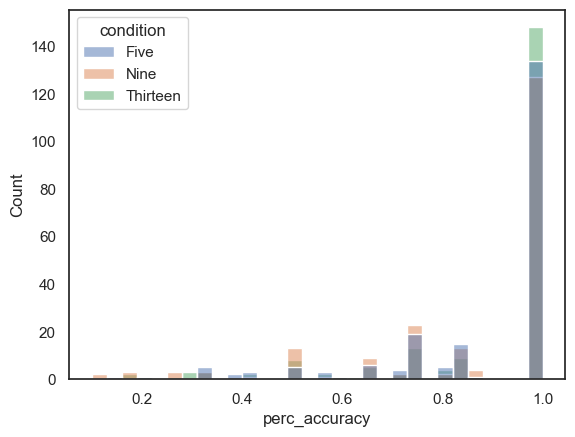

In [263]:
sns.histplot(acc_per_sub_s, x="perc_accuracy", hue="condition", bins=30)

### Anova to test differences 

#### Assumption of normality

In [264]:
pg.normality(data=acc_per_sub_s, dv='perc_accuracy', group='condition').round(2)


W  pval  normal
condition                    
Five       0.67   0.0   False
Nine       0.70   0.0   False
Thirteen   0.60   0.0   False

#### Assumption of normality transformations

In [265]:
#Applied various trasnformations
acc_per_sub_s["log_rt"]=np.log(acc_per_sub_s.perc_accuracy)
acc_per_sub_s["sqrt_rt"]=np.sqrt(acc_per_sub_s.perc_accuracy)
acc_per_sub_s["reciprocal_rt"] = boxcox(acc_per_sub_s.perc_accuracy,-0.5)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Axes: xlabel='reciprocal_rt', ylabel='Count'>

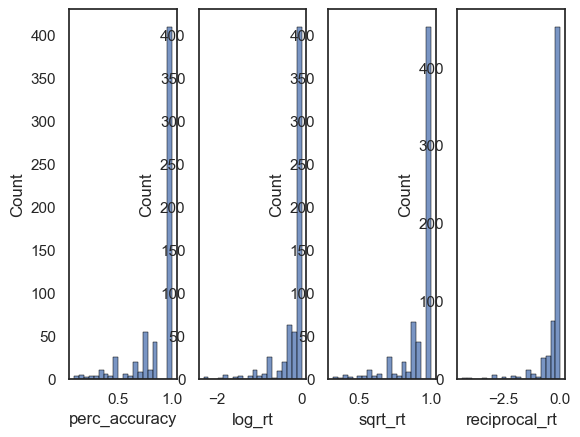

In [266]:
fig, axs = plt.subplots(ncols=4)
sns.histplot(acc_per_sub_s.perc_accuracy,edgecolor='black', bins=20, ax=axs[0])
sns.histplot(acc_per_sub_s.log_rt,edgecolor='black', bins=20, ax=axs[1])
sns.histplot(acc_per_sub_s.sqrt_rt,edgecolor='black', bins=20, ax=axs[2])
sns.histplot(acc_per_sub_s.reciprocal_rt,edgecolor='black', bins=20, ax=axs[3])


In [267]:
# Perform normality tests for each group and condition
results=[]
for group in acc_per_sub_s['diagnosis_group'].unique():
    for condition in acc_per_sub_s['condition'].unique():
        subset = acc_per_sub_s[(acc_per_sub_s['diagnosis_group'] == group) & (acc_per_sub_s['condition'] == condition)]
        test_result = pg.normality(subset['perc_accuracy'], method='shapiro')
        results.append({
            'diagnosis_group': group,
            'condition': condition,
            'p-value': test_result['pval'].values[0],
            'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
        })

results_df = pd.DataFrame(results)
results_df

diagnosis_group condition       p-value Normal
0         control      Five  6.002684e-17     No
1         control      Nine  3.237809e-16     No
2         control  Thirteen  3.848414e-18     No
3             asd      Five  2.172995e-06     No
4             asd      Nine  5.128050e-08     No
5             asd  Thirteen  2.905136e-08     No
6            adhd      Five  4.978592e-07     No
7            adhd      Nine  2.579271e-04     No
8            adhd  Thirteen  1.298368e-07     No

#### Assumption of sphericity (Mauchly’s test)

In [268]:

print(pg.sphericity(data=acc_per_sub_s, dv='perc_accuracy', subject='subject', within='condition')[-1])

# Perform Levene's test for homogeneity of variance
pg.homoscedasticity(data=acc_per_sub_s, dv='perc_accuracy', group='diagnosis_group', method='levene')

0.002504822745732304


W  pval  equal_var
levene NaN   NaN      False

## Condition friedmans

In [269]:
### Friedman Test (non-parametric)
pg.friedman(data=acc_per_sub_s, dv="perc_accuracy", within="condition", subject="subject").round(3)

Source     W  ddof1      Q  p-unc
Friedman  condition  0.03      2  6.332  0.042

In [270]:
acc_per_sub_s.subject.value_counts()

subject
0042P     6
0062P     6
1067P     6
1061S3    6
1061F1    6
         ..
0183M1    6
1147S2    6
1052S1    5
0181P     3
0248S1    1
Name: count, Length: 106, dtype: int64

In [271]:
acc_per_sub_s['cond_det'] = acc_per_sub_s['condition'] + '_'+ acc_per_sub_s['detail']

In [272]:
#acc_per_sub_s.loc[acc_per_sub_s.subject == 'Q1K_002_Z']

In [273]:
posthocs=sp.posthoc_conover_friedman(a=acc_per_sub_s, y_col="perc_accuracy", group_col="cond_det", block_col="subject", block_id_col='subject',
                                 p_adjust="fdr_bh", melted=True)
posthocs["Condition"]= posthocs.index

posthocs


Five_Conjunction  Five_Single  Nine_Conjunction  \
Five_Conjunction              1.000000     0.673274          0.402881   
Five_Single                   0.673274     1.000000          0.186176   
Nine_Conjunction              0.402881     0.186176          1.000000   
Nine_Single                   0.792112     0.777082          0.325041   
Thirteen_Conjunction          0.657599     0.352336          0.737773   
Thirteen_Single               0.004488     0.019949          0.000119   

                      Nine_Single  Thirteen_Conjunction  Thirteen_Single  \
Five_Conjunction         0.792112              0.657599         0.004488   
Five_Single              0.777082              0.352336         0.019949   
Nine_Conjunction         0.325041              0.737773         0.000119   
Nine_Single              1.000000              0.501056         0.008270   
Thirteen_Conjunction     0.501056              1.000000         0.000455   
Thirteen_Single          0.008270              0.000455         1.000000   

                                 Condition  
Five_Conjunction          Five_Conjunction  
Five_Single                    Five_Single  
Nine_Conjunction          Nine_Conjunction  
Nine_Single                    Nine_Single  
Thirteen_Conjunction  Thirteen_Conjunction  
Thirteen_Single            Thirteen_Single

In [274]:
# Add to the document
doc.add_paragraph('Post-hoc testing for each condition', style='List Bullet')

# Add table to the document
doc = df_to_table(doc, posthocs)

In [275]:
# Friedman for each group and condition

#NDD
print ("Friedmans for ASD")
pg.friedman(data=acc_per_sub_s.loc[acc_per_sub_s.diagnosis_group=="asd"] , dv="perc_accuracy", within="detail", subject="subject").round(3)


Friedmans for ASD


Source      W  ddof1      Q  p-unc
Friedman  detail  0.025      1  0.529  0.467

In [276]:
#Control
print ("Friedmans for Control")
pg.friedman(data=acc_per_sub_s.loc[acc_per_sub_s.diagnosis_group=="control"] , dv="perc_accuracy", within="detail", subject="subject").round(3)


Friedmans for Control


Source      W  ddof1      Q  p-unc
Friedman  detail  0.066      1  4.667  0.031

In [277]:
print ("Friedmans for ADHD")
pg.friedman(data=acc_per_sub_s.loc[acc_per_sub_s.diagnosis_group=="adhd"] , dv="perc_accuracy", within="detail", subject="subject").round(3)


Friedmans for ADHD


Source      W  ddof1    Q  p-unc
Friedman  detail  0.042      1  0.5   0.48

In [278]:
# Mann Whitney U test for each differeences between groups for each condition 
pg.pairwise_ttests(data=acc_per_sub_s, dv='perc_accuracy', between='diagnosis_group', within=['condition', 'detail'], subject='subject', parametric=False, padjust='fdr_bh').round(3)


/opt/anaconda3/lib/python3.11/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast condition            A         B Paired Parametric  \
0           condition         -         Five      Nine   True      False   
1           condition         -         Five  Thirteen   True      False   
2           condition         -         Nine  Thirteen   True      False   
3              detail         -  Conjunction    Single   True      False   
4  condition * detail      Five  Conjunction    Single   True      False   
5  condition * detail      Nine  Conjunction    Single   True      False   
6  condition * detail  Thirteen  Conjunction    Single   True      False   

   W-val alternative  p-unc  p-corr p-adjust  hedges  
0  722.5   two-sided  0.410   0.410   fdr_bh   0.114  
1  527.5   two-sided  0.205   0.308   fdr_bh  -0.067  
2  406.5   two-sided  0.006   0.019   fdr_bh  -0.178  
3  736.0   two-sided  0.063     NaN      NaN  -0.185  
4  524.5   two-sided  0.517   0.517   fdr_bh  -0.089  
5  612.5   two-sided  0.487   0.517   fdr_bh  -0.084  
6  212.0   two-sided  0.008   0.024   fdr_bh  -0.315

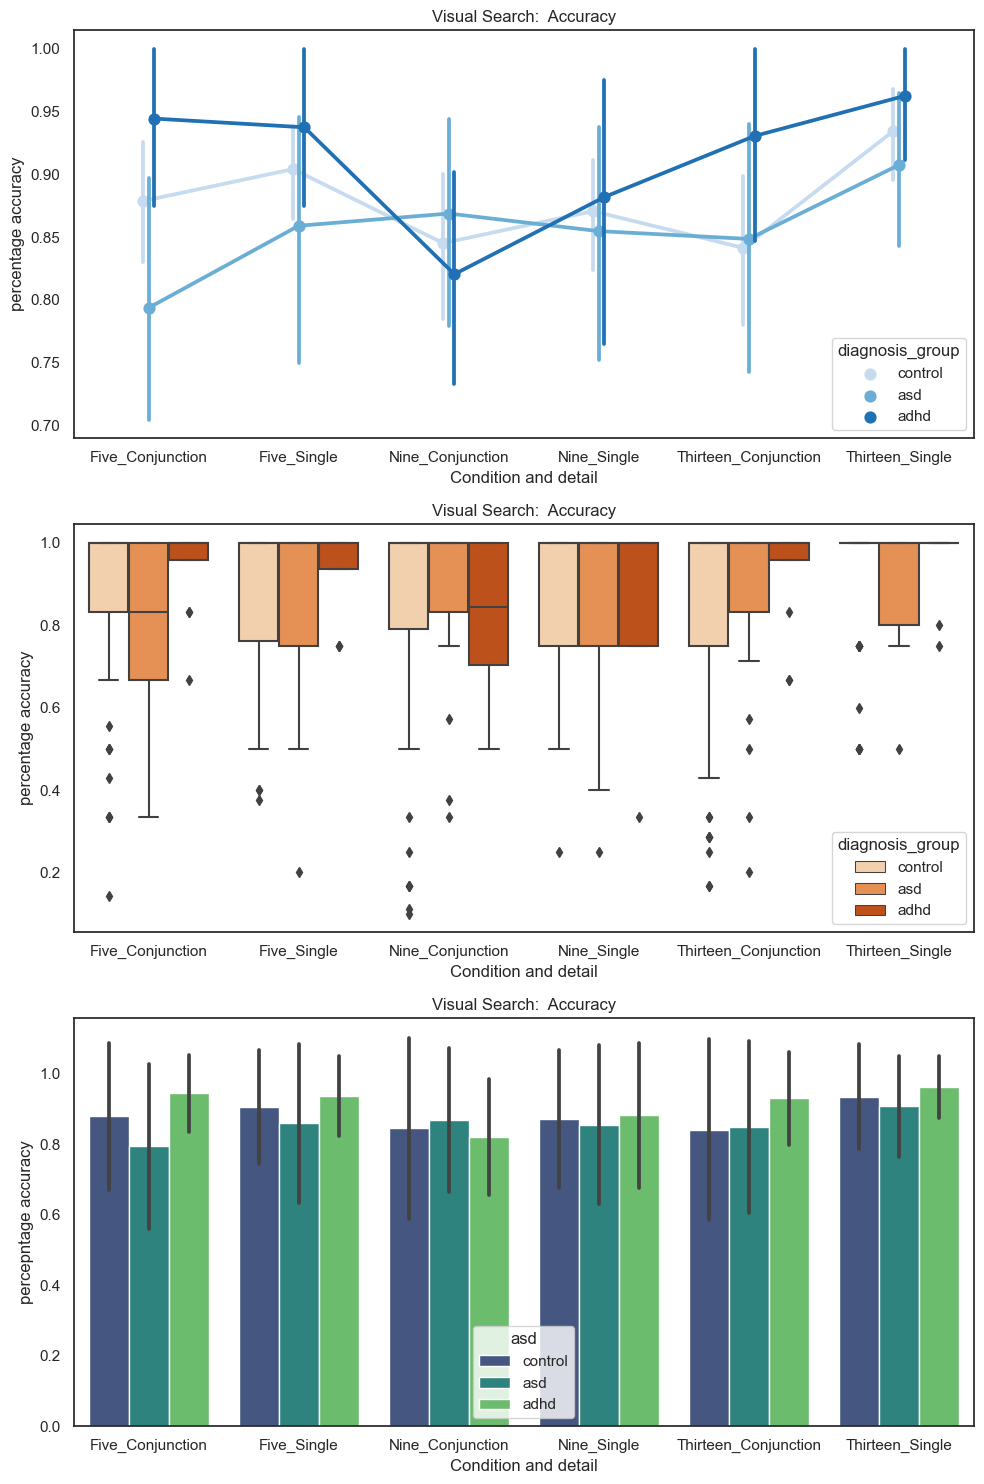

In [279]:


# Setting up the figure layout
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# 1. Boxplot for RT by Condition
sns.pointplot(x="cond_det", y="perc_accuracy", hue="diagnosis_group", data=acc_per_sub_s, ax=axes[0], palette="Blues", dodge=True)#, markers=["o", "s"])
axes[0].set_title("Visual Search:  Accuracy")
axes[0].set_ylabel("percentage accuracy")
axes[0].set_xlabel("Condition and detail")

# 2. Boxplot for RT by Detail (Feature vs. Conjunction)
sns.boxplot(x="cond_det", y="perc_accuracy", hue ="diagnosis_group", data=acc_per_sub_s, ax=axes[1], palette="Oranges")
axes[1].set_title("Visual Search:  Accuracy")
axes[1].set_ylabel("percentage accuracy")
axes[1].set_xlabel("Condition and detail")

# 3. Interaction Plot: RT by Condition and Detail
sns.barplot(x="cond_det", y="perc_accuracy", hue="diagnosis_group", data=acc_per_sub_s, ax=axes[2], errorbar=("sd"), palette="viridis")
axes[2].set_title("Visual Search:  Accuracy")
axes[2].set_ylabel("percepntage accuracy")
axes[2].set_xlabel("Condition and detail")
axes[2].legend(title="asd")

plt.tight_layout()
plt.show()

### Plotting accuracy 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


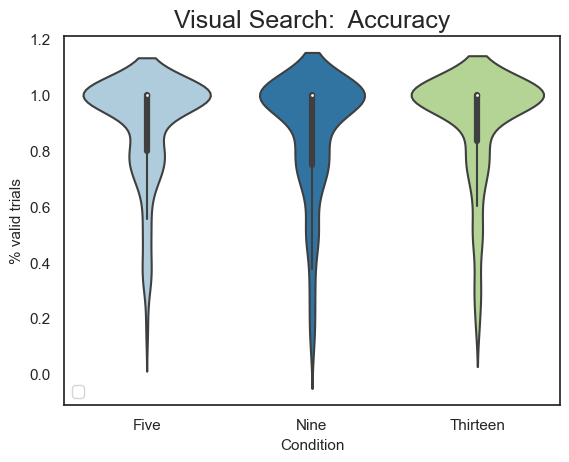

In [280]:
sns.violinplot(x="condition", y="perc_accuracy", data=acc_per_sub_s, palette="Paired"
        ).set_title('Visual Search:  Accuracy',fontsize=18)

plt.grid(False)
plt.ylabel('% valid trials',fontsize=11)
plt.xlabel('Condition',fontsize=11)
plt.legend(loc='lower left')

#plt.ylim([0.7,1.2])

# Save the figure
plt.savefig(f"/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/experimental_files{date}.png")

plt.show()


## Differences in reaction time 

In [281]:
#Remove failed trials, those with negative reaction times and reaction times abova 1 second
rt_df= df[df.VS_VALID]

#rt_df=rt_df.loc[(rt_df.VS_SAC_RT>0)] #& (rt_df.VS_SAC_RT<1000)]

In [282]:
rt_df.VS_VALID.value_counts()

VS_VALID
True    2740
Name: count, dtype: int64

In [283]:

rt_sub = pd.DataFrame(rt_df).reset_index().rename(columns={"VS_SAC_RT": "rt"})

# Calculate descriptive statistics including the mean
rt_decriptive_stats = rt_sub.groupby(["condition", "detail"]).rt.agg(['mean', 'std', 'min', 'max']).reset_index()

# Round to 2 decimal places
rt_decriptive_stats = rt_decriptive_stats.round(2)

rt_decriptive_stats

condition       detail        mean     std  min   max
0      Five  Conjunction  789.230347  817.57   79  3845
1      Five       Single  805.567204  738.87  162  3932
2      Nine  Conjunction   638.49162  644.97   68  3774
3      Nine       Single  626.240437  690.85  168  3704
4  Thirteen  Conjunction  626.065543  613.25   45  3632
5  Thirteen       Single  590.484375  716.47  155  3928

In [284]:
rt_sub["diagnosis_group"] = rt_sub["diagnosis_group"].fillna("Unknown")
rt_sub

index subject Trial_Index_ condition       detail   rt VS_VALID  \
0         0  1009S1            1      Five       Single  628     True   
1         1  1009S1            2      Nine       Single  344     True   
2         2  1009S1            3  Thirteen       Single  244     True   
3         3  1009S1            4      Five       Single  931     True   
4         4  1009S1            5      Nine       Single  197     True   
...     ...     ...          ...       ...          ...  ...      ...   
2735   3204  1121M1           26      Nine  Conjunction  170     True   
2736   3205  1121M1           27      Nine  Conjunction  199     True   
2737   3206  1121M1           28  Thirteen  Conjunction  229     True   
2738   3207  1121M1           29  Thirteen  Conjunction  258     True   
2739   3208  1121M1           30  Thirteen  Conjunction  227     True   

                                   vs_location_list        age    group site  \
0                                  (7, 2, 9, 14, 4)  13.571805  sibling  hsj   
1                   (1, 15, 2, 10, 6, 11, 7, 4, 16)  13.571805  sibling  hsj   
2     (3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)  13.571805  sibling  hsj   
3                                 (10, 0, 14, 3, 2)  13.571805  sibling  hsj   
4                   (3, 10, 0, 13, 9, 16, 14, 5, 7)  13.571805  sibling  hsj   
...                                             ...        ...      ...  ...   
2735                  (0, 3, 11, 13, 7, 8, 5, 1, 6)  39.225994   mother  hsj   
2736                 (13, 8, 7, 5, 0, 4, 16, 11, 1)  39.225994   mother  hsj   
2737   (15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)  39.225994   mother  hsj   
2738  (6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)  39.225994   mother  hsj   
2739  (7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)  39.225994   mother  hsj   

         sex      asd adhd record_id age_group diagnosis_group  
0     female  control    0  525-1011     child         control  
1     female  control    0  525-1011     child         control  
2     female  control    0  525-1011     child         control  
3     female  control    0  525-1011     child         control  
4     female  control    0  525-1011     child         control  
...      ...      ...  ...       ...       ...             ...  
2735  female  control    0  525-1123     adult         control  
2736  female  control    0  525-1123     adult         control  
2737  female  control    0  525-1123     adult         control  
2738  female  control    0  525-1123     adult         control  
2739  female  control    0  525-1123     adult         control  

[2740 rows x 17 columns]

In [285]:
## TAKE OUT CLOSE TARGET TRIALS
# Check if vs_location_list is a string or a list and handle accordingly
def extract_first_location(vs_location):
    if isinstance(vs_location, str):  # In case it's a string
        return int(vs_location.strip('()').split(', ')[0])
    elif isinstance(vs_location, list):  # In case it's already a list
        return vs_location[0]

# Apply the function to filter rows
rt_sub = rt_sub[rt_sub['vs_location_list'].apply(extract_first_location) < 12]
rt_sub

index subject Trial_Index_ condition       detail   rt VS_VALID  \
0         0  1009S1            1      Five       Single  628     True   
1         1  1009S1            2      Nine       Single  344     True   
2         2  1009S1            3  Thirteen       Single  244     True   
3         3  1009S1            4      Five       Single  931     True   
4         4  1009S1            5      Nine       Single  197     True   
...     ...     ...          ...       ...          ...  ...      ...   
2733   3202  1121M1           24      Five  Conjunction  282     True   
2734   3203  1121M1           25      Nine  Conjunction  237     True   
2735   3204  1121M1           26      Nine  Conjunction  170     True   
2738   3207  1121M1           29  Thirteen  Conjunction  258     True   
2739   3208  1121M1           30  Thirteen  Conjunction  227     True   

                                   vs_location_list        age    group site  \
0                                  (7, 2, 9, 14, 4)  13.571805  sibling  hsj   
1                   (1, 15, 2, 10, 6, 11, 7, 4, 16)  13.571805  sibling  hsj   
2     (3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)  13.571805  sibling  hsj   
3                                 (10, 0, 14, 3, 2)  13.571805  sibling  hsj   
4                   (3, 10, 0, 13, 9, 16, 14, 5, 7)  13.571805  sibling  hsj   
...                                             ...        ...      ...  ...   
2733                               (5, 9, 4, 15, 6)  39.225994   mother  hsj   
2734               (3, 12, 1, 6, 2, 11, 15, 16, 10)  39.225994   mother  hsj   
2735                  (0, 3, 11, 13, 7, 8, 5, 1, 6)  39.225994   mother  hsj   
2738  (6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)  39.225994   mother  hsj   
2739  (7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)  39.225994   mother  hsj   

         sex      asd adhd record_id age_group diagnosis_group  
0     female  control    0  525-1011     child         control  
1     female  control    0  525-1011     child         control  
2     female  control    0  525-1011     child         control  
3     female  control    0  525-1011     child         control  
4     female  control    0  525-1011     child         control  
...      ...      ...  ...       ...       ...             ...  
2733  female  control    0  525-1123     adult         control  
2734  female  control    0  525-1123     adult         control  
2735  female  control    0  525-1123     adult         control  
2738  female  control    0  525-1123     adult         control  
2739  female  control    0  525-1123     adult         control  

[2253 rows x 17 columns]

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2391122843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_sub["condition"] = rt_sub["condition"].astype(str)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2391122843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_sub["diagnosis_group"] = rt_sub["diagnosis_group"].astype(str)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2391122843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

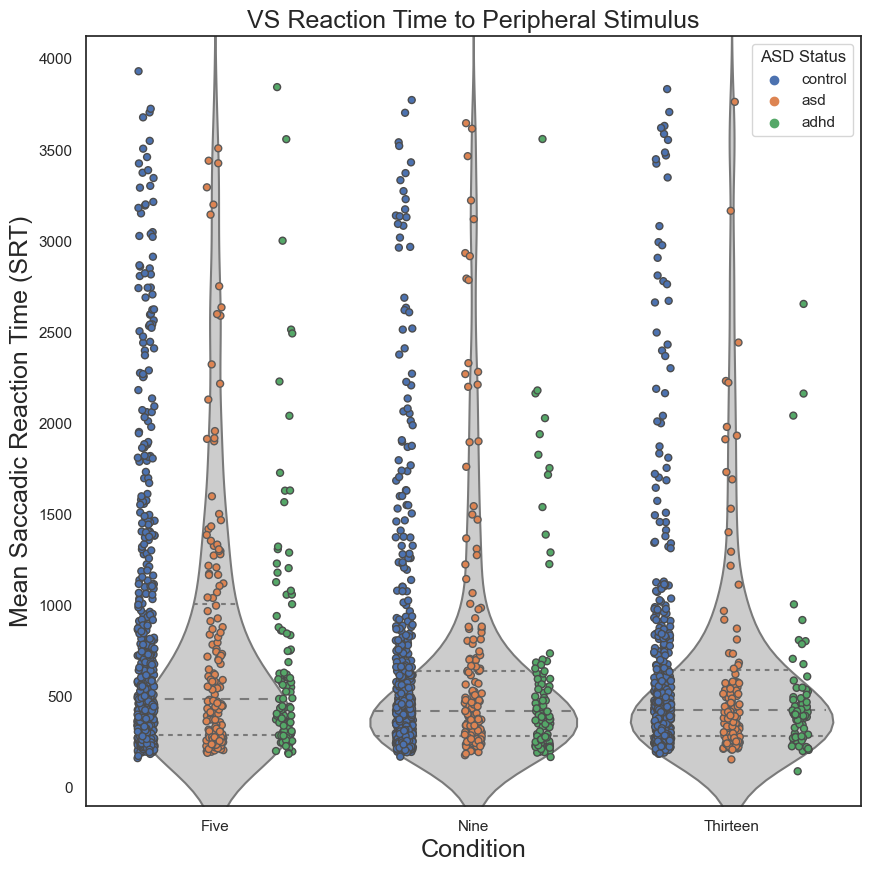

In [286]:
# Convert to categorical
rt_sub["condition"] = rt_sub["condition"].astype(str)
rt_sub["diagnosis_group"] = rt_sub["diagnosis_group"].astype(str)
rt_sub["rt"] = pd.to_numeric(rt_sub["rt"], errors='coerce')

# Drop NaNs
rt_sub = rt_sub.dropna(subset=["condition", "rt"])

plt.figure(figsize=(10, 10))

# Violin plot
sns.violinplot(x="condition", y="rt", inner='quartile', data=rt_sub, color=".8")

# Strip plot (overlayed)
sns.stripplot(x="condition", y="rt", hue="diagnosis_group", data=rt_sub, dodge=True, jitter=True, linewidth=1)

# Title and labels
plt.title('VS Reaction Time to Peripheral Stimulus', fontsize=18)
plt.ylabel('Mean Saccadic Reaction Time (SRT)', fontsize=18)
plt.xlabel('Condition', fontsize=18)

# Legend
plt.legend(title="ASD Status")

plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


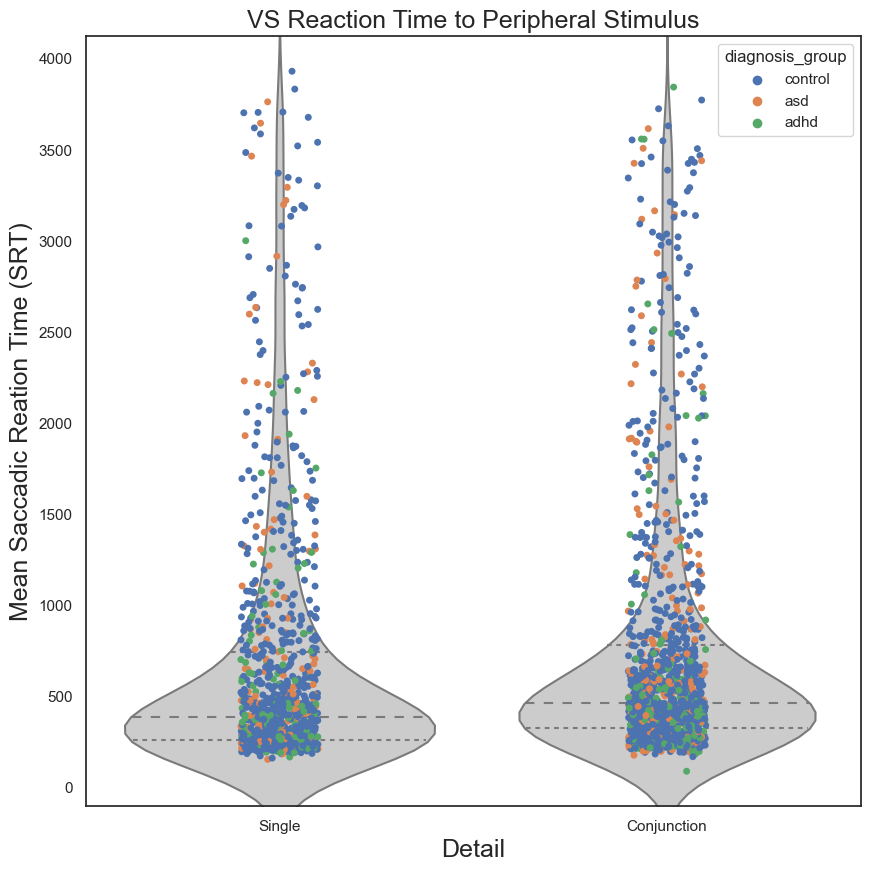

In [287]:
ax = plt.figure(figsize=(10, 10))
ax = sns.violinplot(x="detail", y="rt", inner='quartile', data=rt_sub, 
                    color=".8").set_title('VS Reaction Time to Peripheral Stimulus',fontsize=18)
ax = sns.stripplot(x="detail", y="rt", hue="diagnosis_group", data=rt_sub)
ax = plt.ylabel('Mean Saccadic Reation Time (SRT)',fontsize=18)
ax = plt.xlabel('Detail',fontsize=18)
#plt.savefig('vs_plot_2.png')

### Outlier detection for each subject

In [288]:
# Remove outliers for each subject

n_before = len(rt_sub)
print ("Toral number of trials before removal: ", len(rt_sub))
summary_outliers= []
for sub in rt_df.subject.unique():
    df=rt_df.loc[rt_df.subject==sub]
    # Function to perform outlier removal using IQR
    Q1 = df["VS_SAC_RT"].quantile(0.25)
    Q3 = df["VS_SAC_RT"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # Should be 1.5 but can be adjusted to 3
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df["VS_SAC_RT"] >= lower_bound) & (df["VS_SAC_RT"] <= upper_bound)]
    df_removed = df[(df["VS_SAC_RT"] < lower_bound) | (df["VS_SAC_RT"] > upper_bound)]
    summary_outliers.append(df_removed)
    # Remove the outlier trials from the main dataframe
    if outlier_rem:
        rt_sub = rt_sub[~rt_sub.index.isin(df_removed.index)]
   
    print( "Subject: ", sub, "n trials removed: ", len(df_removed), "% left: ", len(df_filtered)/len(df)*100)

print ("Toral number of trials after removal: ", len(rt_sub))
n_after = len(rt_sub)
summary_outliers_df = pd.concat(summary_outliers, axis=0)


Toral number of trials before removal:  2253
Subject:  1009S1 n trials removed:  2 % left:  93.33333333333333
Subject:  0179P n trials removed:  7 % left:  76.66666666666667
Subject:  0216M1 n trials removed:  2 % left:  93.33333333333333
Subject:  0179M1 n trials removed:  7 % left:  76.66666666666667
Subject:  0146P n trials removed:  0 % left:  100.0
Subject:  0093O1 n trials removed:  1 % left:  90.9090909090909
Subject:  1073M1 n trials removed:  6 % left:  80.0
Subject:  1037F1 n trials removed:  6 % left:  77.77777777777779
Subject:  1106M1 n trials removed:  2 % left:  93.10344827586206
Subject:  1114P n trials removed:  0 % left:  100.0
Subject:  0223M1 n trials removed:  1 % left:  92.85714285714286
Subject:  0196M1 n trials removed:  5 % left:  82.75862068965517
Subject:  1134S1 n trials removed:  4 % left:  86.66666666666667
Subject:  0162S1 n trials removed:  3 % left:  90.0
Subject:  0200M1 n trials removed:  1 % left:  96.66666666666667
Subject:  0265P n trials removed: 

In [289]:
# Calculate the number of trials removed and how many per condition
summary_outliers_df.groupby(["condition", 'detail']).size().reset_index(name="n_removed")

condition       detail  n_removed
0      Five  Conjunction         57
1      Five       Single         53
2      Nine  Conjunction         33
3      Nine       Single         22
4  Thirteen  Conjunction         38
5  Thirteen       Single         26

In [290]:
# Calculate the number of trials removed per subject and condition
summary_outliers_df2=summary_outliers_df.groupby(["subject", "condition", 'detail']).size().reset_index(name="n_trials_removed").pivot(index="subject", columns=[ "condition", 'detail'], values="n_trials_removed")
summary_outliers_df2

condition   Five    Thirteen               Five   Nine            
detail    Single Conjunction Single Conjunction Single Conjunction
subject                                                           
0042P        1.0         1.0    1.0         NaN    NaN         NaN
0064S1       NaN         NaN    1.0         1.0    NaN         NaN
0068F1       NaN         NaN    NaN         1.0    1.0         NaN
0068S1       1.0         NaN    1.0         2.0    NaN         1.0
0068S3       NaN         NaN    NaN         NaN    NaN         1.0
...          ...         ...    ...         ...    ...         ...
1134S1       1.0         NaN    1.0         2.0    NaN         NaN
1147F1       1.0         NaN    1.0         1.0    NaN         NaN
1147P        1.0         NaN    1.0         NaN    NaN         NaN
1147S1       NaN         2.0    NaN         NaN    NaN         NaN
1147S2       NaN         NaN    1.0         NaN    1.0         NaN

[86 rows x 6 columns]

In [291]:

# Create a table with the RT descriptive stats for both groups
rt_groups = (
    rt_sub.groupby(["subject", "diagnosis_group", "condition", "detail"])["rt"]
    .mean()
    .reset_index()
    .groupby(["diagnosis_group", "condition", "detail"])["rt"]
    .describe()
    .reset_index()
)

# Round and select important columns
rt_groups = rt_groups[["diagnosis_group", "condition", "detail", "mean", "std"]].round(2)

# Create table for combined groups
rt_combined = (
    rt_sub.groupby(["subject", "condition", "detail"])["rt"]
    .mean()
    .reset_index()
    .groupby(["condition", "detail"])["rt"]
    .describe()
    .reset_index()
)

# Round and select important columns
rt_combined = rt_combined[["condition", "detail", "mean", "std"]].round(2)
rt_combined["diagnosis_group"] = "combined"

# Merge tables
rt_combined = pd.concat([rt_groups, rt_combined], axis=0)

# Pivot table with 'detail' as a subcolumn
rt_combined = rt_combined.pivot(index=["condition", "detail"], columns=["diagnosis_group"], values=["mean", "std"]).reset_index()

# Display the final table
rt_combined

condition       detail    mean                           \
diagnosis_group                           adhd     asd combined control   
0                    Five  Conjunction  732.12  846.95   895.61  937.64   
1                    Five       Single  742.50  716.60   811.28  848.77   
2                    Nine  Conjunction  688.07  873.62   768.05  749.29   
3                    Nine       Single  565.47  780.86   654.78  634.36   
4                Thirteen  Conjunction  600.62  667.34   790.19  860.81   
5                Thirteen       Single  370.22  606.71   601.02  638.43   

                    std                           
diagnosis_group    adhd     asd combined control  
0                423.58  488.36   593.65  644.32  
1                412.33  302.66   533.37  597.14  
2                453.58  788.03   565.32  501.84  
3                306.97  770.52   540.07  492.68  
4                480.37  411.72   631.54  699.14  
5                109.65  472.68   538.82  591.57

In [292]:
rt_groups

diagnosis_group condition       detail    mean     std
0             adhd      Five  Conjunction  732.12  423.58
1             adhd      Five       Single  742.50  412.33
2             adhd      Nine  Conjunction  688.07  453.58
3             adhd      Nine       Single  565.47  306.97
4             adhd  Thirteen  Conjunction  600.62  480.37
5             adhd  Thirteen       Single  370.22  109.65
6              asd      Five  Conjunction  846.95  488.36
7              asd      Five       Single  716.60  302.66
8              asd      Nine  Conjunction  873.62  788.03
9              asd      Nine       Single  780.86  770.52
10             asd  Thirteen  Conjunction  667.34  411.72
11             asd  Thirteen       Single  606.71  472.68
12         control      Five  Conjunction  937.64  644.32
13         control      Five       Single  848.77  597.14
14         control      Nine  Conjunction  749.29  501.84
15         control      Nine       Single  634.36  492.68
16         control  Thirteen  Conjunction  860.81  699.14
17         control  Thirteen       Single  638.43  591.57

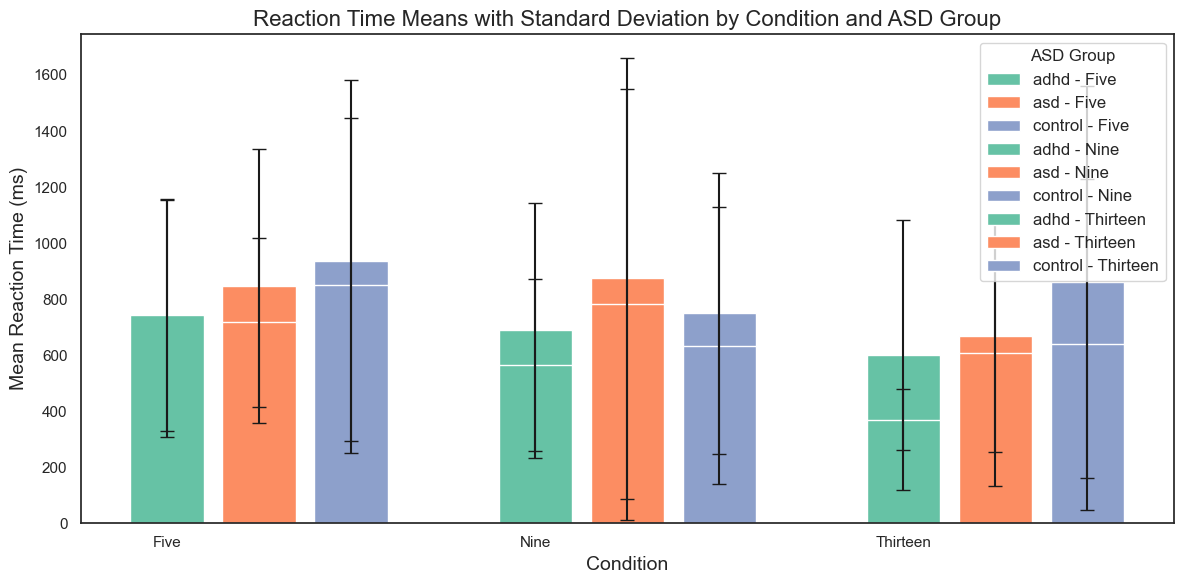

In [293]:
# Create a color palette for 'asd' groups
palette = sns.color_palette("Set2", n_colors=len(rt_groups['diagnosis_group'].unique()))

# Create the figure
plt.figure(figsize=(12, 6))

# Loop over each unique condition to plot bars with error bars
for idx, condition in enumerate(rt_groups['condition'].unique()):
    for asd_idx, asd_group in enumerate(rt_groups['diagnosis_group'].unique()):
        data = rt_groups[(rt_groups['condition'] == condition) & (rt_groups['diagnosis_group'] == asd_group)]
        
        # Plotting the bar plot with different colors for each 'asd' group
        plt.bar(idx + asd_idx * 0.25,
                data['mean'], yerr=data['std'], capsize=5, label=f'{asd_group} - {condition}',
                color=palette[asd_idx], width=0.2, align='center')

# Adding details
plt.title('Reaction Time Means with Standard Deviation by Condition and ASD Group', fontsize=16)
plt.ylabel('Mean Reaction Time (ms)', fontsize=14)
plt.xlabel('Condition', fontsize=14)
plt.xticks(np.arange(len(rt_groups['condition'].unique())), rt_groups['condition'].unique())
plt.legend(title="ASD Group", fontsize=12)

plt.tight_layout()
plt.show()

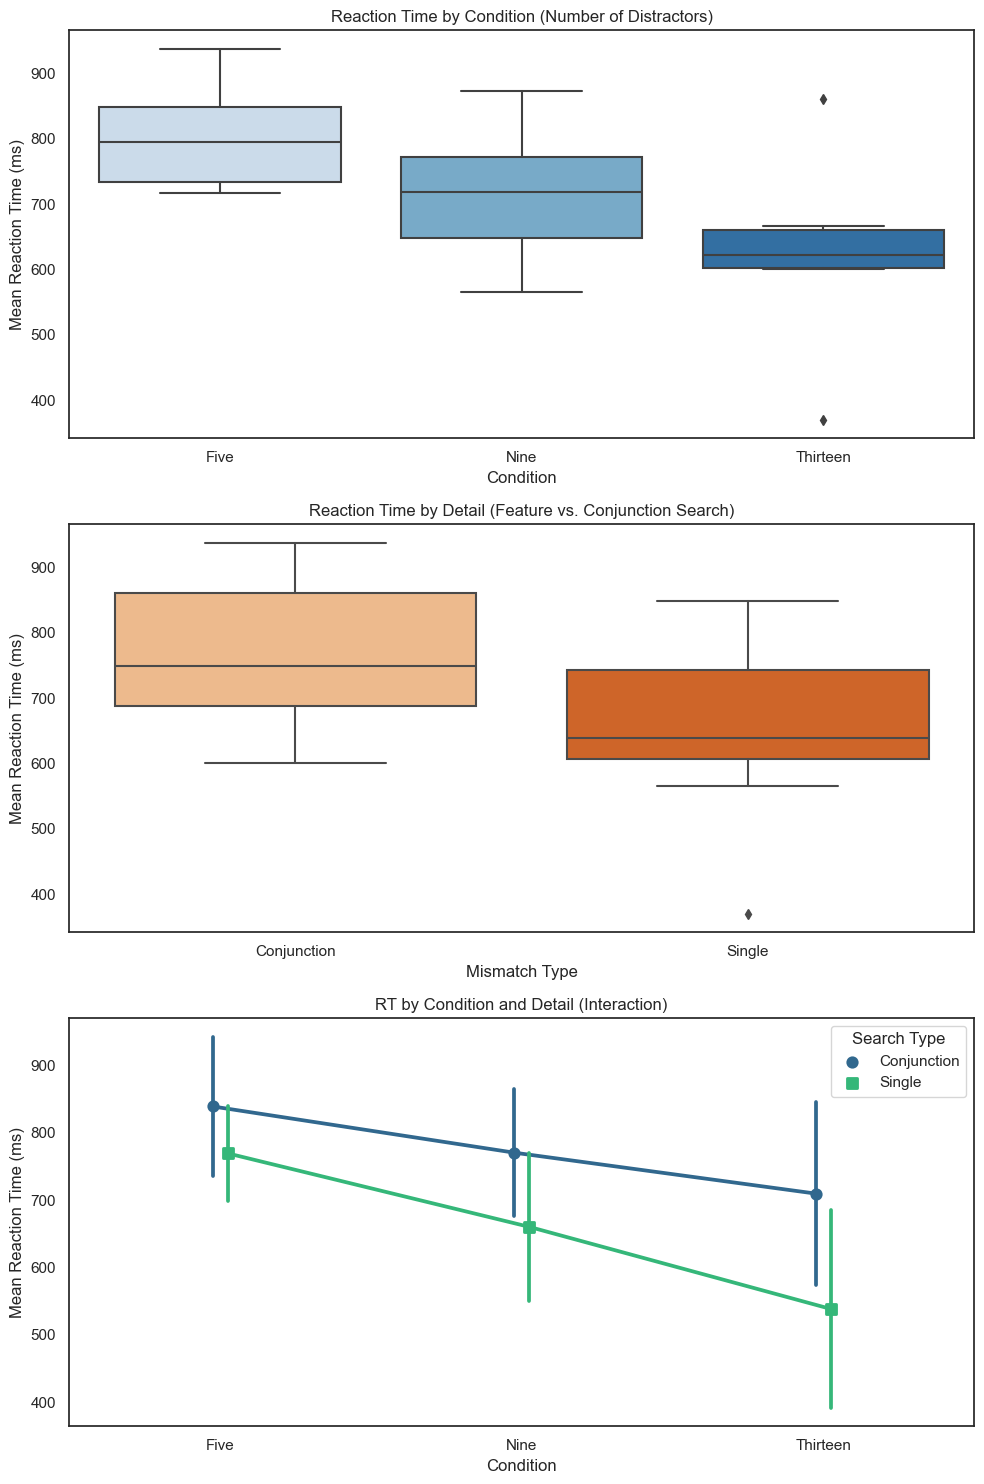

In [294]:
# Setting up the figure layout
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# 1. Boxplot for RT by Condition
sns.boxplot(x="condition", y="mean", data=rt_groups, ax=axes[0], palette="Blues")
axes[0].set_title("Reaction Time by Condition (Number of Distractors)")
axes[0].set_ylabel("Mean Reaction Time (ms)")
axes[0].set_xlabel("Condition")

# 2. Boxplot for RT by Detail (Feature vs. Conjunction)
sns.boxplot(x="detail", y="mean", data=rt_groups, ax=axes[1], palette="Oranges")
axes[1].set_title("Reaction Time by Detail (Feature vs. Conjunction Search)")
axes[1].set_ylabel("Mean Reaction Time (ms)")
axes[1].set_xlabel("Mismatch Type")

# 3. Interaction Plot: RT by Condition and Detail
sns.pointplot(x="condition", y="mean", hue="detail", data=rt_groups, ax=axes[2], errorbar=("sd"), palette="viridis", dodge=True, markers=["o", "s"])
axes[2].set_title("RT by Condition and Detail (Interaction)")
axes[2].set_ylabel("Mean Reaction Time (ms)")
axes[2].set_xlabel("Condition")
axes[2].legend(title="Search Type")

plt.tight_layout()
plt.show()

In [295]:
# Compute the number of trials per condition and detail for the NDD group
ndd_trials = (
    rt_sub.loc[rt_sub.diagnosis_group == "asd"]
    .groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="asd")
    .groupby(["condition", "detail"])["asd"]
    .mean()
    .reset_index()
)

# Compute the number of trials per condition and detail for the Control group
ctrl_trials = (
    rt_sub.loc[rt_sub.diagnosis_group == "control"]
    .groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="control")
    .groupby(["condition", "detail"])["control"]
    .mean()
    .reset_index()
)

# Compute the number of trials per condition and detail for the Combined group
combined_trials = (
    rt_sub.groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="combined")
    .groupby(["condition", "detail"])["combined"]
    .mean()
    .reset_index()
)

# Merge tables
combined_trials = pd.merge(ndd_trials, ctrl_trials, on=["condition", "detail"], how="outer")

# Pivot table to organize by condition and detail
combined_trials = combined_trials.pivot(index=["detail"], columns=["condition"]).reset_index()

# Display the final table
combined_trials

detail       asd                  control                    
condition                   Five  Nine Thirteen      Five      Nine  Thirteen
0          Conjunction  3.857143  4.00     3.45  4.028169  4.149254  3.194030
1               Single  3.421053  3.35     2.50  3.371429  3.239437  2.450704

In [296]:
#Compute number of trials per condition and detail per subject
n_trials = (
    rt_df.groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="n_trials")
    .pivot(index="subject", columns=["condition", "detail"], values="n_trials")
)


In [297]:
# Check how many subjects have at least 1 trials per condition

n_trials=rt_sub.groupby(["subject", "condition", "detail"]).size().reset_index(name="n_trials").pivot(index="subject", columns= [ "condition", "detail"], values="n_trials")

# Check any rows with less than 4 trials
if outlier_rem:
    not_enough_trials=n_trials[n_trials < 1].dropna(how="all")
    not_enough_trials
else:
    not_enough_trials=n_trials[n_trials < 1].dropna(how="all")

    print ("No outlier removal") 

In [298]:
n_trials.round(0)

condition        Five               Nine           Thirteen       
detail    Conjunction Single Conjunction Single Conjunction Single
subject                                                           
0042P             5.0    3.0         5.0    4.0         4.0    3.0
0062P             4.0    4.0         4.0    4.0         4.0    2.0
0064M1            5.0    4.0         5.0    4.0         4.0    3.0
0064S1            5.0    4.0         5.0    3.0         4.0    3.0
0068F1            4.0    4.0         4.0    3.0         4.0    1.0
...               ...    ...         ...    ...         ...    ...
1140S1            3.0    2.0         NaN    4.0         2.0    2.0
1147F1            5.0    4.0         5.0    4.0         4.0    3.0
1147P             2.0    3.0         4.0    4.0         4.0    2.0
1147S1            4.0    4.0         4.0    4.0         4.0    3.0
1147S2            5.0    3.0         5.0    4.0         4.0    3.0

[104 rows x 6 columns]

In [299]:
# Change age_group to object
rt_sub["age_group"] = rt_sub["age_group"].astype(str)
outlier_demo= rt_sub.groupby(["subject","diagnosis_group","sex","age", "site","age_group"]).count().reset_index()
# Select important columns
outlier_demo=outlier_demo[["subject", "diagnosis_group", "sex", "age", "index", "site", "age_group"]].rename(columns={"index":"n_trials"}) 
outlier_demo

subject diagnosis_group     sex        age  n_trials site age_group
0     0042P         control  female  30.215656        24  mni     adult
1     0062P         control  female  40.209016        22  hsj     adult
2    0064M1         control  female  38.204754        25  hsj     adult
3    0064S1             asd    male  12.345223        24  hsj     child
4    0068F1         control    male  43.998166        20  mni     adult
..      ...             ...     ...        ...       ...  ...       ...
99   1140S1         control  female   9.637547        13  hsj     child
100  1147F1         control    male  50.643180        25  hsj     adult
101   1147P             asd    male  16.233165        19  hsj     child
102  1147S1         control    male  13.254322        23  hsj     child
103  1147S2         control  female  22.787714        24  hsj     adult

[104 rows x 7 columns]

#### Participant demographics after all outlier removal

In [300]:

# Summarize data by diagnosis groups
summary_table = outlier_demo.groupby("diagnosis_group").agg(
    n=("diagnosis_group", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
    mean_age=("age", "mean"),
    std_age=("age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
    n_trials=("n_trials", "mean")
).reset_index()

# Add combined row for all participants
all_participants = {
    "diagnosis_group": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": outlier_demo["age"].mean(),
    "std_age": outlier_demo["age"].std(),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
    "n_trials": summary_table["n_trials"].mean()
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
summary_table["site % (HSJ:MNI)"] = (
    (summary_table["hsj"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["mni"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "diagnosis_group": "NDD Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
        "n_trials": "Mean Trials"
    },
    inplace=True,
)
summary_table

NDD Group  Total Participants   Mean Age     Age SD  Adults  Children  \
0  combined                 104  28.879243  16.268302      61        43   
1      adhd                  12  24.254396  15.503288       5         7   
2       asd                  21  13.838300   5.530230       3        18   
3   control                  71  34.109638  15.608766      53        18   

   Mean Trials sex (M:F)  sex % (M:F) site (HSJ:MNI) site % (HSJ:MNI)  
0    20.149340     44:60  42.31:57.69          67:37      64.42:35.58  
1    20.666667       5:7  41.67:58.33           10:2      83.33:16.67  
2    19.809524      12:9  57.14:42.86          11:10      52.38:47.62  
3    19.971831     27:44  38.03:61.97          46:25      64.79:35.21

##  Melting the data (Visual Search)



In [301]:
vs_rt=rt_sub[["subject","condition", "detail", "rt", "vs_location_list"]]

In [302]:
vs_rt

subject condition       detail   rt  \
1     1009S1      Nine       Single  344   
2     1009S1  Thirteen       Single  244   
4     1009S1      Nine       Single  197   
6     1009S1      Five  Conjunction  311   
7     1009S1      Five  Conjunction  235   
...      ...       ...          ...  ...   
2733  1121M1      Five  Conjunction  282   
2734  1121M1      Nine  Conjunction  237   
2735  1121M1      Nine  Conjunction  170   
2738  1121M1  Thirteen  Conjunction  258   
2739  1121M1  Thirteen  Conjunction  227   

                                   vs_location_list  
1                   (1, 15, 2, 10, 6, 11, 7, 4, 16)  
2     (3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)  
4                   (3, 10, 0, 13, 9, 16, 14, 5, 7)  
6                                 (8, 9, 10, 15, 1)  
7                                  (11, 5, 8, 6, 0)  
...                                             ...  
2733                               (5, 9, 4, 15, 6)  
2734               (3, 12, 1, 6, 2, 11, 15, 16, 10)  
2735                  (0, 3, 11, 13, 7, 8, 5, 1, 6)  
2738  (6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)  
2739  (7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)  

[2082 rows x 5 columns]

In [303]:
vs_grouped= vs_rt
#grouped.dropna(inplace=True)

# check for na 
vs_grouped[vs_grouped.isna().any(axis=1)]

Empty DataFrame
Columns: [subject, condition, detail, rt, vs_location_list]
Index: []

In [304]:
## Add demographic back to vs_grouped
vs_grouped=pd.merge(vs_grouped, outlier_demo, on="subject", how="inner")
vs_grouped

subject condition       detail   rt  \
0     1009S1      Nine       Single  344   
1     1009S1  Thirteen       Single  244   
2     1009S1      Nine       Single  197   
3     1009S1      Five  Conjunction  311   
4     1009S1      Five  Conjunction  235   
...      ...       ...          ...  ...   
2077  1121M1      Five  Conjunction  282   
2078  1121M1      Nine  Conjunction  237   
2079  1121M1      Nine  Conjunction  170   
2080  1121M1  Thirteen  Conjunction  258   
2081  1121M1  Thirteen  Conjunction  227   

                                   vs_location_list diagnosis_group     sex  \
0                   (1, 15, 2, 10, 6, 11, 7, 4, 16)         control  female   
1     (3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)         control  female   
2                   (3, 10, 0, 13, 9, 16, 14, 5, 7)         control  female   
3                                 (8, 9, 10, 15, 1)         control  female   
4                                  (11, 5, 8, 6, 0)         control  female   
...                                             ...             ...     ...   
2077                               (5, 9, 4, 15, 6)         control  female   
2078               (3, 12, 1, 6, 2, 11, 15, 16, 10)         control  female   
2079                  (0, 3, 11, 13, 7, 8, 5, 1, 6)         control  female   
2080  (6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)         control  female   
2081  (7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)         control  female   

            age  n_trials site age_group  
0     13.571805        23  hsj     child  
1     13.571805        23  hsj     child  
2     13.571805        23  hsj     child  
3     13.571805        23  hsj     child  
4     13.571805        23  hsj     child  
...         ...       ...  ...       ...  
2077  39.225994        23  hsj     adult  
2078  39.225994        23  hsj     adult  
2079  39.225994        23  hsj     adult  
2080  39.225994        23  hsj     adult  
2081  39.225994        23  hsj     adult  

[2082 rows x 11 columns]

### Anova to test differences 

#### Assumption of normality

In [305]:
pg.normality(data=vs_grouped, dv='rt', group='condition')

W          pval  normal
condition                                
Nine       0.632208  3.661497e-37   False
Thirteen   0.614406  8.653590e-34   False
Five       0.727846  2.008875e-33   False

In [306]:
pg.normality(data=vs_grouped, dv='rt', group='detail')

W          pval  normal
detail                                     
Single       0.648692  4.480372e-40   False
Conjunction  0.673188  3.011390e-42   False

In [307]:
# Perform normality tests for each group and condition and detauk
results=[]

for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        
        subset = vs_grouped[(vs_grouped['diagnosis_group'] == group) & (vs_grouped['condition'] == condition)]
        test_result = pg.normality(subset['rt'], method='shapiro')
        results.append({
            'diagnosis_group': group,
            'condition': condition,
            'p-value': test_result['pval'].values[0],
            'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
        })

results_df = pd.DataFrame(results)


results_df

diagnosis_group condition       p-value Normal
0         control      Nine  9.858469e-32     No
1         control  Thirteen  5.003220e-28     No
2         control      Five  4.112951e-28     No
3             asd      Nine  1.767617e-17     No
4             asd  Thirteen  2.372680e-16     No
5             asd      Five  4.056269e-15     No
6            adhd      Nine  1.124082e-13     No
7            adhd  Thirteen  3.088688e-12     No
8            adhd      Five  1.075930e-12     No

In [308]:
# Store results in a list
results = []

# Iterate over unique (asd, condition, DETAIL) combinations
for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        for detail in vs_grouped['detail'].unique():
            
            # Subset the data
            subset = vs_grouped[
                (vs_grouped['diagnosis_group'] == group) & 
                (vs_grouped['condition'] == condition) & 
                (vs_grouped['detail'] == detail)
            ]
            
            # Ensure the subset is not empty
            if len(subset) > 2:  # Shapiro-Wilk requires at least 3 samples
                test_result = pg.normality(subset['rt'], method='shapiro')
                results.append({
                    'diagnosis_group': group,
                    'condition': condition,
                    'detail': detail,
                    'p-value': test_result['pval'].values[0],
                    'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
                })

# Convert list of results into a DataFrame
results_df = pd.DataFrame(results)
results_df

diagnosis_group condition       detail       p-value Normal
0          control      Nine       Single  2.163859e-23     No
1          control      Nine  Conjunction  3.590492e-23     No
2          control  Thirteen       Single  1.567678e-20     No
3          control  Thirteen  Conjunction  3.131188e-21     No
4          control      Five       Single  9.353045e-19     No
5          control      Five  Conjunction  1.286404e-21     No
6              asd      Nine       Single  2.472597e-12     No
7              asd      Nine  Conjunction  4.497855e-12     No
8              asd  Thirteen       Single  5.597532e-11     No
9              asd  Thirteen  Conjunction  2.503801e-12     No
10             asd      Five       Single  3.367297e-10     No
11             asd      Five  Conjunction  1.870259e-10     No
12            adhd      Nine       Single  2.537755e-08     No
13            adhd      Nine  Conjunction  1.327830e-10     No
14            adhd  Thirteen       Single  4.989921e-06     No
15            adhd  Thirteen  Conjunction  8.356120e-09     No
16            adhd      Five       Single  3.106654e-06     No
17            adhd      Five  Conjunction  3.765566e-10     No

#### Assumption of normality transformations

In [309]:
#Applied various trasnformations
vs_grouped["log_rt"]=np.log(vs_grouped.rt)
vs_grouped["sqrt_rt"]=np.sqrt(vs_grouped.rt)
vs_grouped["reciprocal_rt"] = boxcox(vs_grouped.rt,-0.5)
vs_grouped["boxcox_rt"] = boxcox(vs_grouped.rt,0.00001)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

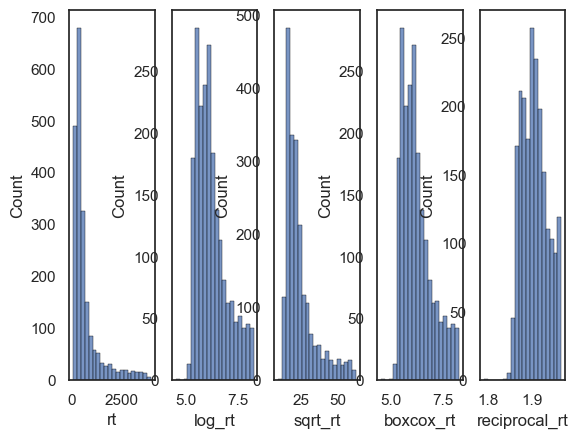

Figure saved at: C:/Users/audrey-annebeaudry/Desktop/Q1K_results/figures/rt_transformations_09_03_2025.png


In [310]:
fig, axs = plt.subplots(ncols=5)
sns.histplot(vs_grouped.rt,edgecolor='black', bins=20, ax=axs[0])
sns.histplot(vs_grouped.log_rt,edgecolor='black', bins=20, ax=axs[1])
sns.histplot(vs_grouped.sqrt_rt,edgecolor='black', bins=20, ax=axs[2])
sns.histplot(vs_grouped.boxcox_rt,edgecolor='black', bins=20, ax=axs[3])
sns.histplot(vs_grouped.reciprocal_rt,edgecolor='black', bins=20, ax=axs[4])
# Save the figure in doc folder and then doc 


# Define the correct save path
save_path = "C:/Users/audrey-annebeaudry/Desktop/Q1K_results/figures"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save the figure
fig_path = f"{save_path}/rt_transformations_{date}.png"
plt.savefig(fig_path)

# Show the figure
plt.show()

# Add the figure to a Word document
doc = docx.Document()
doc.add_heading('Transformations figure', level=4)

# Insert the image into the document
doc.add_picture(fig_path, width=docx.shared.Inches(6), height=docx.shared.Inches(4))

print(f"Figure saved at: {fig_path}")


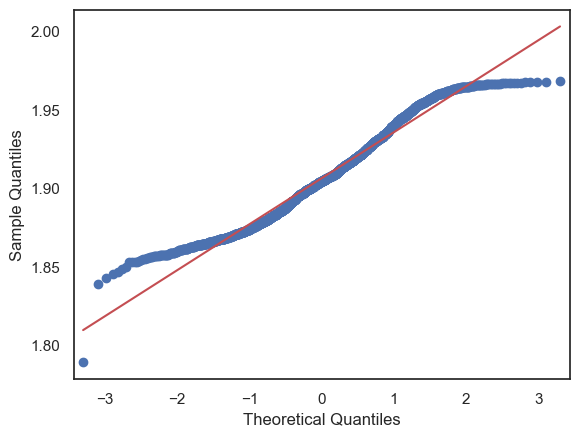

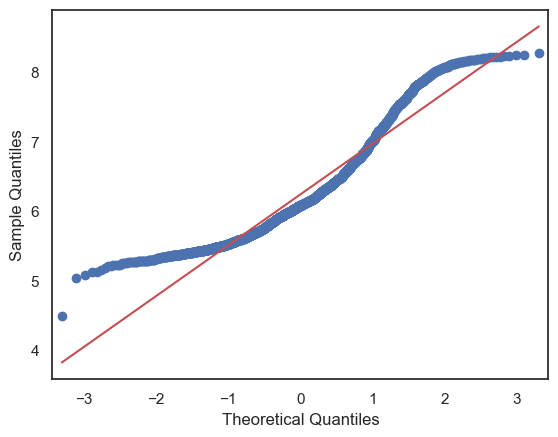

In [311]:
fig = sm.qqplot(vs_grouped.reciprocal_rt, line='s')

fig = sm.qqplot(vs_grouped.log_rt, line='s')

plt.show()

In [312]:
pg.normality(data=vs_grouped, dv='reciprocal_rt', group='condition')

W          pval  normal
condition                                
Nine       0.970298  3.367486e-11   False
Thirteen   0.976648  6.523014e-08   False
Five       0.964336  1.157263e-12   False

In [313]:
pg.normality(data=vs_grouped, dv='reciprocal_rt', group='detail')

W          pval  normal
detail                                     
Single       0.949924  2.504182e-17   False
Conjunction  0.980536  2.940038e-11   False

In [314]:
# Perform normality tests for each group and condition
results=[]

for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        subset = vs_grouped[(vs_grouped['diagnosis_group'] == group) & (vs_grouped['condition'] == condition)]
        test_result = pg.normality(subset['sqrt_rt'], method='shapiro')
        results.append({
            'diagnosis_group': group,
            'condition': condition,
            'p-value': test_result['pval'].values[0],
            'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
        })

results_df = pd.DataFrame(results)


results_df

diagnosis_group condition       p-value Normal
0         control      Nine  6.218462e-26     No
1         control  Thirteen  4.101608e-22     No
2         control      Five  2.234206e-22     No
3             asd      Nine  1.717648e-13     No
4             asd  Thirteen  1.050173e-12     No
5             asd      Five  7.072353e-11     No
6            adhd      Nine  1.670403e-10     No
7            adhd  Thirteen  1.474733e-08     No
8            adhd      Five  5.695620e-09     No

In [315]:
# Store results in a list
results = []

# Iterate over unique (asd, condition, DETAIL) combinations
for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        for detail in vs_grouped['detail'].unique():
            
            # Subset the data
            subset = vs_grouped[
                (vs_grouped['diagnosis_group'] == group) & 
                (vs_grouped['condition'] == condition) & 
                (vs_grouped['detail'] == detail)
            ]
            
            # Ensure the subset has enough data for normality testing
            if len(subset) > 2:  # Shapiro-Wilk requires at least 3 observations
                test_result = pg.normality(subset['reciprocal_rt'], method='shapiro')
                results.append({
                    'diagnosis_group': group,
                    'condition': condition,
                    'detail': detail,
                    'p-value': test_result['pval'].values[0],
                    'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
                })
            else:
                results.append({
                    'diagnosis_group': group,
                    'condition': condition,
                    'detail': detail,
                    'p-value': None,
                    'Normal': 'Insufficient Data'
                })

# Convert list of results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

diagnosis_group condition       detail       p-value Normal
0          control      Nine       Single  8.204204e-07     No
1          control      Nine  Conjunction  2.285486e-04     No
2          control  Thirteen       Single  8.485943e-10     No
3          control  Thirteen  Conjunction  2.074451e-03     No
4          control      Five       Single  1.693253e-06     No
5          control      Five  Conjunction  5.755262e-07     No
6              asd      Nine       Single  9.126163e-04     No
7              asd      Nine  Conjunction  2.690988e-01    Yes
8              asd  Thirteen       Single  1.056766e-04     No
9              asd  Thirteen  Conjunction  6.295943e-02    Yes
10             asd      Five       Single  2.514265e-02     No
11             asd      Five  Conjunction  1.917586e-03     No
12            adhd      Nine       Single  2.793484e-02     No
13            adhd      Nine  Conjunction  5.006222e-02    Yes
14            adhd  Thirteen       Single  1.302845e-01    Yes
15            adhd  Thirteen  Conjunction  2.036985e-06     No
16            adhd      Five       Single  7.380072e-01    Yes
17            adhd      Five  Conjunction  3.297339e-02     No

#### Assumption of sphericity (Mauchly’s test)

In [316]:
pg.sphericity(data=vs_grouped, dv='reciprocal_rt', subject='subject', within='condition', method='mauchly')

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


SpherResults(spher=True, W=inf, chi2=-inf, dof=2, pval=1.0)

In [317]:
# Add to doc 
if pg.sphericity(data=vs_grouped, dv='reciprocal_rt', subject='subject', within='condition')[-1] < 0.05:
    p16= "Assumption of sphericity is violated : " + str(pg.sphericity(data=vs_grouped, dv='reciprocal_rt', subject='subject', within='condition')[-1].round(4))
    print(p16)
    # Add to doc 
    doc.add_paragraph(p16, style='List Bullet')
else:
    print("Assumption of sphericity is met")
    doc.add_paragraph("Assumption of sphericity is met", style='List Bullet')


Assumption of sphericity is met


/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


#### Assumptions of Levenes test

In [318]:
# Calculte levels test assumptions 
pg.homoscedasticity(data=vs_grouped, dv='reciprocal_rt', group='diagnosis_group', method='levene')

W      pval  equal_var
levene  2.006608  0.134704       True

In [319]:
# Run the repeated measures ANOVA for condition
res_condition = pg.rm_anova(dv="reciprocal_rt", within="condition", subject="subject", data=vs_grouped).round(4)

# Show the results
res_condition

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2        F  p-unc     ng2     eps
0  condition      2    206  11.2245    0.0  0.0193  0.9697

In [320]:
# Run the repeated measures ANOVA for condition
res_condition = pg.rm_anova(dv="reciprocal_rt", within="detail", subject="subject", data=vs_grouped)

# Show the results
res_condition

Source  ddof1  ddof2         F         p-unc       ng2  eps
0  detail      1    103  73.32678  1.135246e-13  0.054383  1.0

In [321]:
anova_results = pg.rm_anova(
    data=vs_grouped, 
    dv="reciprocal_rt", 
    subject="subject",
    within=["condition", "detail"], 
    detailed=True
)

anova_results

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


Source        SS  ddof1  ddof2        MS          F  \
0           condition  0.004839      2    186  0.002419  12.752019   
1              detail  0.014883      1     93  0.014883  78.688633   
2  condition * detail  0.007251      2    186  0.003625  25.110014   

          p-unc     p-GG-corr       ng2       eps  
0  6.457554e-06  8.552597e-06  0.020654  0.968364  
1  5.008104e-14  5.008104e-14  0.060918  1.000000  
2  2.219470e-10  3.313575e-10  0.030635  0.978485

In [322]:
#### One-way measures ANOVA for detail
res = pg.mixed_anova(dv="reciprocal_rt", within="detail", between="diagnosis_group", subject="subject", data=vs_grouped).round(4)
res

Source      SS  DF1  DF2      MS        F   p-unc     np2  eps
0  diagnosis_group  0.0008    2  101  0.0004   0.5611  0.5724  0.0110  NaN
1           detail  0.0044    1  101  0.0044  74.1209  0.0000  0.4233  1.0
2      Interaction  0.0002    2  101  0.0001   1.5577  0.2156  0.0299  NaN

In [323]:
### One-way measures ANOVA for detail
res = pg.mixed_anova(dv="reciprocal_rt", within="condition", between="diagnosis_group", subject="subject", data=vs_grouped).round(4)
res

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


Source      SS  DF1  DF2      MS        F   p-unc     np2     eps
0  diagnosis_group  0.0014    2  101  0.0007   0.7345  0.4823  0.0143     NaN
1        condition  0.0023    2  202  0.0012  11.1752  0.0000  0.0996  0.9697
2      Interaction  0.0003    4  202  0.0001   0.7738  0.5434  0.0151     NaN

In [324]:
post_hocs = pg.pairwise_tests(dv='reciprocal_rt', within=['condition', 'detail'],
                               subject='subject', between = 'diagnosis_group', padjust='fdr_bh', data=vs_grouped).round(5)
post_hocs

Contrast condition            A         B Paired Parametric  \
0           condition         -         Five      Nine   True       True   
1           condition         -         Five  Thirteen   True       True   
2           condition         -         Nine  Thirteen   True       True   
3              detail         -  Conjunction    Single   True       True   
4  condition * detail      Five  Conjunction    Single   True       True   
5  condition * detail      Nine  Conjunction    Single   True       True   
6  condition * detail  Thirteen  Conjunction    Single   True       True   

         T   dof alternative    p-unc   p-corr p-adjust       BF10   hedges  
0  4.41176  93.0   two-sided  0.00003  0.00008   fdr_bh    623.013  0.31601  
1  4.18782  93.0   two-sided  0.00006  0.00010   fdr_bh    284.571  0.34727  
2  0.38994  93.0   two-sided  0.69747  0.69747   fdr_bh      0.123  0.03055  
3  8.87066  93.0   two-sided  0.00000      NaN      NaN  1.441e+11  0.59097  
4  0.98956  93.0   two-sided  0.32496  0.32496   fdr_bh      0.183  0.07641  
5  5.31438  93.0   two-sided  0.00000  0.00000   fdr_bh  1.891e+04  0.50345  
6  9.72243  93.0   two-sided  0.00000  0.00000   fdr_bh  8.098e+12  0.97106

In [325]:
## Group control and detail

vs_grouped['cond_det'] = vs_grouped['condition']+ '_' +vs_grouped['detail']

In [326]:
vs_grouped

subject condition       detail   rt  \
0     1009S1      Nine       Single  344   
1     1009S1  Thirteen       Single  244   
2     1009S1      Nine       Single  197   
3     1009S1      Five  Conjunction  311   
4     1009S1      Five  Conjunction  235   
...      ...       ...          ...  ...   
2077  1121M1      Five  Conjunction  282   
2078  1121M1      Nine  Conjunction  237   
2079  1121M1      Nine  Conjunction  170   
2080  1121M1  Thirteen  Conjunction  258   
2081  1121M1  Thirteen  Conjunction  227   

                                   vs_location_list diagnosis_group     sex  \
0                   (1, 15, 2, 10, 6, 11, 7, 4, 16)         control  female   
1     (3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)         control  female   
2                   (3, 10, 0, 13, 9, 16, 14, 5, 7)         control  female   
3                                 (8, 9, 10, 15, 1)         control  female   
4                                  (11, 5, 8, 6, 0)         control  female   
...                                             ...             ...     ...   
2077                               (5, 9, 4, 15, 6)         control  female   
2078               (3, 12, 1, 6, 2, 11, 15, 16, 10)         control  female   
2079                  (0, 3, 11, 13, 7, 8, 5, 1, 6)         control  female   
2080  (6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)         control  female   
2081  (7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)         control  female   

            age  n_trials site age_group    log_rt    sqrt_rt  reciprocal_rt  \
0     13.571805        23  hsj     child  5.840642  18.547237       1.892167   
1     13.571805        23  hsj     child  5.497168  15.620499       1.871963   
2     13.571805        23  hsj     child  5.283204  14.035669       1.857506   
3     13.571805        23  hsj     child  5.739793  17.635192       1.886590   
4     13.571805        23  hsj     child  5.459586  15.329710       1.869534   
...         ...       ...  ...       ...       ...        ...            ...   
2077  39.225994        23  hsj     adult  5.641907  16.792856       1.880902   
2078  39.225994        23  hsj     adult  5.468060  15.394804       1.870086   
2079  39.225994        23  hsj     adult  5.135798  13.038405       1.846607   
2080  39.225994        23  hsj     adult  5.552960  16.062378       1.875485   
2081  39.225994        23  hsj     adult  5.424950  15.066519       1.867255   

      boxcox_rt              cond_det  
0      5.840812           Nine_Single  
1      5.497319       Thirteen_Single  
2      5.283343           Nine_Single  
3      5.739958      Five_Conjunction  
4      5.459735      Five_Conjunction  
...         ...                   ...  
2077   5.642066      Five_Conjunction  
2078   5.468210      Nine_Conjunction  
2079   5.135930      Nine_Conjunction  
2080   5.553114  Thirteen_Conjunction  
2081   5.425097  Thirteen_Conjunction  

[2082 rows x 16 columns]

In [327]:
post_hocs = pg.pairwise_tests(dv='reciprocal_rt', within='cond_det',
                               subject='subject', between='diagnosis_group', padjust='fdr_bh', data=vs_grouped).round(5)
post_hocs

Contrast              cond_det                     A  \
0                     cond_det                     -      Five_Conjunction   
1                     cond_det                     -      Five_Conjunction   
2                     cond_det                     -      Five_Conjunction   
3                     cond_det                     -      Five_Conjunction   
4                     cond_det                     -      Five_Conjunction   
5                     cond_det                     -           Five_Single   
6                     cond_det                     -           Five_Single   
7                     cond_det                     -           Five_Single   
8                     cond_det                     -           Five_Single   
9                     cond_det                     -      Nine_Conjunction   
10                    cond_det                     -      Nine_Conjunction   
11                    cond_det                     -      Nine_Conjunction   
12                    cond_det                     -           Nine_Single   
13                    cond_det                     -           Nine_Single   
14                    cond_det                     -  Thirteen_Conjunction   
15             diagnosis_group                     -                  adhd   
16             diagnosis_group                     -                  adhd   
17             diagnosis_group                     -                   asd   
18  cond_det * diagnosis_group      Five_Conjunction                  adhd   
19  cond_det * diagnosis_group      Five_Conjunction                  adhd   
20  cond_det * diagnosis_group      Five_Conjunction                   asd   
21  cond_det * diagnosis_group           Five_Single                  adhd   
22  cond_det * diagnosis_group           Five_Single                  adhd   
23  cond_det * diagnosis_group           Five_Single                   asd   
24  cond_det * diagnosis_group      Nine_Conjunction                  adhd   
25  cond_det * diagnosis_group      Nine_Conjunction                  adhd   
26  cond_det * diagnosis_group      Nine_Conjunction                   asd   
27  cond_det * diagnosis_group           Nine_Single                  adhd   
28  cond_det * diagnosis_group           Nine_Single                  adhd   
29  cond_det * diagnosis_group           Nine_Single                   asd   
30  cond_det * diagnosis_group  Thirteen_Conjunction                  adhd   
31  cond_det * diagnosis_group  Thirteen_Conjunction                  adhd   
32  cond_det * diagnosis_group  Thirteen_Conjunction                   asd   
33  cond_det * diagnosis_group       Thirteen_Single                  adhd   
34  cond_det * diagnosis_group       Thirteen_Single                  adhd   
35  cond_det * diagnosis_group       Thirteen_Single                   asd   

                       B Paired Parametric        T       dof alternative  \
0            Five_Single   True       True  0.98956  93.00000   two-sided   
1       Nine_Conjunction   True       True  1.10906  93.00000   two-sided   
2            Nine_Single   True       True  6.23271  93.00000   two-sided   
3   Thirteen_Conjunction   True       True -1.29401  93.00000   two-sided   
4        Thirteen_Single   True       True  8.14841  93.00000   two-sided   
5       Nine_Conjunction   True       True  0.06250  93.00000   two-sided   
6            Nine_Single   True       True  5.08156  93.00000   two-sided   
7   Thirteen_Conjunction   True       True -2.08970  93.00000   two-sided   
8        Thirteen_Single   True       True  6.75894  93.00000   two-sided   
9            Nine_Single   True       True  5.31438  93.00000   two-sided   
10  Thirteen_Conjunction   True       True -2.50413  93.00000   two-sided   
11       Thirteen_Single   True       True  7.00740  93.00000   two-sided   
12  Thirteen_Conjunction   True       True -7.34877  93.00000   two-sided   
13       Thirteen_Single   True       True  2.58843  93.0

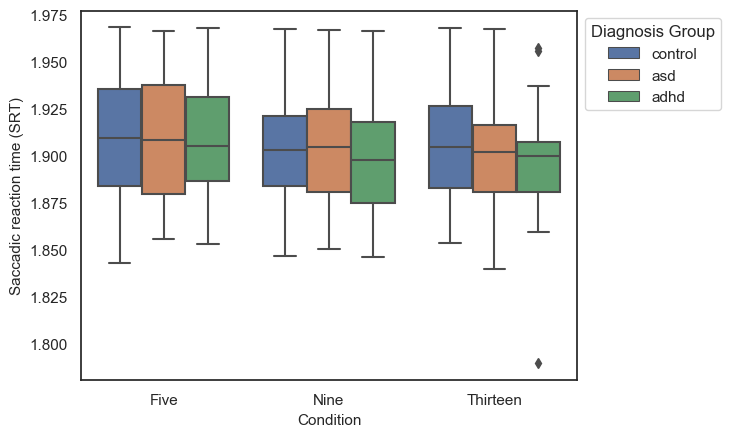

In [328]:
sns.set_theme(style='white')
order = ["Five", "Nine", "Thirteen"]
ax=sns.boxplot(x="condition", y="reciprocal_rt",hue = 'diagnosis_group', data=vs_grouped,order=order )#,estimator=np.mean, ci = 0.95, capsize=.2,
            #palette="coolwarm").set_title("",fontsize=18)

plt.grid(False)
plt.ylabel('Saccadic reaction time (SRT)',fontsize=11)
plt.xlabel('Condition',fontsize=11)
plt.legend(loc='upper right')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Diagnosis Group')

# Show the figure
plt.show()



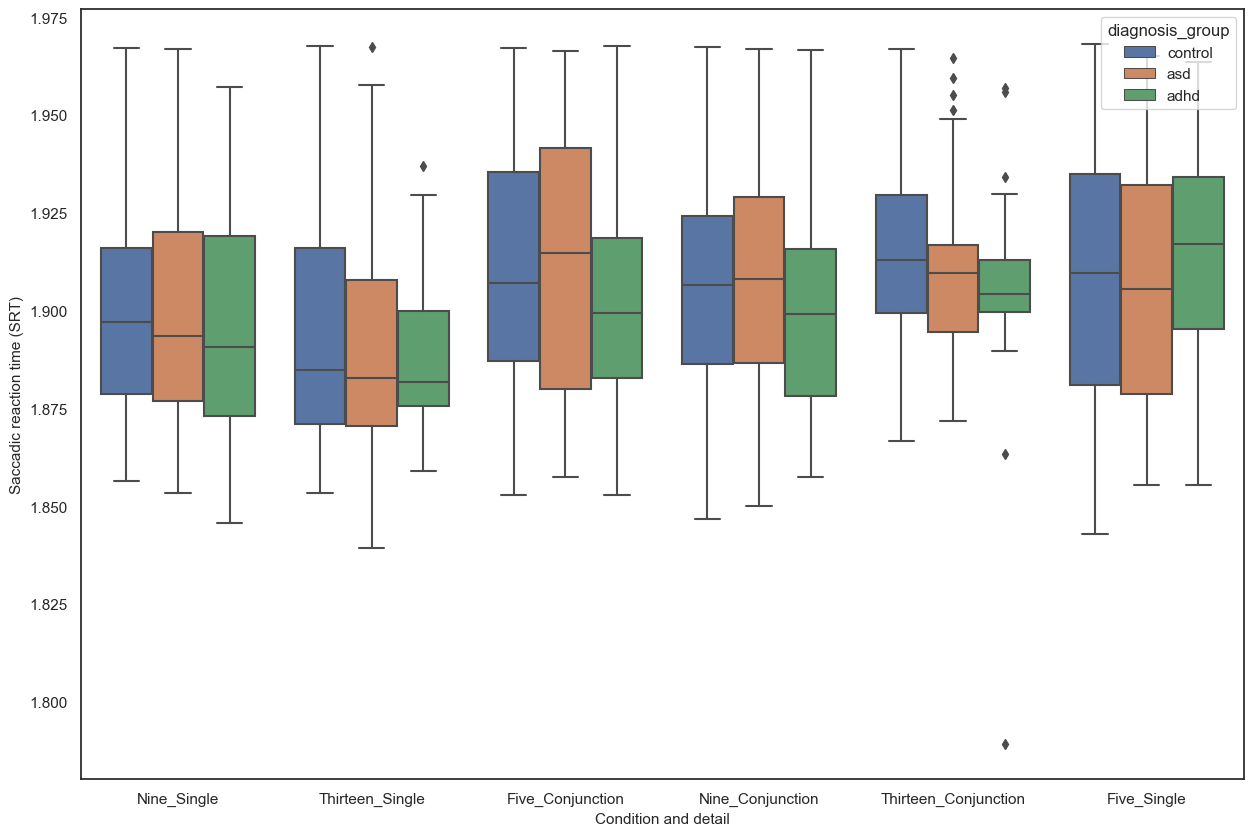

In [329]:
plt.figure(figsize= (15, 10))
# Set theme

sns.set_theme(style='white')

# Define order
#order = ["Five", "Nine", "Thirteen"]
#detail_order = ['Conjunction', 'Single_Slice', 'Single_Apple']

# Create boxplot with detail as hue
ax = sns.boxplot(x="cond_det", y="reciprocal_rt", hue="diagnosis_group", 
                 data=vs_grouped)

# Adjust labels and grid
plt.grid(False)
plt.ylabel('Saccadic reaction time (SRT)', fontsize=11)
plt.xlabel('Condition and detail', fontsize=11)

# Add legend
plt.legend(title="diagnosis_group", loc='upper right')

# Show plot
plt.show()



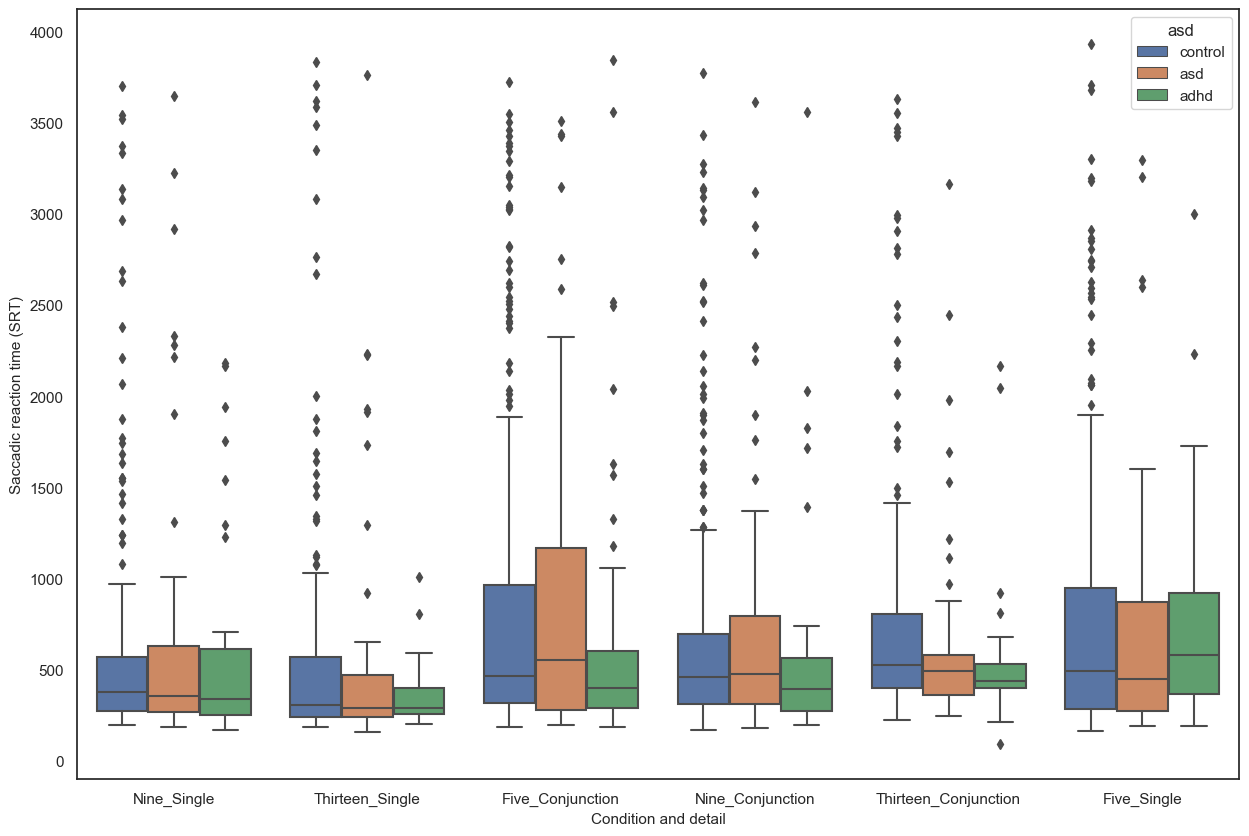

In [330]:
plt.figure(figsize= (15, 10))
# Set theme

sns.set_theme(style='white')

# Define order
#order = ["Five", "Nine", "Thirteen"]
#detail_order = ['Conjunction', 'Single_Slice', 'Single_Apple']

# Create boxplot with detail as hue
ax = sns.boxplot(x="cond_det", y="rt", hue="diagnosis_group", 
                 data=vs_grouped)

# Adjust labels and grid
plt.grid(False)
plt.ylabel('Saccadic reaction time (SRT)', fontsize=11)
plt.xlabel('Condition and detail', fontsize=11)

# Add legend
plt.legend(title="asd", loc='upper right')

# Show plot
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


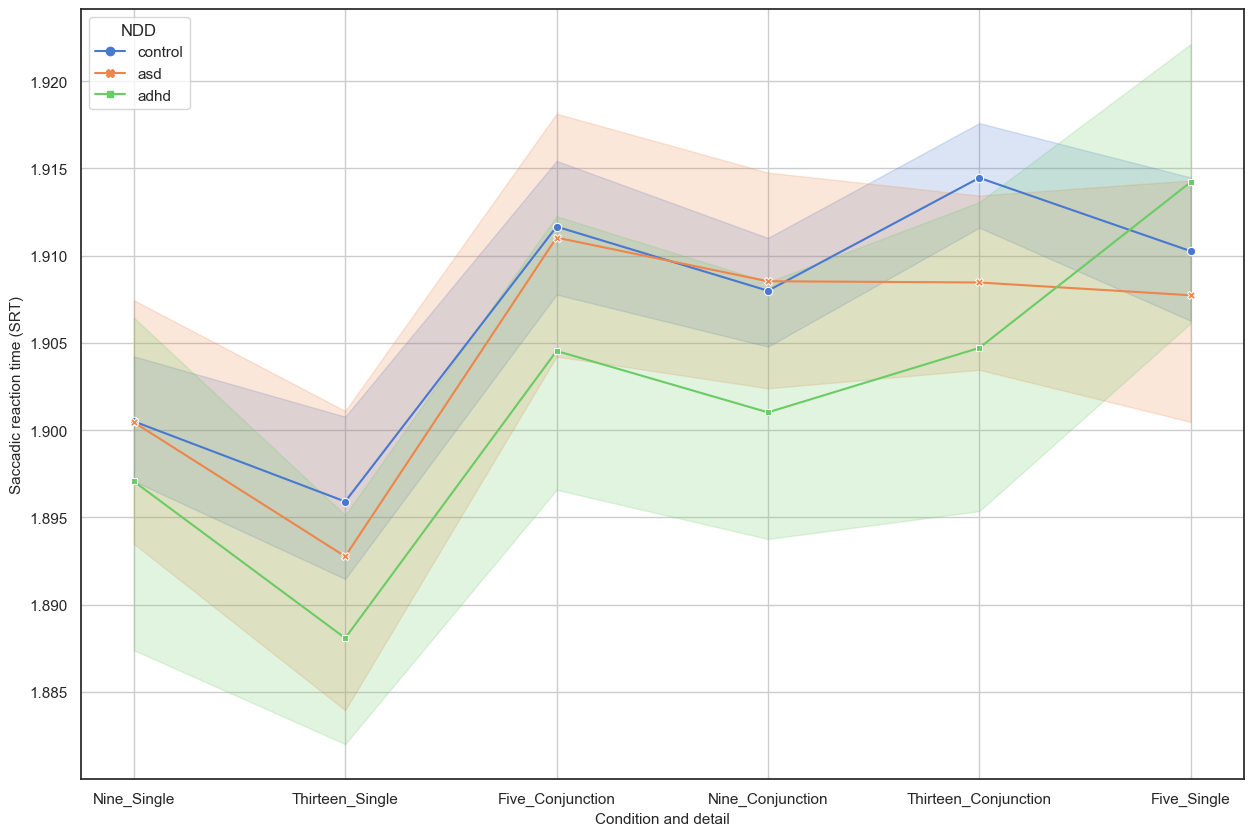

In [331]:
plt.figure(figsize = (15, 10))
# Set theme
sns.set_theme(style='white')

# Define order for condition
#order = ["Five", "Nine", "Thirteen"]

# Create lineplot with 'detail' as hue and 'asd' as style
ax = sns.lineplot(x="cond_det", y="reciprocal_rt", 
                  hue="diagnosis_group", style="diagnosis_group",
                  data=vs_grouped, 
                  markers=True, dashes=False, 
                  palette="muted") 
                  #hue_order=["Conjunction", "Single_Slice", "Single_Apple"])

# Adjust labels and grid
plt.grid(True)
plt.ylabel('Saccadic reaction time (SRT)', fontsize=11)
plt.xlabel('Condition and detail', fontsize=11)

# Add legend
plt.legend(title="NDD", loc='upper left')

# Show plot
plt.show()

## Exploratory analyses

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

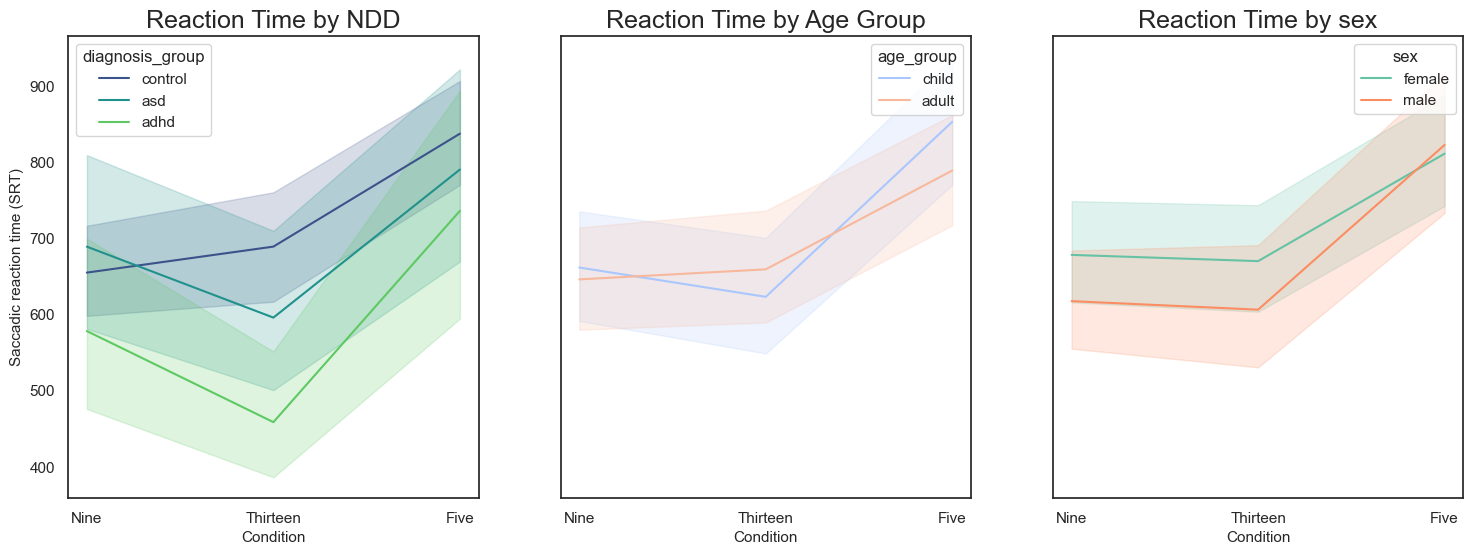

In [332]:
# Make thre pltos for reaction times for each sex and age group
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set_theme(style="white")

order = ["Five", "Nine","Thirteen"]
sns.lineplot(x="condition", y="rt", data=vs_grouped,hue = "diagnosis_group", ax=ax[0], #this is normal rt, can be done with reciprecal_rt; can also be done with detail instead of condition
            palette="viridis").set_title("",fontsize=18)

sns.lineplot(x="condition", y="rt", data=vs_grouped,hue ="age_group", ax=ax[1],
            palette="coolwarm").set_title("",fontsize=18)

sns.lineplot(x="condition", y="rt", data=vs_grouped,hue= "sex", ax=ax[2],
            palette="Set2").set_title("",fontsize=18)


# Add titles to the plots
ax[0].set_title('Reaction Time by NDD',fontsize=18)
ax[1].set_title('Reaction Time by Age Group',fontsize=18)
ax[2].set_title('Reaction Time by sex',fontsize=18)

# Add labels to the plots
ax[0].set_ylabel('Saccadic reaction time (SRT)',fontsize=11)
ax[0].set_xlabel('Condition',fontsize=11)


ax[1].set_ylabel('Saccadic reaction time (SRT)',fontsize=11)
ax[1].set_xlabel('Condition',fontsize=11)

ax[2].set_ylabel('Saccadic reaction time (SRT)',fontsize=11)
ax[2].set_xlabel('Condition',fontsize=11)


# Show the figure
plt.show()



### Linear model analysis 

In [333]:
# Add logrt to the df

rt_sub["reciprocal_rt"] = boxcox(rt_sub.rt,-0.5)

In [334]:
rt_sub['cond_det'] = rt_sub['condition']+'_'+rt_sub['detail']

In [335]:
vs_dis=rt_sub[["subject","cond_det", "condition", "detail", "reciprocal_rt", "rt", "vs_location_list"]]

In [336]:
vs_dis=vs_dis.groupby(["subject","cond_det", "condition", "detail", "vs_location_list"]).mean().reset_index()

In [337]:
vs_grouped= vs_dis


In [338]:
## Add demographic back to vs_grouped
vs_grouped=pd.merge(vs_grouped, outlier_demo, on="subject", how="inner")

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


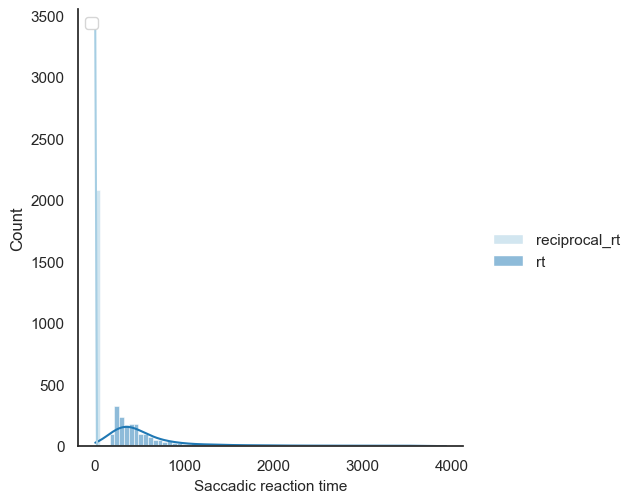

In [339]:
sns.displot(data=vs_dis, palette="Paired", kde=True)
plt.xlabel('Saccadic reaction time',fontsize=11)
plt.legend(loc='upper left')

In [340]:
# Add a column with total number of trrials and one for overall RT
rt_sub["total_trials"]=rt_sub.groupby("subject")["rt"].transform("count")
rt_sub["overall_rt"]=rt_sub.groupby("subject")["rt"].transform("mean")
rt_sub
#reaction time get longer with fatigue , drop is different for adhd ...

index subject Trial_Index_ condition       detail   rt VS_VALID  \
1         1  1009S1            2      Nine       Single  344     True   
2         2  1009S1            3  Thirteen       Single  244     True   
4         4  1009S1            5      Nine       Single  197     True   
6         6  1009S1            7      Five  Conjunction  311     True   
7         7  1009S1            8      Five  Conjunction  235     True   
...     ...     ...          ...       ...          ...  ...      ...   
2733   3202  1121M1           24      Five  Conjunction  282     True   
2734   3203  1121M1           25      Nine  Conjunction  237     True   
2735   3204  1121M1           26      Nine  Conjunction  170     True   
2738   3207  1121M1           29  Thirteen  Conjunction  258     True   
2739   3208  1121M1           30  Thirteen  Conjunction  227     True   

                                   vs_location_list        age    group  ...  \
1                   (1, 15, 2, 10, 6, 11, 7, 4, 16)  13.571805  sibling  ...   
2     (3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)  13.571805  sibling  ...   
4                   (3, 10, 0, 13, 9, 16, 14, 5, 7)  13.571805  sibling  ...   
6                                 (8, 9, 10, 15, 1)  13.571805  sibling  ...   
7                                  (11, 5, 8, 6, 0)  13.571805  sibling  ...   
...                                             ...        ...      ...  ...   
2733                               (5, 9, 4, 15, 6)  39.225994   mother  ...   
2734               (3, 12, 1, 6, 2, 11, 15, 16, 10)  39.225994   mother  ...   
2735                  (0, 3, 11, 13, 7, 8, 5, 1, 6)  39.225994   mother  ...   
2738  (6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)  39.225994   mother  ...   
2739  (7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)  39.225994   mother  ...   

         sex      asd adhd record_id age_group diagnosis_group reciprocal_rt  \
1     female  control    0  525-1011     child         control      1.892167   
2     female  control    0  525-1011     child         control      1.871963   
4     female  control    0  525-1011     child         control      1.857506   
6     female  control    0  525-1011     child         control      1.886590   
7     female  control    0  525-1011     child         control      1.869534   
...      ...      ...  ...       ...       ...             ...           ...   
2733  female  control    0  525-1123     adult         control      1.880902   
2734  female  control    0  525-1123     adult         control      1.870086   
2735  female  control    0  525-1123     adult         control      1.846607   
2738  female  control    0  525-1123     adult         control      1.875485   
2739  female  control    0  525-1123     adult         control      1.867255   

                  cond_det total_trials  overall_rt  
1              Nine_Single           23  270.304348  
2          Thirteen_Single           23  270.304348  
4              Nine_Single           23  270.304348  
6         Five_Conjunction           23  270.304348  
7         Five_Conjunction           23  270.304348  
...                    ...          ...         ...  
2733      Five_Conjunction           23  439.826087  
2734      Nine_Conjunction           23  439.826087  
2735      Nine_Conjunction           23  439.826087  
2738  Thirteen_Conjunction           23  439.826087  
2739  Thirteen_Conjunction           23  439.826087  

[2082 rows x 21 columns]

In [341]:
# Merge df wih demogroupic data
rt_sub[["subject", "total_trials", "overall_rt", "diagnosis_group", "site", "sex","age", "age_group", "condition", "detail", "cond_det"]].drop_duplicates()

subject  total_trials  overall_rt diagnosis_group site     sex  \
1     1009S1            23  270.304348         control  hsj  female   
2     1009S1            23  270.304348         control  hsj  female   
6     1009S1            23  270.304348         control  hsj  female   
9     1009S1            23  270.304348         control  hsj  female   
12    1009S1            23  270.304348         control  hsj  female   
...      ...           ...         ...             ...  ...     ...   
2711  1121M1            23  439.826087         control  hsj  female   
2712  1121M1            23  439.826087         control  hsj  female   
2716  1121M1            23  439.826087         control  hsj  female   
2719  1121M1            23  439.826087         control  hsj  female   
2723  1121M1            23  439.826087         control  hsj  female   

            age age_group condition       detail              cond_det  
1     13.571805     child      Nine       Single           Nine_Single  
2     13.571805     child  Thirteen       Single       Thirteen_Single  
6     13.571805     child      Five  Conjunction      Five_Conjunction  
9     13.571805     child      Nine  Conjunction      Nine_Conjunction  
12    13.571805     child  Thirteen  Conjunction  Thirteen_Conjunction  
...         ...       ...       ...          ...                   ...  
2711  39.225994     adult      Nine       Single           Nine_Single  
2712  39.225994     adult  Thirteen       Single       Thirteen_Single  
2716  39.225994     adult      Five  Conjunction      Five_Conjunction  
2719  39.225994     adult      Nine  Conjunction      Nine_Conjunction  
2723  39.225994     adult  Thirteen  Conjunction  Thirteen_Conjunction  

[610 rows x 11 columns]

In [342]:
# 
rt_demo = rt_sub[["subject", "total_trials", "overall_rt", "diagnosis_group", "site", "sex","age", "age_group"]].drop_duplicates()

# Mixed effects linear modelling

## FUNCTIONS for linear models 

In [343]:
def coefplot_gap(results, multiple_models=False, fig_name=None):
    '''
    Creates a coefficient plot with confidence intervals.
   
    Parameters:
    results : statsmodels results object or DataFrame
        If multiple_models=False: statsmodels results object
        If multiple_models=True: DataFrame with columns: index, model, Coef., [0.025, P>|z|
    multiple_models : bool, default False
        Whether to create a plot for multiple models or single model
   
    Returns:
        matplotlib plot
    '''
    # Create/process dataframe based on input type
    if not multiple_models:
        coef_df = pd.DataFrame(results.summary().tables[1]).reset_index()
    else:
        coef_df = results.copy()
   
    # Drop unwanted rows
    coef_df = coef_df.loc[coef_df["index"].isin(['Group Var', 'Intercept']) == False]
   
    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
   
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']
   
    # Create significance indicators - make them consistent between both cases
    if multiple_models:
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    else:
        # Changed to match the multiple models case
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
   
    # Clean up Treatment variable names
    for var_name in coef_df['index'].unique():
        if "Treatment" in var_name:
            if ":" in var_name:
                var1 = var_name.split("[",1)[1].split("]")[0]
                var2 = var_name.split("[", 2)[-1]
                new_var_name = var1 + ":" + var2
            else:
                new_var_name = var_name.split("[", 1)[1].split("]")[0]
            coef_df['index'] = coef_df['index'].replace(var_name, new_var_name)
   
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 10))
   
    # Define consistent marker styles
    marker_styles = {'Significant': 'X', 'Not Significant': 'o'}
   

    if multiple_models:
        # Get models and calculate positions
        models = coef_df['model'].unique()
        variables = coef_df['index'].unique()
        n_models = len(models)
        space_between = 2.5
        model_spacing = 1.0
       
        # Create position mapping
        positions = {}
        # Sort variables by their average coefficient value (lowest to highest)
        var_means = coef_df.groupby('index')['Coef.'].mean().sort_values()
        sorted_vars = var_means.index
       
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            for j, model in enumerate(models):
                positions[(var, model)] = base_pos + (j * model_spacing)
       
        # Add plot positions
        coef_df['plot_position'] = coef_df.apply(
            lambda row: positions[(row['index'], row['model'])],
            axis=1
        )
       
        # Set up colors for multiple models
        model_palette = sns.color_palette("husl", n_colors=len(models))
        model_colors = dict(zip(models, model_palette))
       
        # Plot error bars
        for model in models:
            model_data = coef_df[coef_df['model'] == model]
            plt.errorbar(x=model_data['Coef.'],
                        y=model_data['plot_position'],
                        xerr=model_data['errors'],
                        color=model_colors[model],
                        capsize=3,
                        fmt='none',
                        alpha=0.7,
                        zorder=1)
       
        # Plot points
        g = sns.scatterplot(data=coef_df,
                           x='Coef.',
                           y='plot_position',
                           hue='model',
                           style='Significance',
                           markers=marker_styles,
                           palette=model_colors,
                           s=200,
                           zorder=3,
                           ax=ax)
       
        # Set y-ticks
        tick_positions = []
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            middle_pos = base_pos + ((n_models - 1) * model_spacing) / 2
            tick_positions.append(middle_pos)
       
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(sorted_vars)
       
        # Create legends
        g.legend_.remove()
       
        # Model legend
        model_legend = ax.legend(
            title='Models',
            handles=[plt.Line2D([], [], marker='o', color=color, linestyle='None',
                               markersize=10, label=model)
                    for model, color in model_colors.items()],
            bbox_to_anchor=(1.02, 1),
            loc='upper left'
        )
       
        # Significance legend
        significance_handles = [
            plt.Line2D([], [], marker='X', color='gray', linestyle='None',
                      markersize=10, label='Significant'),
            plt.Line2D([], [], marker='o', color='gray', linestyle='None',
                      markersize=10, label='Not Significant')
        ]
       
        ax.add_artist(model_legend)
        ax.legend(handles=significance_handles,
                 title='Significance',
                 bbox_to_anchor=(1.02, 0.6),
                 loc='upper left')
       
    else:
        # Sort the dataframe by coefficient values (lowest to highest)
        coef_df = coef_df.sort_values(by='Coef.', ascending=False)
       
        # Single model plot
        palette = sns.color_palette("Set1")
        color_map = {'Significant': palette[0], 'Not Significant': palette[1]}
       
        # Error bars
        for idx, row in coef_df.iterrows():
            error_color = color_map[row['Significance']]
            plt.errorbar(x=row['Coef.'],
                        y=row['index'],
                        xerr=row['errors'],
                        color=error_color,
                        capsize=3,
                        fmt='none',
                        zorder=1)
       
        # Scatter plot with consistent markers
        g = sns.scatterplot(y='index',
                           x='Coef.',
                           style='Significance',
                           hue='Significance',
                           markers=marker_styles,
                           palette=color_map,
                           s=200,
                           data=coef_df,
                           zorder=3,
                           ax=ax)
   
    # Common plot elements
    ax.axvline(x=0, linestyle='--', color='red', linewidth=1)
   
    # Set title & labels
    title = 'Coefficients Across Models w/ 95% Confidence Intervals' if multiple_models else 'Coefficients of Features w/ 95% Confidence Intervals'
    plt.title(title, fontsize=30)
    ax.set_ylabel('Variables' if multiple_models else 'Coefficients', fontsize=22)
    ax.set_xlabel('Coefficient Value' if multiple_models else '', fontsize=22)
   
    # Set x-axis limits
    ax.set_xlim(coef_df['Coef.'].min() - max(coef_df['errors']),
                coef_df['Coef.'].max() + max(coef_df['errors']))
   
    plt.tight_layout()

        # Add to the document
   
    if multiple_models:
        doc.add_paragraph('Multiple models coefficient plot', style='List Bullet')
    else:

         doc.add_paragraph('Mixed effects model results', style='List Bullet')

    
    # Save the plot
    #plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/Q1K_neurosubs_2025/results/gap/figures/mixed_effects_model_{fig_name}_{date}.png")

    plt.show()
    return plt.show()

In [344]:
def coefplot_gap(results, multiple_models=False, fig_name=None):
    '''
    Creates a coefficient plot with confidence intervals.
   
    Parameters:
    results : statsmodels results object or DataFrame
        If multiple_models=False: statsmodels results object
        If multiple_models=True: DataFrame with columns: index, model, Coef., [0.025, P>|z|
    multiple_models : bool, default False
        Whether to create a plot for multiple models or single model
   
    Returns:
        matplotlib plot
    '''
    # Create/process dataframe based on input type
    if not multiple_models:
        coef_df = pd.DataFrame(results.summary().tables[1]).reset_index()
    else:
        coef_df = results.copy()
   
    # Drop unwanted rows
    coef_df = coef_df.loc[coef_df["index"].isin(['Group Var', 'Intercept']) == False]
   
    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
   
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']
   
    # Create significance indicators - make them consistent between both cases
    if multiple_models:
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    else:
        # Changed to match the multiple models case
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
   
    # Clean up Treatment variable names
    for var_name in coef_df['index'].unique():
        if "Treatment" in var_name:
            if ":" in var_name:
                var1 = var_name.split("[",1)[1].split("]")[0]
                var2 = var_name.split("[", 2)[-1]
                new_var_name = var1 + ":" + var2
            else:
                new_var_name = var_name.split("[", 1)[1].split("]")[0]
            coef_df['index'] = coef_df['index'].replace(var_name, new_var_name)
   
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 10))
   
    # Define consistent marker styles
    marker_styles = {'Significant': 'X', 'Not Significant': 'o'}
   

    if multiple_models:
        # Get models and calculate positions
        models = coef_df['model'].unique()
        variables = coef_df['index'].unique()
        n_models = len(models)
        space_between = 2.5
        model_spacing = 1.0
       
        # Create position mapping
        positions = {}
        # Sort variables by their average coefficient value (lowest to highest)
        var_means = coef_df.groupby('index')['Coef.'].mean().sort_values()
        sorted_vars = var_means.index
       
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            for j, model in enumerate(models):
                positions[(var, model)] = base_pos + (j * model_spacing)
       
        # Add plot positions
        coef_df['plot_position'] = coef_df.apply(
            lambda row: positions[(row['index'], row['model'])],
            axis=1
        )
       
        # Set up colors for multiple models
        model_palette = sns.color_palette("husl", n_colors=len(models))
        model_colors = dict(zip(models, model_palette))
       
        # Plot error bars
        for model in models:
            model_data = coef_df[coef_df['model'] == model]
            plt.errorbar(x=model_data['Coef.'],
                        y=model_data['plot_position'],
                        xerr=model_data['errors'],
                        color=model_colors[model],
                        capsize=3,
                        fmt='none',
                        alpha=0.7,
                        zorder=1)
       
        # Plot points
        g = sns.scatterplot(data=coef_df,
                           x='Coef.',
                           y='plot_position',
                           hue='model',
                           style='Significance',
                           markers=marker_styles,
                           palette=model_colors,
                           s=200,
                           zorder=3,
                           ax=ax)
       
        # Set y-ticks
        tick_positions = []
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            middle_pos = base_pos + ((n_models - 1) * model_spacing) / 2
            tick_positions.append(middle_pos)
       
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(sorted_vars)
       
        # Create legends
        g.legend_.remove()
       
        # Model legend
        model_legend = ax.legend(
            title='Models',
            handles=[plt.Line2D([], [], marker='o', color=color, linestyle='None',
                               markersize=10, label=model)
                    for model, color in model_colors.items()],
            bbox_to_anchor=(1.02, 1),
            loc='upper left'
        )
       
        # Significance legend
        significance_handles = [
            plt.Line2D([], [], marker='X', color='gray', linestyle='None',
                      markersize=10, label='Significant'),
            plt.Line2D([], [], marker='o', color='gray', linestyle='None',
                      markersize=10, label='Not Significant')
        ]
       
        ax.add_artist(model_legend)
        ax.legend(handles=significance_handles,
                 title='Significance',
                 bbox_to_anchor=(1.02, 0.6),
                 loc='upper left')
       
    else:
        # Sort the dataframe by coefficient values (lowest to highest)
        coef_df = coef_df.sort_values(by='Coef.', ascending=False)
       
        # Single model plot
        palette = sns.color_palette("Set1")
        color_map = {'Significant': palette[0], 'Not Significant': palette[1]}
       
        # Error bars
        for idx, row in coef_df.iterrows():
            error_color = color_map[row['Significance']]
            plt.errorbar(x=row['Coef.'],
                        y=row['index'],
                        xerr=row['errors'],
                        color=error_color,
                        capsize=3,
                        fmt='none',
                        zorder=1)
       
        # Scatter plot with consistent markers
        g = sns.scatterplot(y='index',
                           x='Coef.',
                           style='Significance',
                           hue='Significance',
                           markers=marker_styles,
                           palette=color_map,
                           s=200,
                           data=coef_df,
                           zorder=3,
                           ax=ax)
   
    # Common plot elements
    ax.axvline(x=0, linestyle='--', color='red', linewidth=1)
   
    # Set title & labels
    title = 'Coefficients Across Models w/ 95% Confidence Intervals' if multiple_models else 'Coefficients of Features w/ 95% Confidence Intervals'
    plt.title(title, fontsize=30)
    ax.set_ylabel('Variables' if multiple_models else 'Coefficients', fontsize=22)
    ax.set_xlabel('Coefficient Value' if multiple_models else '', fontsize=22)
   
    # Set x-axis limits
    ax.set_xlim(coef_df['Coef.'].min() - max(coef_df['errors']),
                coef_df['Coef.'].max() + max(coef_df['errors']))
   
    plt.tight_layout()

        # Add to the document
   
    if multiple_models:
        doc.add_paragraph('Multiple models coefficient plot', style='List Bullet')
    else:

         doc.add_paragraph('Mixed effects model results', style='List Bullet')

    
    # Save the plot
    #plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/Q1K_neurosubs_2025/results/gap/figures/mixed_effects_model_{fig_name}_{date}.png")

    plt.show()
    return plt.show()

In [345]:
def check_homoscedasticity(model, data, show_text= True, co_vars = None):
    # Check for multicollinearity
    vif = pd.DataFrame()
    vif["variables"] = model.model.exog_names
    # Drop the intercept
    vif["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
    vif = vif.loc[vif["variables"] != "Intercept"]
       
    homoscedasticity_per_variable = []
    #levene_test = stats.levene(model.fittedvalues, model.resid)

        # Get residuals
    residuals = model.resid
    fitted = model.fittedvalues
   
    # Levene's test for homoscedasticity
    groups = pd.qcut(fitted, q=4)  # Create groups based on fitted values
    levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


    if levene[1] < 0.05:
        print("Residuals are not homoscedastic", levene)
    # Do other tests to check for homoscedasticity such as bartlett or White test as well as normality test
    bartlett_test = stats.bartlett(model.fittedvalues, model.resid)
    white_test = statsmodels.stats.diagnostic.het_white(model.resid, model.model.exog)
    shapiro_test = stats.shapiro(model.resid)

    if show_text:
        print(f'Bartlett’s test p-value: {bartlett_test[1]}')
    # White test
        print(f'White test p-value: {white_test[1]}')  
        print(f'Levene’s test p-value for the whole model: {levene[1]}')
    homoscedasticity_per_variable.append({"levene_test_all": levene[1]})
    homoscedasticity_per_variable.append({"white_test": white_test[1]})
    homoscedasticity_per_variable.append({"bartlett_test": bartlett_test[1]})
    homoscedasticity_per_variable.append({"shapiro_test": shapiro_test[1]})
    homoscedasticity_per_variable.append({"multicollinearity": vif["VIF"].max()})              

    for variable in co_vars:
        if variable not in data.columns:
            continue
        residuals = model.resid
        group1 = residuals[data[variable] == data[variable].unique()[0]]
        group2 = residuals[data[variable] == data[variable].unique()[1]]

        stat, p_value = stats.levene(group1, group2)
        if show_text:
            print(f'Levene’s test p-value for variable {variable}: {p_value}')
        homoscedasticity_per_variable.append({variable: p_value.round(5)})
    homoscedasticity_df = pd.DataFrame(homoscedasticity_per_variable)
    homoscedasticity_df = pd.DataFrame([homoscedasticity_df.max()])

    print("Homoscedasticiyy checked")
    return homoscedasticity_df


def check_assumptions(model, data, show_plots=True, show_text= True, covariates = None):
    # Check for normality of residuals
    if show_plots:
        # Check for normality of residuals
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
       
        # Residuals vs Fitted
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[0,0]
        )
        axes[0,0].axhline(y=0, color='r', linestyle='--')
        axes[0,0].set_xlabel('Fitted values')
        axes[0,0].set_ylabel('Residuals')
        axes[0,0].set_title('Residuals vs Fitted')
       
        # QQ Plot
        stats.probplot(model.resid, dist="norm", plot=axes[0,1])
        axes[0,1].set_title('Normal Q-Q Plot')
       
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[1,0]
        )
        axes[1,0].set_xlabel('Fitted values')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Homoscedasticity')
       
        # Residuals histogram
        sns.histplot(model.resid, kde=True, ax=axes[1,1])
        axes[1,1].set_title('Residuals Distribution')
       
        plt.tight_layout()
        plt.show()
    if show_text:
        shapiro_test = stats.shapiro(model.resid)
        print(f'Shapiro-Wilk test p-value: {shapiro_test[1]}')

    # Test for homoscedasticity using levens test
    check_homoscedasticity(model, data,show_text= True, co_vars = covariates)

       
    return "Assumptions checked"

def stage_model(model):

    coef_df = pd.DataFrame(model.summary().tables[1]).reset_index()
    if "Coef." not in coef_df.columns:
            # Make the first row the columns
            coef_df.columns = coef_df.iloc[0].astype(str)
            # Drop the first row
            coef_df = coef_df[1:]
            # Drop the first column
            coef_df = coef_df.drop(columns=["0"])
            # Rename the columns
            coef_df.rename(columns={"": "index", "coef":'Coef.','std err':'Std.Err.', "t":"stat","P>|t|":"P>|z|"}, inplace=True)
            coef_df['Coef.']=coef_df['Coef.'].astype(str)
            coef_df['Std.Err.']=coef_df['Std.Err.'].astype(str)
            coef_df['stat']=coef_df['stat'].astype(str)
            coef_df['P>|z|']=coef_df['P>|z|'].astype(str)
            coef_df['[0.025']=coef_df['[0.025'].astype(str)
            coef_df['0.975]']=coef_df['0.975]'].astype(str)
            coef_df["index"]= coef_df["index"].astype(str)


    else:
        coef_df.rename(columns={"z":"stat", "P>|z|":"P>|z|"}, inplace=True)
           
           
    # Drop unwanted rows where z values are ''
    coef_df = coef_df.loc[coef_df.stat != ''].copy()    

    # Drop the intercept row as well
    coef_df = coef_df.loc[coef_df["index"].isin(['Intercept']) == False]

    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['P>|z|']= coef_df['P>|z|'].astype(float)
   
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']

    return coef_df

## Linear model for condition (asd, sex, age, site)

In [346]:
# Test the effects of group and condition on rt while accoutning for sex, age and site

# Create mixed effects model
model_formula = "reciprocal_rt ~ C(diagnosis_group, Treatment(reference = 'control'))  * condition + age + sex + site"

# Fit the model
model = smf.mixedlm(model_formula, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()

# Print the summary
model_summary = model.summary()
model_summary

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Mixed Linear Model Regression Results
============================================================================================================================
Model:                                   MixedLM                      Dependent Variable:                      reciprocal_rt
No. Observations:                        2082                         Method:                                  REML         
No. Groups:                              104                          Scale:                                   0.0006       
Min. group size:                         4                            Log-Likelihood:                          4577.6928    
Max. group size:                         25                           Converged:                               Yes          
Mean group size:                         20.0                                                                               
----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                         1.913    0.005 351.065 0.000  1.902  1.924
C(diagnosis_group, Treatment(reference='control'))[T.adhd]                       -0.003    0.006  -0.494 0.622 -0.015  0.009
C(diagnosis_group, Treatment(reference='control'))[T.asd]                        -0.001    0.005  -0.112 0.911 -0.011  0.010
condition[T.Nine]                                                                -0.005    0.002  -3.373 0.001 -0.008 -0.002
condition[T.Thirteen]                                                            -0.004    0.002  -2.297 0.022 -0.007 -0.001
sex[T.male]                                                                      -0.002    0.004  -0.556 0.578 -0.009  0.005
site[T.mni]                                                                       0.003    0.004   0.703 0.482 -0.005  0.010
C(diagnosis_group, Treatment(reference='control'))[T.adhd]:condition[T.Nine]     -0.003    0.004  -0.695 0.487 -0.011  0.005
C(diagnosis_group, Treatment(reference='control'))[T.asd]:condition[T.Nine]      -0.000    0.003  -0.064 0.949 -0.007  0.006
C(diagnosis_group, Treatment(reference='control'))[T.adhd]:condition[T.Thirteen] -0.007    0.004  -1.656 0.098 -0.016  0.001
C(diagnosis_group, Treatment(reference='control'))[T.asd]:condition[T.Thirteen]  -0.004    0.003  -1.013 0.311 -0.010  0.003
age                                                                              -0.000    0.000  -0.173 0.862 -0.000  0.000
Group Var                                                                         0.000    0.002                            
============================================================================================================================

"""

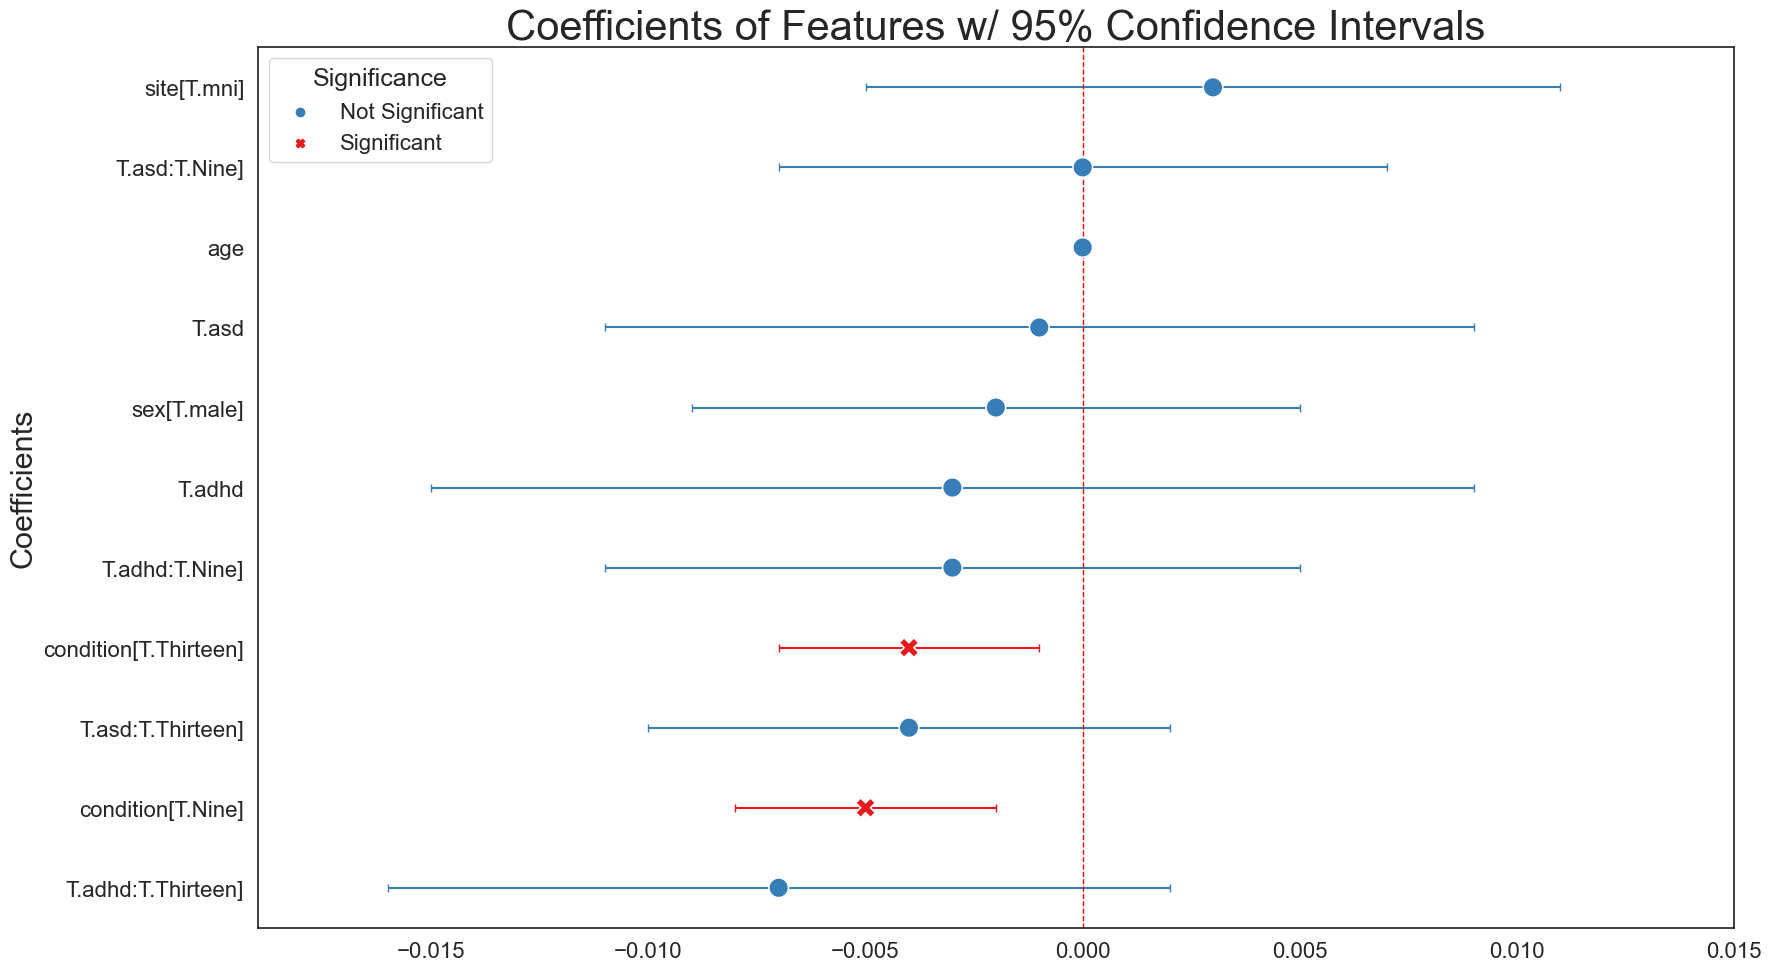

In [347]:
plt.rcParams.update({
    'font.size': 16,       # Base font size for ticks and text
    'axes.titlesize': 30,  # Title font
    'axes.labelsize': 22,  # Axis label font
    'xtick.labelsize': 16, # X-tick font
    'ytick.labelsize': 16, # Y-tick font
    'legend.fontsize': 16, # Legend font
    'legend.title_fontsize': 18  # Legend title font
})
coefplot_gap(model, multiple_models=False, fig_name='Simple Linear')
#nothing matters other than conditions (Faster 13 or 9)

## Linear model for detail (asd, sex, age, site)

In [348]:
# Test the effects of group and condition on rt while accoutning for sex, age and site

# Create mixed effects model 
model_formula = "reciprocal_rt ~ C(diagnosis_group, Treatment(reference = 'control')) * detail + age + sex + site"

# Fit the model
model = smf.mixedlm(model_formula, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()

# Print the summary
model_summary = model.summary()
model_summary

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Mixed Linear Model Regression Results
=======================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     reciprocal_rt
No. Observations:                     2082                        Method:                                 REML         
No. Groups:                           104                         Scale:                                  0.0006       
Min. group size:                      4                           Log-Likelihood:                         4615.1849    
Max. group size:                      25                          Converged:                              Yes          
Mean group size:                      20.0                                                                             
-----------------------------------------------------------------------------------------------------------------------
                                                                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                                                    1.915    0.006 345.631 0.000  1.904  1.925
C(diagnosis_group, Treatment(reference='control'))[T.adhd]                  -0.008    0.006  -1.390 0.165 -0.020  0.003
C(diagnosis_group, Treatment(reference='control'))[T.asd]                   -0.003    0.005  -0.482 0.630 -0.013  0.008
detail[T.Single]                                                            -0.010    0.001  -7.711 0.000 -0.013 -0.008
sex[T.male]                                                                 -0.002    0.004  -0.516 0.606 -0.009  0.005
site[T.mni]                                                                  0.003    0.004   0.702 0.483 -0.005  0.010
C(diagnosis_group, Treatment(reference='control'))[T.adhd]:detail[T.Single]  0.006    0.003   1.730 0.084 -0.001  0.012
C(diagnosis_group, Treatment(reference='control'))[T.asd]:detail[T.Single]   0.002    0.003   0.568 0.570 -0.004  0.007
age                                                                         -0.000    0.000  -0.099 0.921 -0.000  0.000
Group Var                                                                    0.000    0.002                            
=======================================================================================================================

"""

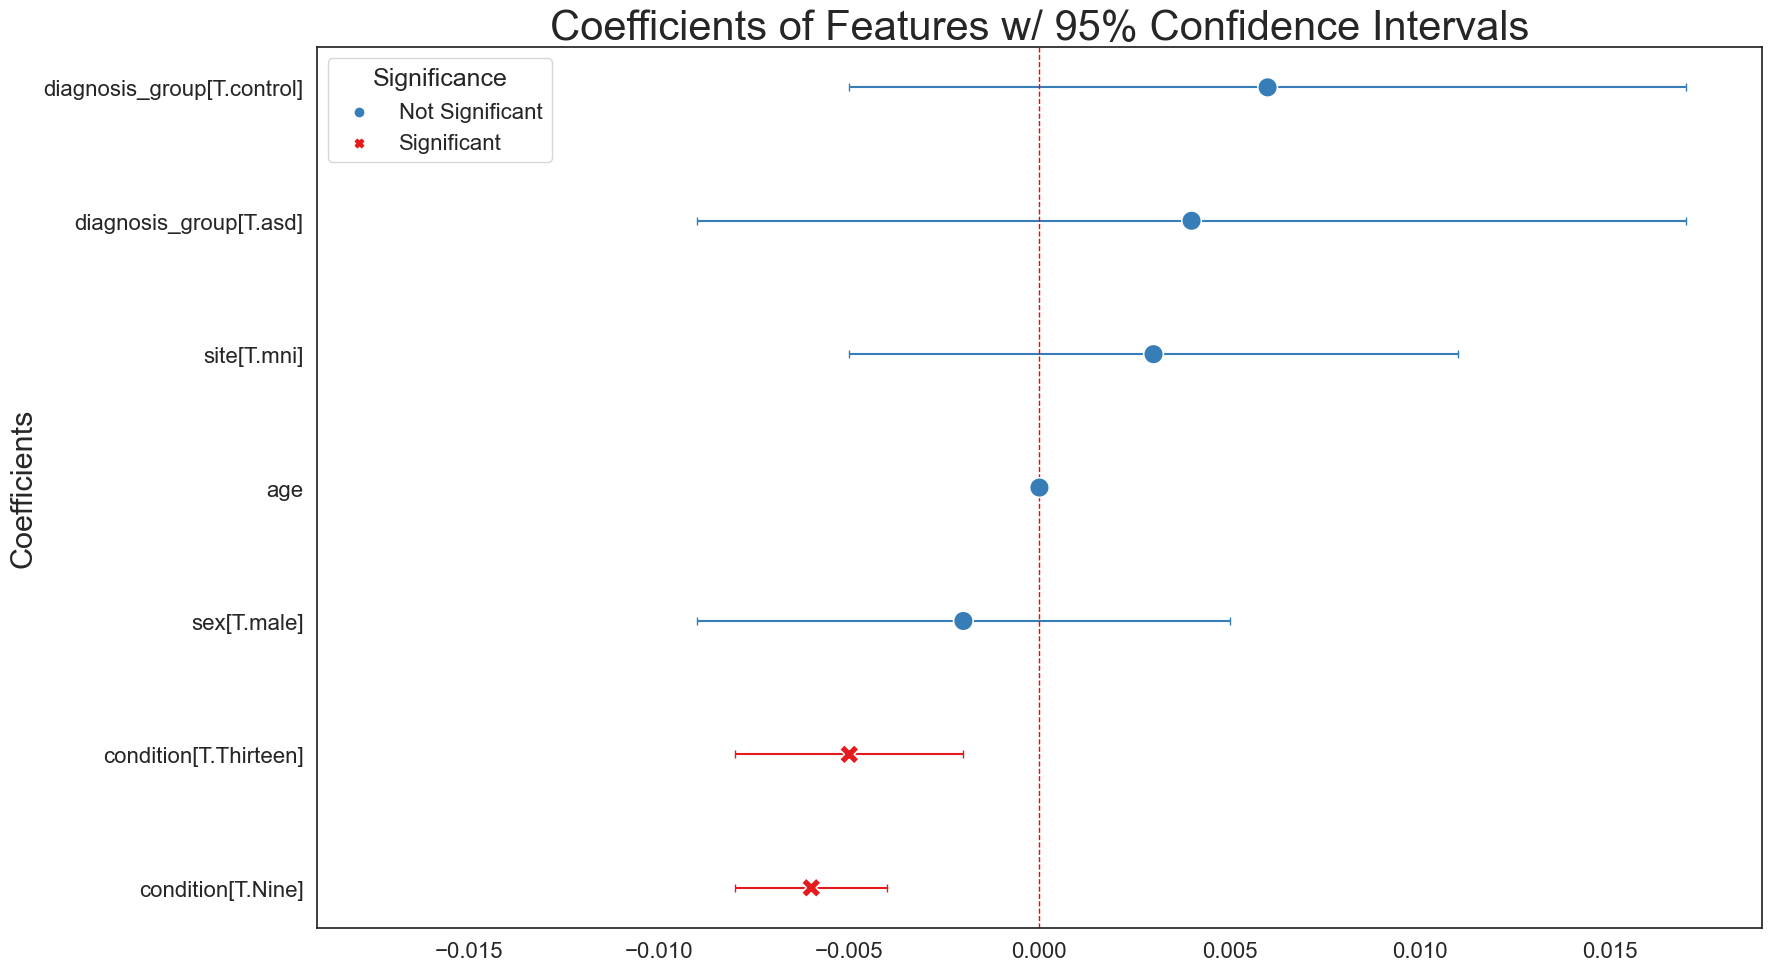

In [357]:

coefplot_gap(model, multiple_models=False, fig_name='Simple Linear')

### Mixed model for reaction time

In [358]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
model_comparison = {}
models_comp= {"original": "reciprocal_rt ~ diagnosis_group * condition + age + sex + site", 
                "no_interaction": "reciprocal_rt ~ diagnosis_group + condition + age + sex + site",
                "no_age": "reciprocal_rt ~ diagnosis_group * condition + sex + site",
                "no_covariates": "reciprocal_rt ~ diagnosis_group * condition"}
coeff_dfs = []
model_comparisons_list = []
model_coefficients = []

for model_name, model_formula in models_comp.items():

    model1 = smf.mixedlm(model_formula, vs_grouped, groups=vs_grouped["subject"], re_formula="1").fit( reml=False)
    # Compare models
    coeff_dfs = []

    # Print the model
    print(model_name,model1.summary())

    #****** IF YOU WANT TO COMPARE MANY MODELS models = [model, model2, model3, model4, model5]
    models = [model1]

    log_likelihoods = [model.llf for model in models]
    aic = [model.aic for model in models]
    bic = [model.bic for model in models]
    converged = [model.converged for model in models]
    # Create dictionary with model names
    model_names = ["Mix Rand-int"]

    model_comparison = pd.DataFrame({"log_likelihood": log_likelihoods, "aic": aic, "bic": bic, "converged":converged }, index=model_names)
    # Collect homoscedasticity test results
    hom_test_results = []


    for model in models:
        hom_test_df = check_homoscedasticity(model, vs_grouped, show_text=False, co_vars=["age", "outcome", "sex", "site"])
        hom_test_results.append(hom_test_df.iloc[0])  # Assuming results are in a single row

        coeff_df = stage_model(model)
        coeff_dfs.append(coeff_df)


    # Convert list of series to a DataFrame
    hom_test_df_combined = pd.DataFrame(hom_test_results, index=model_comparison.index)

    # Merge with model comparison DataFrame
    model_comparison = pd.concat([model_comparison, hom_test_df_combined], axis=1)
    print(model_comparison)

    # Print model comparison results


   
    # Create df with all coefficients
    all_coefs = pd.concat(coeff_dfs, keys=model_names).reset_index()

    all_coefs["model_name"] = model_name
    all_coefs["model"] = model_name
    # Append all coeffts
    model_coefficients.append(all_coefs)
    model_comparisons_list.append(model_comparison)
# Create a df with all model comparisons
model_comparisons_df = pd.concat(model_comparisons_list, keys=models_comp.keys()).reset_index()
model_coefficients_df = pd.concat(model_coefficients)


#coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="all_models")


# Drop unwanted columns
model_coefficients_df.drop(columns=["level_1","model_name"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)
model_comparisons_df.drop(columns=["level_1"], inplace=True)
model_comparisons_df.rename(columns={"level_0": "model"}, inplace=True)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


original                            Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            reciprocal_rt
No. Observations:            2082               Method:                        ML           
No. Groups:                  104                Scale:                         0.0006       
Min. group size:             4                  Log-Likelihood:                4639.9623    
Max. group size:             25                 Converged:                     Yes          
Mean group size:             20.0                                                           
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         1.910    0.006 295.466 0.000  1.897  1.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


no_interaction                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    reciprocal_rt
No. Observations:      2082       Method:                ML           
No. Groups:            104        Scale:                 0.0006       
Min. group size:       4          Log-Likelihood:        4638.2138    
Max. group size:       25         Converged:             Yes          
Mean group size:       20.0                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.908    0.006 308.620 0.000  1.896  1.920
diagnosis_group[T.asd]      0.004    0.006   0.643 0.520 -0.008  0.017
diagnosis_group[T.control]  0.006    0.005   1.066 0.287 -0.005  0.017
condition[T.Nine]          -0.006    0.001  -4.379 0.000 -0.008 -0.003
conditio

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


no_age                            Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            reciprocal_rt
No. Observations:            2082               Method:                        ML           
No. Groups:                  104                Scale:                         0.0006       
Min. group size:             4                  Log-Likelihood:                4639.9449    
Max. group size:             25                 Converged:                     Yes          
Mean group size:             20.0                                                           
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         1.910    0.006 344.531 0.000  1.899  1.92

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


In [359]:
model_comparisons_df

model  log_likelihood          aic          bic  converged  \
0        original     4639.962332 -9251.924664 -9172.949485       True   
1  no_interaction     4638.213756 -9256.427512 -9200.016670       True   
2          no_age     4639.944923 -9253.889846 -9180.555751       True   
3   no_covariates     4639.558958 -9257.117916 -9195.065989       True   

   levene_test_all  white_test  bartlett_test  shapiro_test  \
0     3.070138e-06    0.016088  4.032865e-102      0.000043   
1     9.718078e-07    0.115366  1.734165e-103      0.000019   
2     3.345861e-06    0.109902  4.224258e-102      0.000043   
3     3.340270e-06    0.287714  4.197539e-102      0.000045   

   multicollinearity      age      sex     site  
0          10.846052  0.44001  0.46126  0.28804  
1           2.338296  0.46520  0.48525  0.30188  
2          10.844721  0.44000  0.45997  0.28823  
3          10.843089  0.44015  0.46864  0.29523

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2390626922.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df, ax=ax[0, 0], palette="viridis", ci=None)


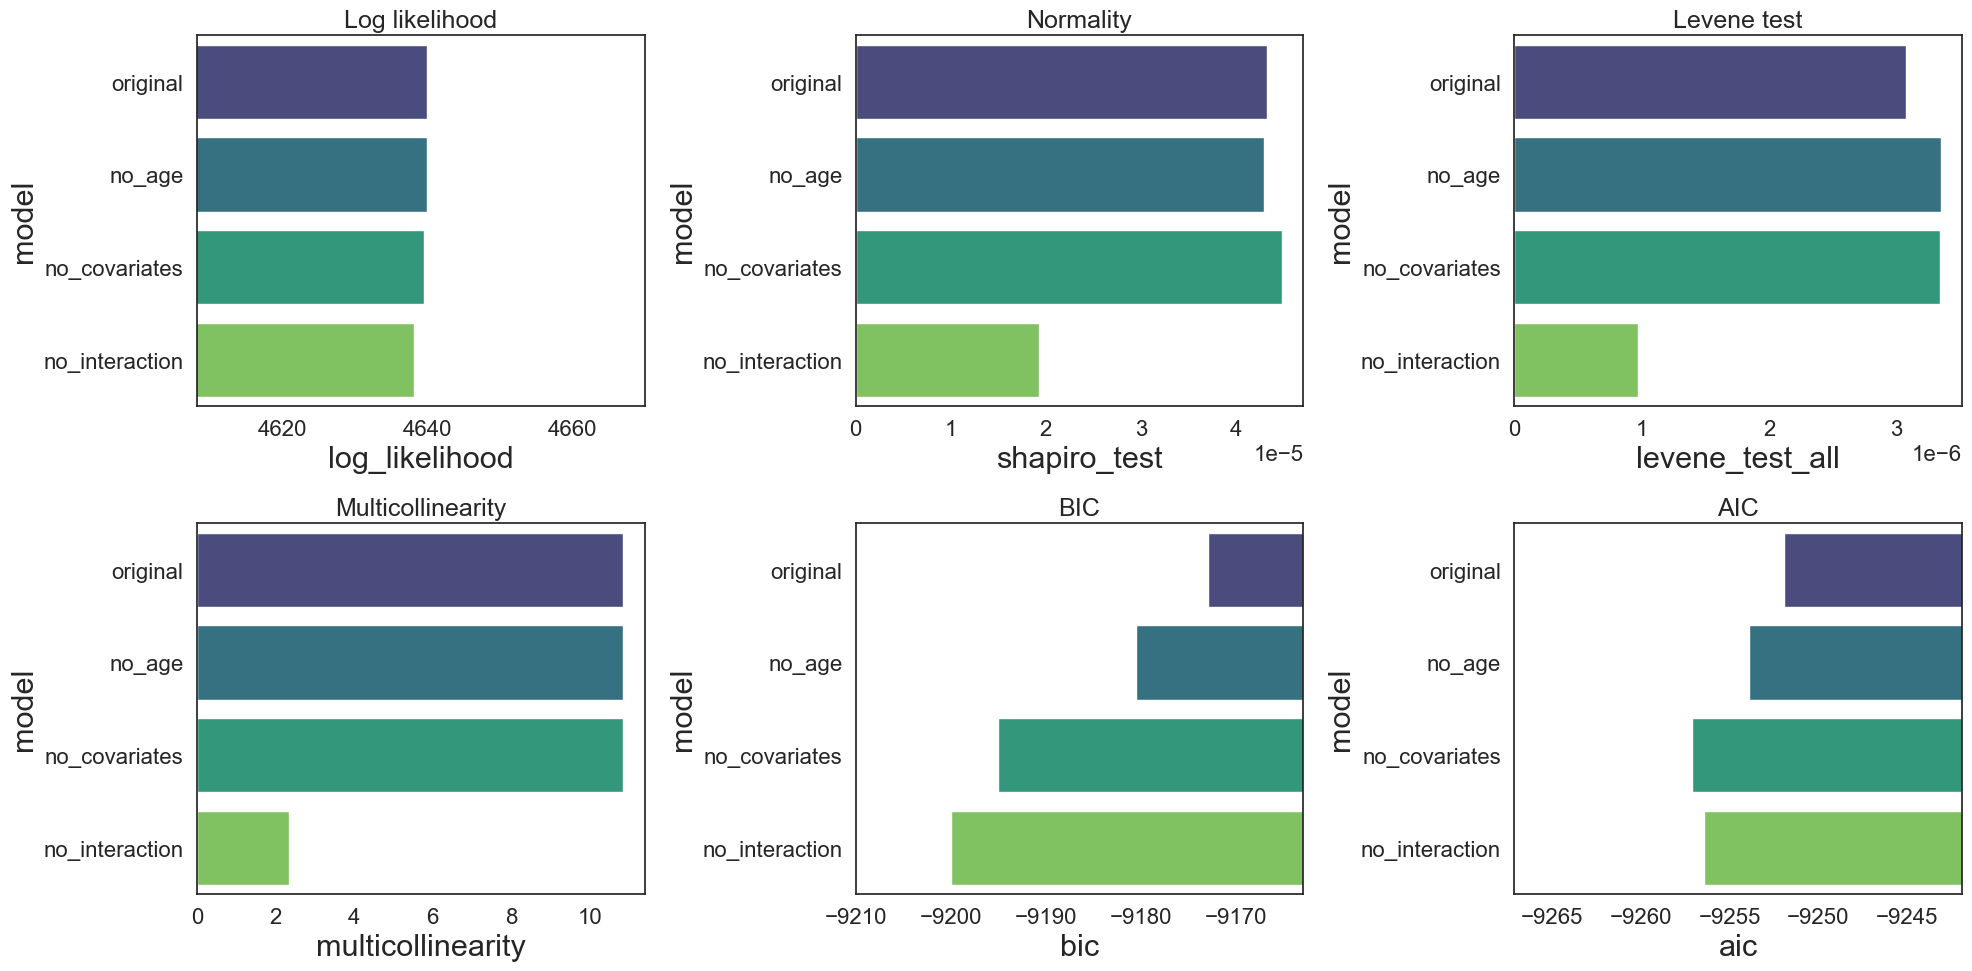

In [360]:
# Plot the different models and sort them by log likelihood

# Megerge all stages

model_comparisons_df["stage"]= "Standard"
model_comparisons_df_stages = model_comparisons_df.copy()

model_comparisons_df_stages = model_comparisons_df_stages.sort_values(by="log_likelihood", ascending=False)

# Plot the different models and sort them by log likelihood

model_comparisons_df = model_comparisons_df.sort_values(by="log_likelihood", ascending=False)

# Plot
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Plot log likelihood
sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df, ax=ax[0, 0], palette="viridis", ci=None)

# Calculate min and max of log_likelihood
log_likelihood_min = model_comparisons_df["log_likelihood"].min() - 30
log_likelihood_max = model_comparisons_df["log_likelihood"].max() + 30

# Set x-axis limits for ax[0, 0]
ax[0, 0].set_xlim(log_likelihood_min, log_likelihood_max)

# Plot Shapiro test
sns.barplot(x="shapiro_test", y="model", data=model_comparisons_df, ax=ax[0, 1], palette="viridis")

# Plot White test
sns.barplot(x="levene_test_all", y="model", data=model_comparisons_df, ax=ax[0, 2], palette="viridis")

# Plot Multicollinearity
sns.barplot(x="multicollinearity", y="model", data=model_comparisons_df, ax=ax[1, 0], palette="viridis")

# Plot BIC
sns.barplot(x="bic", y="model", data=model_comparisons_df, ax=ax[1, 1], palette="viridis")

# Calculate min and max of BIC
bic_min = model_comparisons_df["bic"].min() - 10
bic_max = model_comparisons_df["bic"].max() + 10

# Set x-axis limits for ax[1, 1]
ax[1, 1].set_xlim(bic_min, bic_max)


# Plot AIC
sns.barplot(x="aic", y="model", data=model_comparisons_df, ax=ax[1, 2], palette="viridis")

# Calculate min and max of AIC
aic_min = model_comparisons_df["aic"].min() - 10
aic_max = model_comparisons_df["aic"].max() + 10

# Set x-axis limits for ax[1, 2]
ax[1, 2].set_xlim(aic_min, aic_max)

# Add titles
ax[0, 0].set_title("Log likelihood", fontsize=18)
ax[0, 1].set_title("Normality", fontsize=18)
ax[0, 2].set_title("Levene test", fontsize=18)
ax[1, 0].set_title("Multicollinearity", fontsize=18)
ax[1, 1].set_title("BIC", fontsize=18)
ax[1, 2].set_title("AIC", fontsize=18)

# Change x-axis limits for the log likelihood plot
# ax[0, 0].set_xlim(1330, 1405)

plt.tight_layout()
plt.show()

### Compare best 2 models (no age, no covariance)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


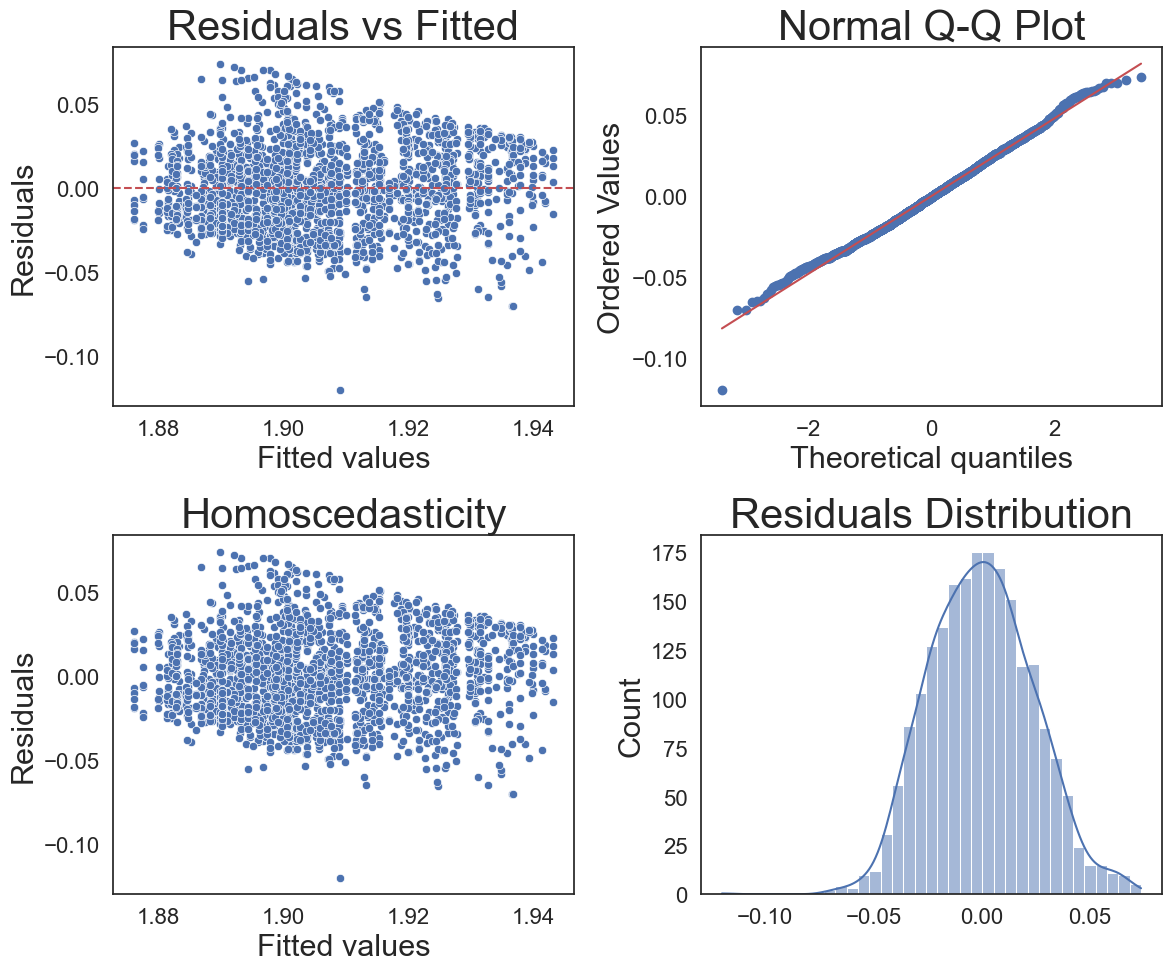

Shapiro-Wilk test p-value: 4.9966067308560014e-05
Residuals are not homoscedastic LeveneResult(statistic=9.493092604466367, pvalue=3.1528790630041897e-06)
Bartlett’s test p-value: 1.0026453664106336e-99
White test p-value: 0.11157701169175983
Levene’s test p-value for the whole model: 3.1528790630041897e-06
Levene’s test p-value for variable age: 0.4397577079455164
Levene’s test p-value for variable sex: 0.45697225813913867
Levene’s test p-value for variable site: 0.2915394492475027
Levene’s test p-value for variable diagnosis_group: 0.4149861807460511
Homoscedasticiyy checked


/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


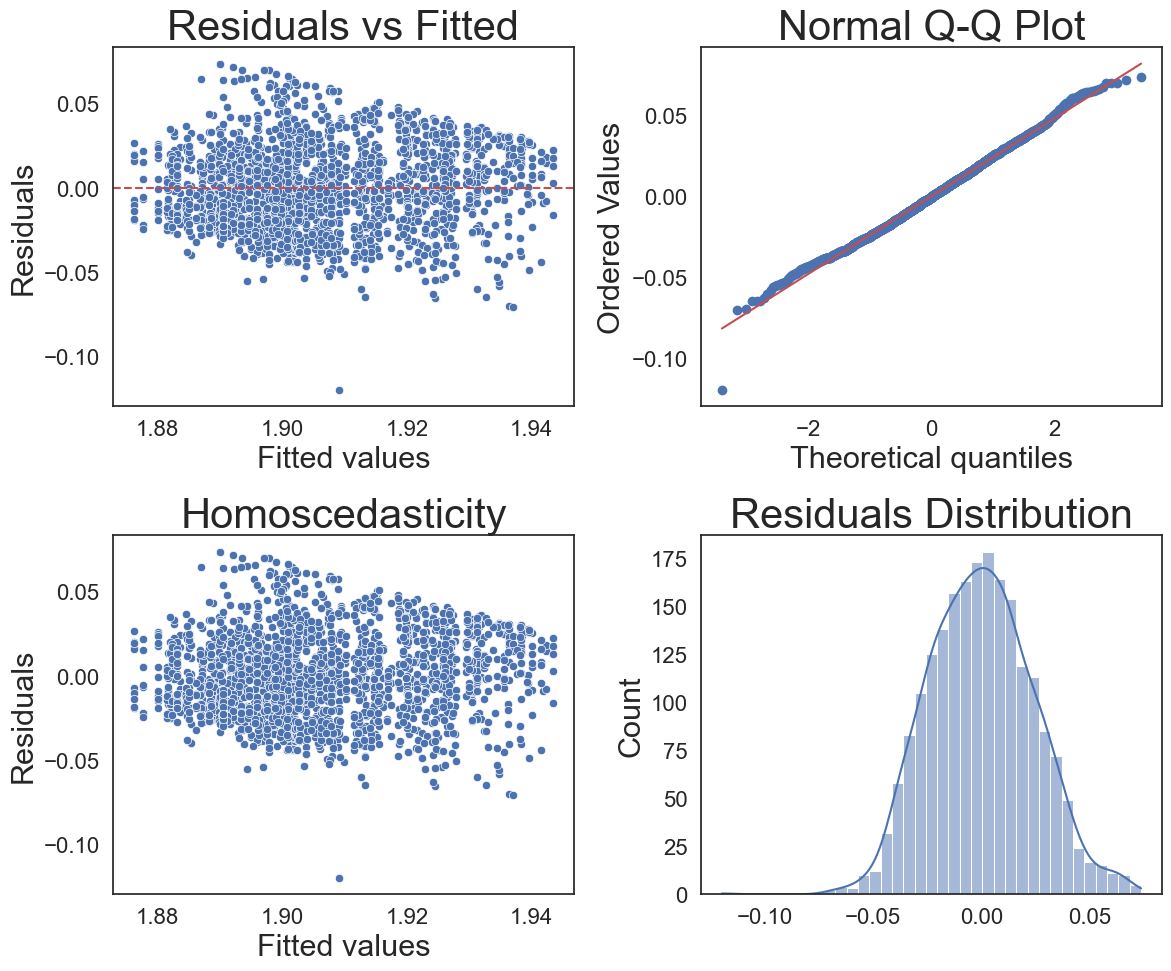

Shapiro-Wilk test p-value: 4.880718552158214e-05
Residuals are not homoscedastic LeveneResult(statistic=9.448118120061828, pvalue=3.3624740089986677e-06)
Bartlett’s test p-value: 9.836066565324469e-101
White test p-value: 0.2926548809167981
Levene’s test p-value for the whole model: 3.3624740089986677e-06
Levene’s test p-value for variable age: 0.4400044621351491
Levene’s test p-value for variable sex: 0.4665506448509903
Levene’s test p-value for variable site: 0.29685534065495717
Levene’s test p-value for variable diagnosis_group: 0.4136622472070851
Homoscedasticiyy checked
Likelihood Ratio Test Statistic: -18.0994
P-value: 1.0000
they are all the same


/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


In [361]:
# Test the effects of group and condition on rt while accoutning for sex, age and site

# Create mixed effects model 
no_age = "reciprocal_rt ~ diagnosis_group * condition + sex + site"
no_covariates = "reciprocal_rt ~ diagnosis_group * condition"

# Fit the model
model1 = smf.mixedlm(no_age, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()
model2 = smf.mixedlm(no_covariates, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()


# Print the summary
model_summary = model1.summary()
model_summary
model_summary = model2.summary()
model_summary

# Check assumptions
asumption_df=check_assumptions(model1, vs_grouped, show_plots=True, show_text=True, covariates=["age","sex","site", "diagnosis_group"])
asumption_df
asumption_df=check_assumptions(model2, vs_grouped, show_plots=True, show_text=True, covariates=["age","sex","site", "diagnosis_group"])
asumption_df

from scipy.stats import chi2
# Log-likelihoods for both models
ll_three_way = model1.llf  # Log-likelihood of 3-way interaction model
ll_two_way = model2.llf  # Log-likelihood of 2-way interaction model
# Likelihood ratio test statistic
lr_stat = 2 * (ll_three_way - ll_two_way)
# Degrees of freedom (number of random effects added in mixed model)
df_diff = 1
# Calculate p-value
p_value = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test Statistic: {lr_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("one model is better")
else:
    print("they are all the same")

In [362]:
# Compare different models 

models= {"original": "reciprocal_rt ~ diagnosis_group * condition + age + sex + site", 
                "no_interaction": "reciprocal_rt ~ diagnosis_group + condition + age + sex + site",
                "no_age": "reciprocal_rt ~ diagnosis_group * condition + sex + site",
                "no_covariates": "reciprocal_rt ~ diagnosis_group * condition"}

model_comparison = {}

for model_name, formula in models.items():
    model = smf.mixedlm(formula, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()
    # Extract log likelihood
    model_comparison[model_name] = model.llf

    # Extract BIC
    if model_name=="original":
        print(model.summary())

        doc.add_heading(f"Linear model for reaction time general")
        doc.add_paragraph(f"{models[model_name]}", style='List Bullet')
        model_summary= model.summary()
        model_table=pd.DataFrame(model_summary.tables[1])
        model_table["var"] = model_table.index
        model_table = model_table[["var", "Coef.", "Std.Err.", "z", "P>|z|", "[0.025", "0.975]"]]

        doc = df_to_table(doc, model_table)
model_comparison = pd.DataFrame(model_comparison, index=["log_likelihood"]).T

# Print the best model based on log likelihood
best_model = model_comparison.idxmax()
print(f"Best model: {best_model}")

# Add to the document
doc.add_paragraph(f"Model comparison for reaction time general", style='List Bullet')
model_comparison["type"] = model_comparison.index
model_comparison = model_comparison[["type", "log_likelihood"]]
doc = df_to_table(doc, model_comparison)
doc.add_paragraph(f'Best model= {best_model[0]} : {models[best_model[0]]}', style='List Bullet')

# Print the summary of the best model
model = smf.mixedlm(models[best_model[0]], vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()
model_summary = model.summary()
model_summary

    


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                           Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            reciprocal_rt
No. Observations:            2082               Method:                        REML         
No. Groups:                  104                Scale:                         0.0006       
Min. group size:             4                  Log-Likelihood:                4577.6928    
Max. group size:             25                 Converged:                     Yes          
Mean group size:             20.0                                                           
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         1.910    0.007 287.184 0.000  1.897  1.923
diagn

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/590789905.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  doc.add_paragraph(f'Best model= {best_model[0]} : {mo

Best model: log_likelihood    no_interaction
dtype: object


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM    Dependent Variable:    reciprocal_rt
No. Observations:      2082       Method:                REML         
No. Groups:            104        Scale:                 0.0006       
Min. group size:       4          Log-Likelihood:        4594.8981    
Max. group size:       25         Converged:             Yes          
Mean group size:       20.0                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.908    0.006 299.231 0.000  1.895  1.920
diagnosis_group[T.asd]      0.004    0.007   0.631 0.528 -0.009  0.017
diagnosis_group[T.control]  0.006    0.006   1.034 0.301 -0.005  0.017
condition[T.Nine]          -0.006    0.001  -4.372 0.000 -0.008 -0.003
condition[T.Thirteen]      -0.005    0.001  -3.916 0.000 -0.008 -0.003
sex[T.male]                -0.002    0.004  -0.568 0.570 -0.009  0.005
site[T.mni]                 0.003    0.004   0.703 0.482 -0.005  0.010
age                        -0.000    0.000  -0.172 0.864 -0.000  0.000
Group Var                   0.000    0.002                            
======================================================================

"""

In [363]:
models[best_model[0]]

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2921822112.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  models[best_model[0]]


'reciprocal_rt ~ diagnosis_group + condition + age + sex + site'

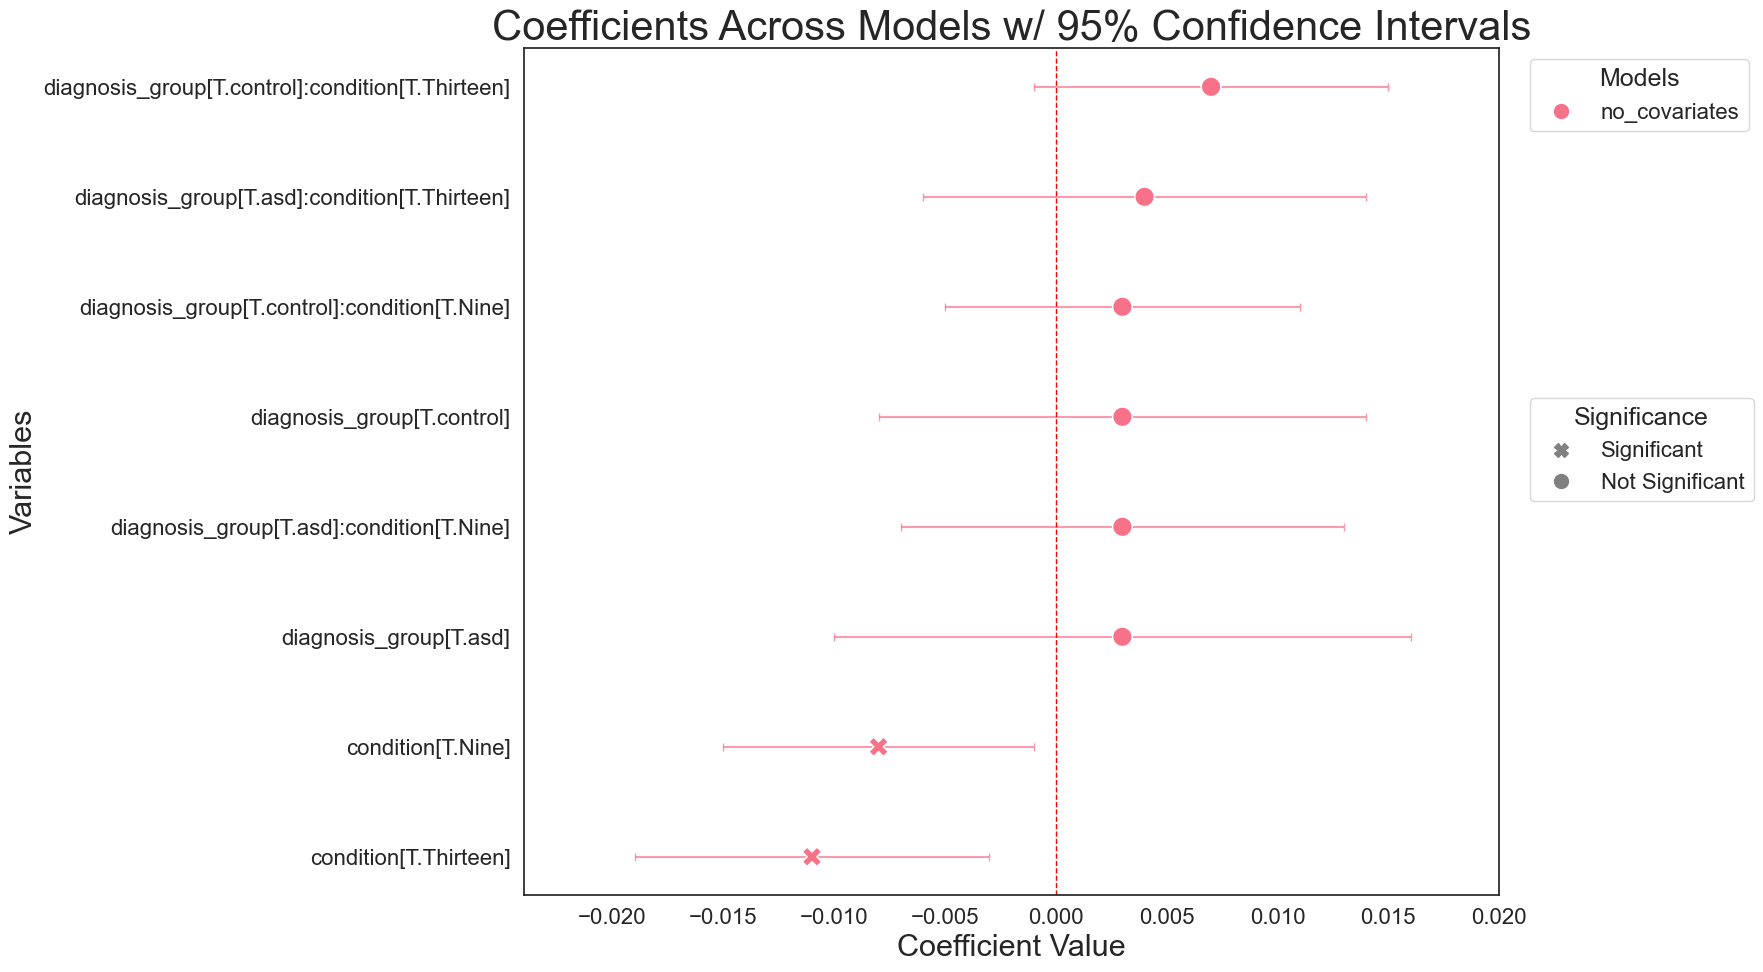

In [364]:
coefplot_gap(all_coefs, multiple_models=True, fig_name="multiple_models")

## Best linear model for detail (+other variables)

In [365]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
model_comparison = {}
models_comp= {"original": "reciprocal_rt ~ diagnosis_group * detail + age + sex + site", 
                "no_interaction": "reciprocal_rt ~ diagnosis_group + detail + age + sex + site",
                "no_age": "reciprocal_rt ~ diagnosis_group * detail + sex + site",
                "no_covariates": "reciprocal_rt ~ diagnosis_group * detail"}
coeff_dfs = []
model_comparisons_list = []
model_coefficients = []

for model_name, model_formula in models_comp.items():

    model1 = smf.mixedlm(model_formula, vs_grouped, groups=vs_grouped["subject"], re_formula="1").fit( reml=False)
    # Compare models
    coeff_dfs = []

    # Print the model
    print(model_name,model1.summary())

    #****** IF YOU WANT TO COMPARE MANY MODELS models = [model, model2, model3, model4, model5]
    models = [model1]

    log_likelihoods = [model.llf for model in models]
    aic = [model.aic for model in models]
    bic = [model.bic for model in models]
    converged = [model.converged for model in models]
    # Create dictionary with model names
    model_names = ["Mix Rand-int"]
    model_table = model_table[["var", "Coef.", "Std.Err.", "z", "P>|z|", "[0.025", "0.975]"]]

    model_comparison = pd.DataFrame({"log_likelihood": log_likelihoods, "aic": aic, "bic": bic, "converged":converged }, index=model_names)
    # Collect homoscedasticity test results
    hom_test_results = []


    for model in models:
        hom_test_df = check_homoscedasticity(model, vs_grouped, show_text=False, co_vars=["age", "outcome", "sex", "site"])
        hom_test_results.append(hom_test_df.iloc[0])  # Assuming results are in a single row

        coeff_df = stage_model(model)
        coeff_dfs.append(coeff_df)


    # Convert list of series to a DataFrame
    hom_test_df_combined = pd.DataFrame(hom_test_results, index=model_comparison.index)

    # Merge with model comparison DataFrame
    model_comparison = pd.concat([model_comparison, hom_test_df_combined], axis=1)
    print(model_comparison)

    # Print model comparison results


   
    # Create df with all coefficients
    all_coefs = pd.concat(coeff_dfs, keys=model_names).reset_index()

    all_coefs["model_name"] = model_name
    all_coefs["model"] = model_name
    # Append all coeffts
    model_coefficients.append(all_coefs)
    model_comparisons_list.append(model_comparison)
# Create a df with all model comparisons
model_comparisons_df = pd.concat(model_comparisons_list, keys=models_comp.keys()).reset_index()
model_coefficients_df = pd.concat(model_coefficients)


#coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="all_models")


# Drop unwanted columns
model_coefficients_df.drop(columns=["level_1","model_name"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)
model_comparisons_df.drop(columns=["level_1"], inplace=True)
model_comparisons_df.rename(columns={"level_0": "model"}, inplace=True)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


original                          Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          reciprocal_rt
No. Observations:           2082             Method:                      ML           
No. Groups:                 104              Scale:                       0.0006       
Min. group size:            4                Log-Likelihood:              4662.4998    
Max. group size:            25               Converged:                   Yes          
Mean group size:            20.0                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                    1.906    0.006 295.080 0.000  1.894  1.919
diagnosis_group[T.asd]                       0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


no_interaction                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    reciprocal_rt
No. Observations:      2082       Method:                ML           
No. Groups:            104        Scale:                 0.0006       
Min. group size:       4          Log-Likelihood:        4660.9752    
Max. group size:       25         Converged:             Yes          
Mean group size:       20.0                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.908    0.006 302.810 0.000  1.896  1.921
diagnosis_group[T.asd]      0.004    0.007   0.554 0.580 -0.009  0.017
diagnosis_group[T.control]  0.006    0.006   0.994 0.320 -0.005  0.017
detail[T.Single]           -0.009    0.001  -8.395 0.000 -0.011 -0.007
sex[T.ma

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


no_age                          Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          reciprocal_rt
No. Observations:           2082             Method:                      ML           
No. Groups:                 104              Scale:                       0.0006       
Min. group size:            4                Log-Likelihood:              4662.4937    
Max. group size:            25               Converged:                   Yes          
Mean group size:            20.0                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                    1.906    0.005 346.757 0.000  1.895  1.917
diagnosis_group[T.asd]                       0.006

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


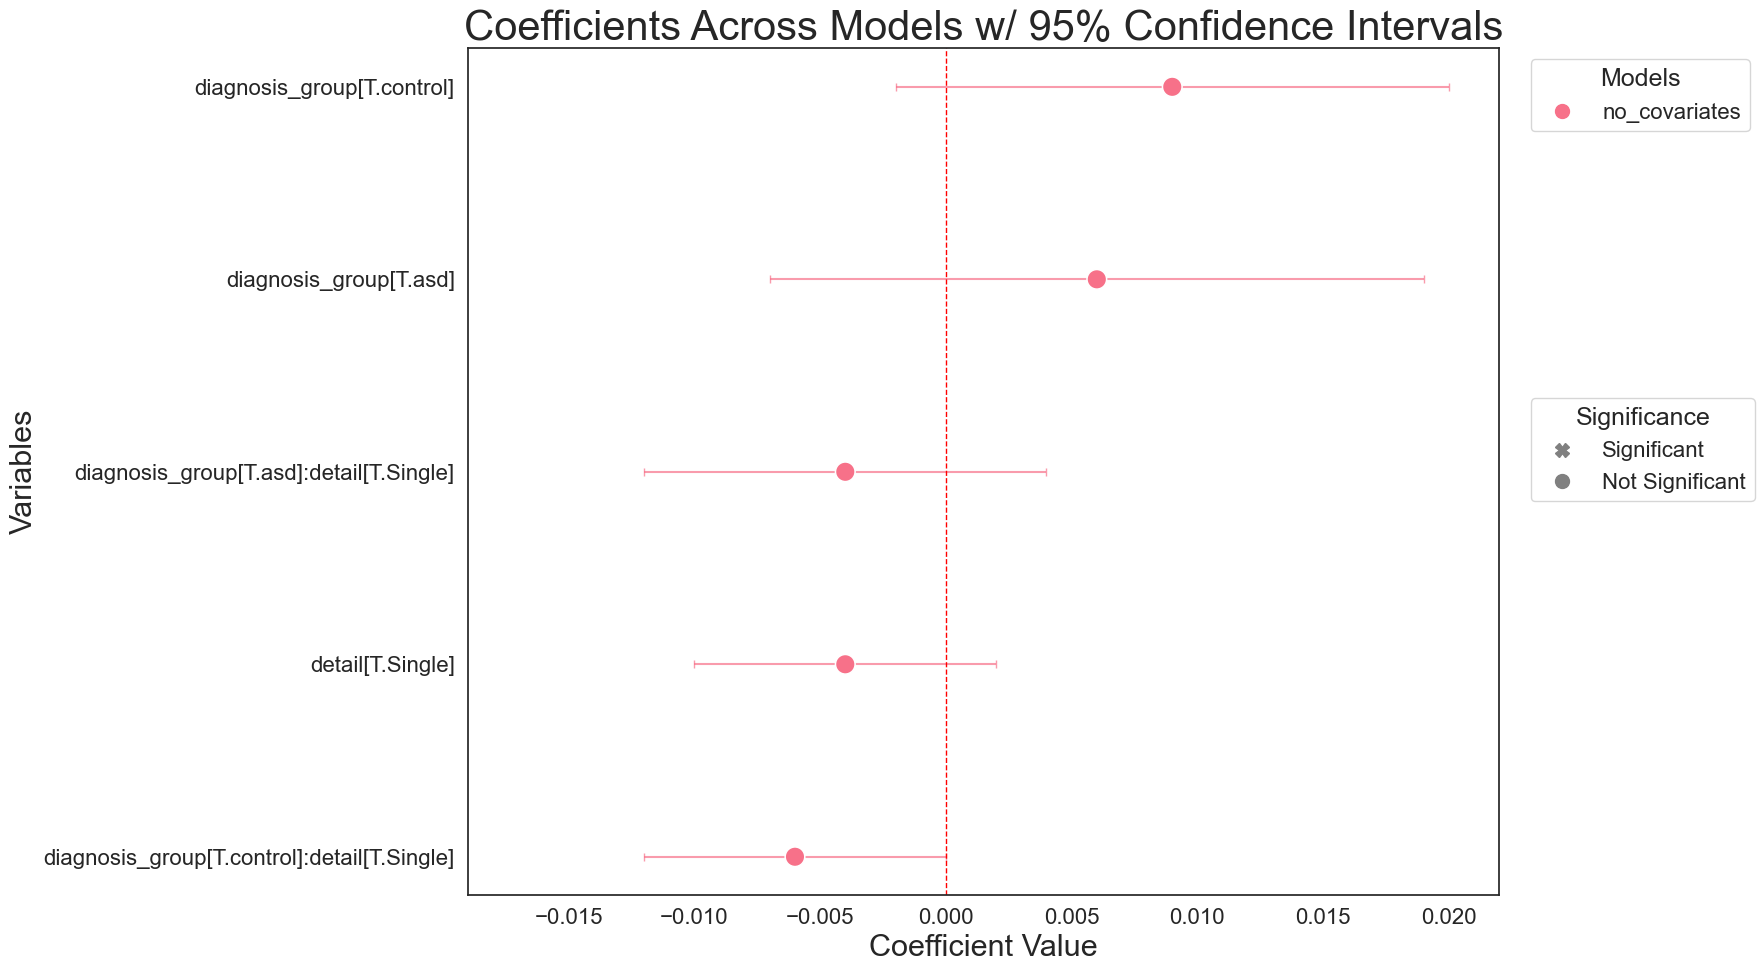

In [366]:
coefplot_gap(all_coefs, multiple_models=True, fig_name="multiple_models")

In [367]:
model_comparisons_df

model  log_likelihood          aic          bic  converged  \
0        original     4662.499827 -9302.999655 -9240.947728       True   
1  no_interaction     4660.975175 -9303.950351 -9253.180592       True   
2          no_age     4662.493747 -9304.987493 -9248.576651       True   
3   no_covariates     4662.114943 -9308.229886 -9263.101212       True   

   levene_test_all  white_test  bartlett_test  shapiro_test  \
0         0.014565    0.000040   4.476289e-84  8.222767e-09   
1         0.004477    0.000363   3.703493e-85  5.368931e-09   
2         0.014583    0.000052   4.578371e-84  8.233053e-09   
3         0.030933    0.000168   4.592814e-84  9.147994e-09   

   multicollinearity      age      sex     site  
0           8.435129  0.58869  0.24682  0.25085  
1           2.338228  0.55677  0.26235  0.24391  
2           8.435109  0.58872  0.24680  0.25133  
3           8.434664  0.58889  0.25351  0.25798

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2390626922.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df, ax=ax[0, 0], palette="viridis", ci=None)


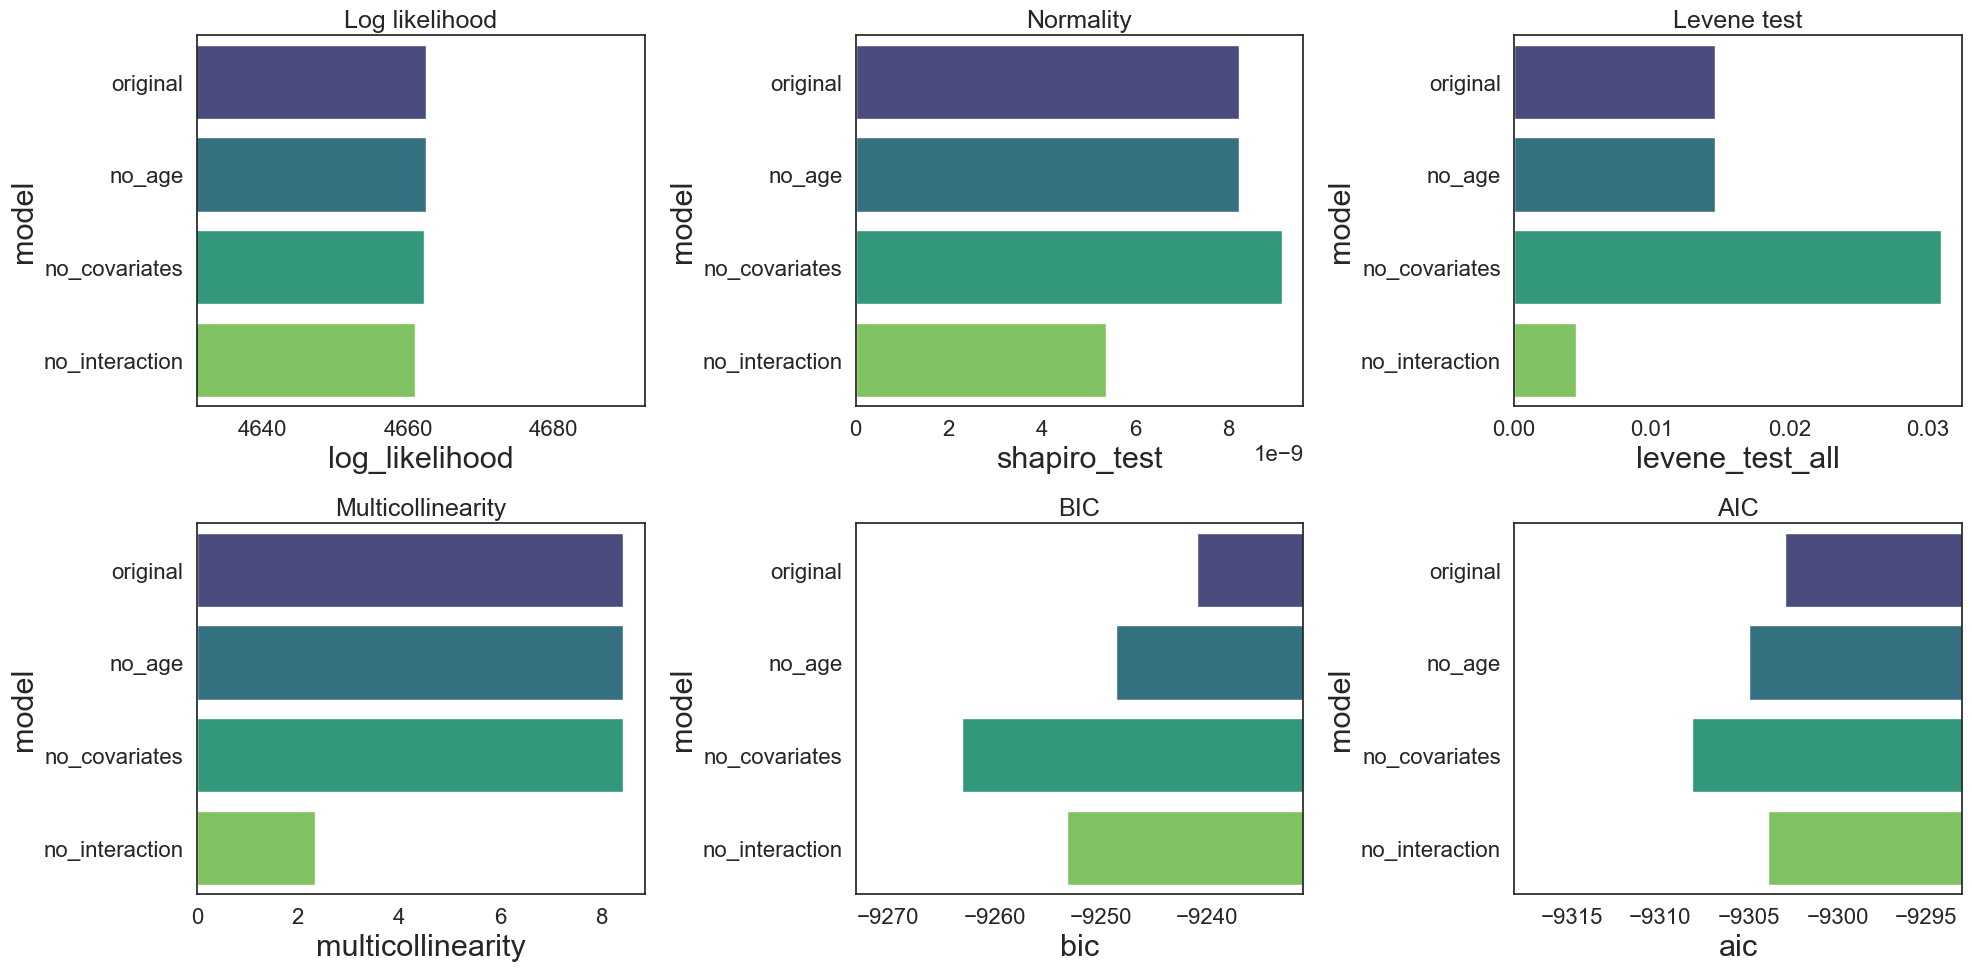

In [368]:
# Plot the different models and sort them by log likelihood

# Megerge all stages

model_comparisons_df["stage"]= "Standard"
model_comparisons_df_stages = model_comparisons_df.copy()

model_comparisons_df_stages = model_comparisons_df_stages.sort_values(by="log_likelihood", ascending=False)

# Plot the different models and sort them by log likelihood

model_comparisons_df = model_comparisons_df.sort_values(by="log_likelihood", ascending=False)

# Plot
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Plot log likelihood
sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df, ax=ax[0, 0], palette="viridis", ci=None)

# Calculate min and max of log_likelihood
log_likelihood_min = model_comparisons_df["log_likelihood"].min() - 30
log_likelihood_max = model_comparisons_df["log_likelihood"].max() + 30

# Set x-axis limits for ax[0, 0]
ax[0, 0].set_xlim(log_likelihood_min, log_likelihood_max)

# Plot Shapiro test
sns.barplot(x="shapiro_test", y="model", data=model_comparisons_df, ax=ax[0, 1], palette="viridis")

# Plot White test
sns.barplot(x="levene_test_all", y="model", data=model_comparisons_df, ax=ax[0, 2], palette="viridis")

# Plot Multicollinearity
sns.barplot(x="multicollinearity", y="model", data=model_comparisons_df, ax=ax[1, 0], palette="viridis")

# Plot BIC
sns.barplot(x="bic", y="model", data=model_comparisons_df, ax=ax[1, 1], palette="viridis")

# Calculate min and max of BIC
bic_min = model_comparisons_df["bic"].min() - 10
bic_max = model_comparisons_df["bic"].max() + 10

# Set x-axis limits for ax[1, 1]
ax[1, 1].set_xlim(bic_min, bic_max)


# Plot AIC
sns.barplot(x="aic", y="model", data=model_comparisons_df, ax=ax[1, 2], palette="viridis")

# Calculate min and max of AIC
aic_min = model_comparisons_df["aic"].min() - 10
aic_max = model_comparisons_df["aic"].max() + 10

# Set x-axis limits for ax[1, 2]
ax[1, 2].set_xlim(aic_min, aic_max)

# Add titles
ax[0, 0].set_title("Log likelihood", fontsize=18)
ax[0, 1].set_title("Normality", fontsize=18)
ax[0, 2].set_title("Levene test", fontsize=18)
ax[1, 0].set_title("Multicollinearity", fontsize=18)
ax[1, 1].set_title("BIC", fontsize=18)
ax[1, 2].set_title("AIC", fontsize=18)

# Change x-axis limits for the log likelihood plot
# ax[0, 0].set_xlim(1330, 1405)

plt.tight_layout()
plt.show()

In [280]:
# trends : asd slower in general
#9 suppose to gofaster in controls but goes slower in asd (asd effect seems to more of a big deal)
#13 suppose to go even slower, combine asd goes still slower


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


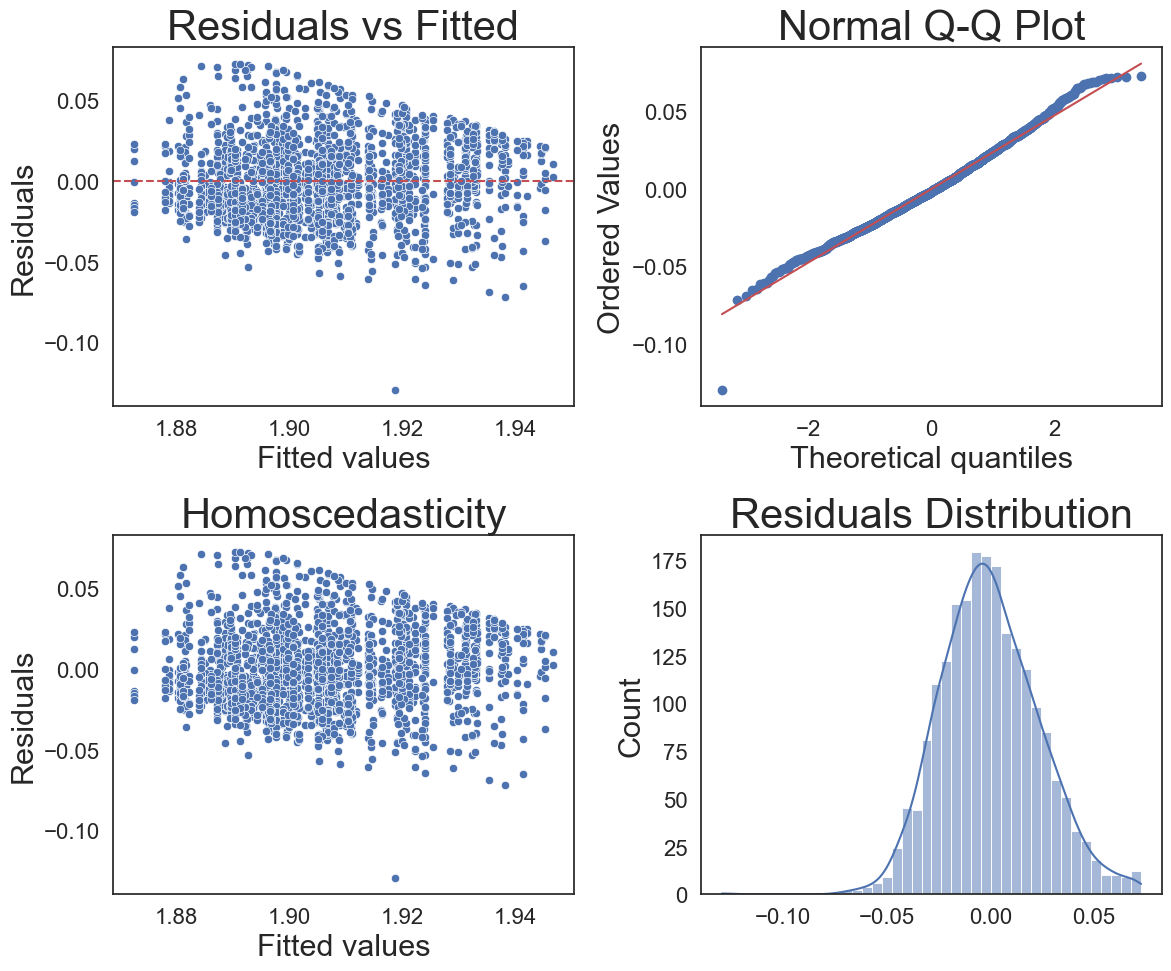

Shapiro-Wilk test p-value: 5.715580897458494e-09
Residuals are not homoscedastic LeveneResult(statistic=4.380885701699172, pvalue=0.004416147137548891)
Bartlett’s test p-value: 1.3081906867681573e-82
White test p-value: 0.00038235118673730353
Levene’s test p-value for the whole model: 0.004416147137548891
Levene’s test p-value for variable age: 0.5571914533131985
Levene’s test p-value for variable sex: 0.2584627147566435
Levene’s test p-value for variable site: 0.24601188023207593
Levene’s test p-value for variable diagnosis_group: 0.4490637731053221
Homoscedasticiyy checked


/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


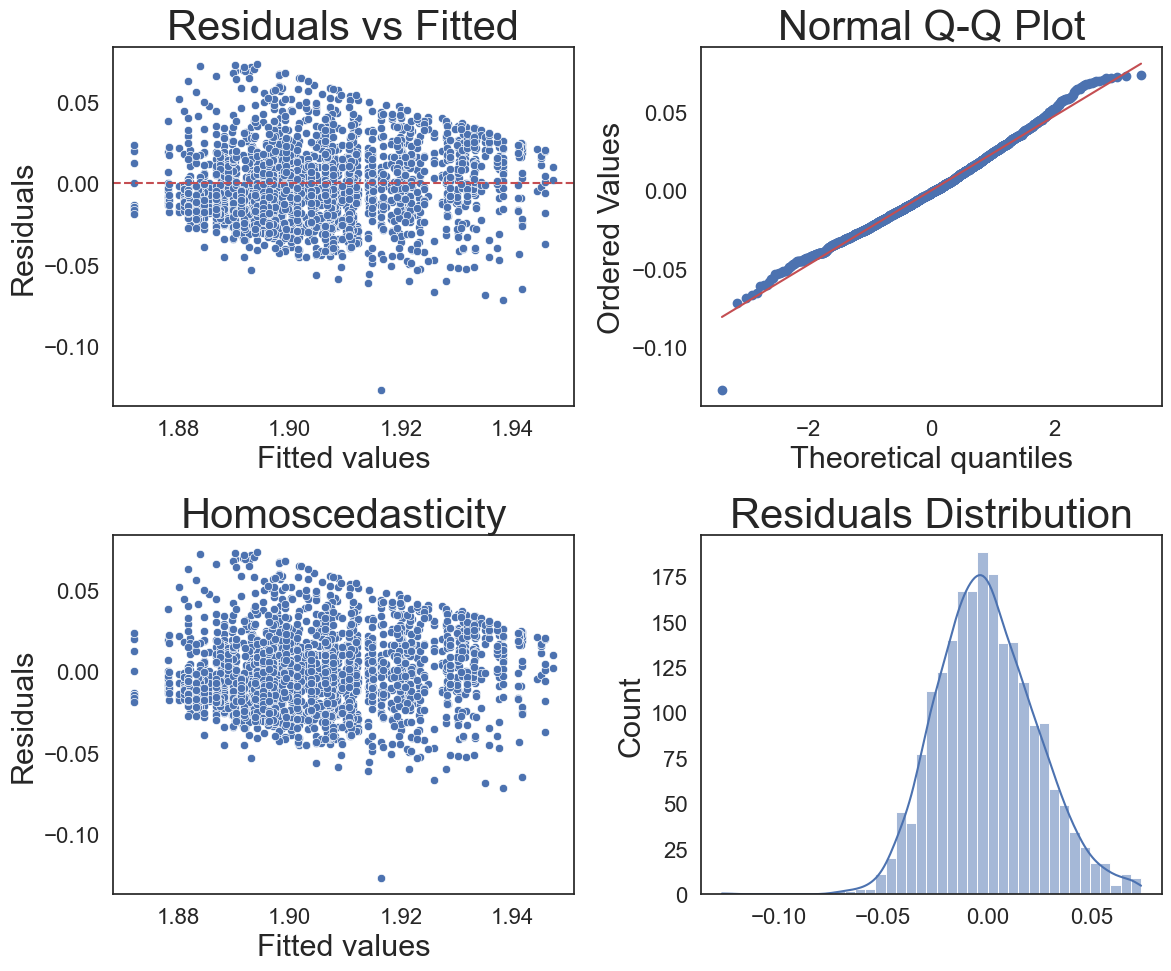

Shapiro-Wilk test p-value: 9.328428696164792e-09
Residuals are not homoscedastic LeveneResult(statistic=2.963867670050727, pvalue=0.031003100505965952)
Bartlett’s test p-value: 7.551304457712544e-83
White test p-value: 0.00017005997874231464
Levene’s test p-value for the whole model: 0.031003100505965952
Levene’s test p-value for variable age: 0.5891615333231539
Levene’s test p-value for variable sex: 0.25094050258917905
Levene’s test p-value for variable site: 0.2590500011863717
Levene’s test p-value for variable diagnosis_group: 0.41098109392066984
Homoscedasticiyy checked
Likelihood Ratio Test Statistic: -17.5691
P-value: 1.0000
they are all the same


/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


In [369]:
# Test the effects of group and condition on rt while accoutning for sex, age and site

# Create mixed effects model 
no_interaction = "reciprocal_rt ~ diagnosis_group + detail + age + sex + site"
no_covariates = "reciprocal_rt ~ diagnosis_group * detail"

# Fit the model
model1 = smf.mixedlm(no_interaction, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()
model2 = smf.mixedlm(no_covariates, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()


# Print the summary
model_summary = model1.summary()
model_summary
model_summary = model2.summary()
model_summary

# Check assumptions
asumption_df=check_assumptions(model1, vs_grouped, show_plots=True, show_text=True, covariates=["age","sex","site", "diagnosis_group"])
asumption_df
asumption_df=check_assumptions(model2, vs_grouped, show_plots=True, show_text=True, covariates=["age","sex","site", "diagnosis_group"])
asumption_df

from scipy.stats import chi2
# Log-likelihoods for both models
ll_three_way = model1.llf  # Log-likelihood of 3-way interaction model
ll_two_way = model2.llf  # Log-likelihood of 2-way interaction model
# Likelihood ratio test statistic
lr_stat = 2 * (ll_three_way - ll_two_way)
# Degrees of freedom (number of random effects added in mixed model)
df_diff = 1
# Calculate p-value
p_value = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test Statistic: {lr_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("one model is better")
else:
    print("they are all the same")

In [370]:
model_comparison = {}
models= {"original": "reciprocal_rt ~ diagnosis_group * detail + age + sex + site", 
                "no_interaction": "reciprocal_rt ~ diagnosis_group + detail + age + sex + site",
                "no_age": "reciprocal_rt ~ diagnosis_group * detail + sex + site",
                "no_covariates": "reciprocal_rt ~ diagnosis_group * detail"}
coeff_dfs = []

for model_name, formula in models.items():
    model = smf.mixedlm(formula, vs_grouped, groups=vs_grouped["subject"],re_formula="1").fit()
    # Extract log likelihood
    model_comparison[model_name] = model.llf

    # Add to coeff dfs
    coef_df = pd.DataFrame(model.summary().tables[1]).reset_index()
    coef_df = coef_df.loc[coef_df["index"] != "Group Var"]
    coef_df['model'] = model_name
   
    coeff_dfs.append(coef_df)


    # Extract BIC
    if model_name=="original":
        print(model.summary())

        doc.add_heading(f"Linear model for reaction time general")
        doc.add_paragraph(f"{models[model_name]}", style='List Bullet')
        model_summary= model.summary()
        model_table=pd.DataFrame(model_summary.tables[1])
        model_table["var"] = model_table.index
        model_table = model_table[["var", "Coef.", "Std.Err.", "z", "P>|z|", "[0.025", "0.975]"]]

        doc = df_to_table(doc, model_table)
model_comparison = pd.DataFrame(model_comparison, index=["log_likelihood"]).T

# Create df with all coefficients
all_coefs = pd.concat(coeff_dfs, keys=models.keys()).reset_index()


# Print the best model based on log likelihood
best_model = model_comparison.idxmax()
print(f"Best model: {best_model}")

# Add to the document
doc.add_paragraph(f"Model comparison for reaction time general", style='List Bullet')
model_comparison["type"] = model_comparison.index
model_comparison = model_comparison[["type", "log_likelihood"]]
doc = df_to_table(doc, model_comparison)
doc.add_paragraph(f'Best model= {best_model[0]} : {models[best_model[0]]}', style='List Bullet')

# Print the summary of the best model
model = smf.mixedlm(models[best_model[0]], vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()
model_summary = model.summary()
model_summary

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                         Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          reciprocal_rt
No. Observations:           2082             Method:                      REML         
No. Groups:                 104              Scale:                       0.0006       
Min. group size:            4                Log-Likelihood:              4615.1849    
Max. group size:            25               Converged:                   Yes          
Mean group size:            20.0                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                    1.906    0.007 286.444 0.000  1.893  1.919
diagnosis_group[T.asd]                       0.006    0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2560125870.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  doc.add_paragraph(f'Best model= {best_model[0]} : {m

Best model: log_likelihood    no_covariates
dtype: object


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                      MixedLM          Dependent Variable:          reciprocal_rt
No. Observations:           2082             Method:                      REML         
No. Groups:                 104              Scale:                       0.0006       
Min. group size:            4                Log-Likelihood:              4632.2068    
Max. group size:            25               Converged:                   Yes          
Mean group size:            20.0                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                    1.905    0.005 355.506 0.000  1.895  1.916
diagnosis_group[T.asd]                       0.006    0.007   0.955 0.339 -0.007  0.020
diagnosis_group[T.control]                   0.009    0.006   1.520 0.129 -0.003  0.020
detail[T.Single]                            -0.004    0.003  -1.367 0.171 -0.010  0.002
diagnosis_group[T.asd]:detail[T.Single]     -0.004    0.004  -1.087 0.277 -0.012  0.003
diagnosis_group[T.control]:detail[T.Single] -0.006    0.003  -1.732 0.083 -0.012  0.001
Group Var                                    0.000    0.002                            
=======================================================================================

"""

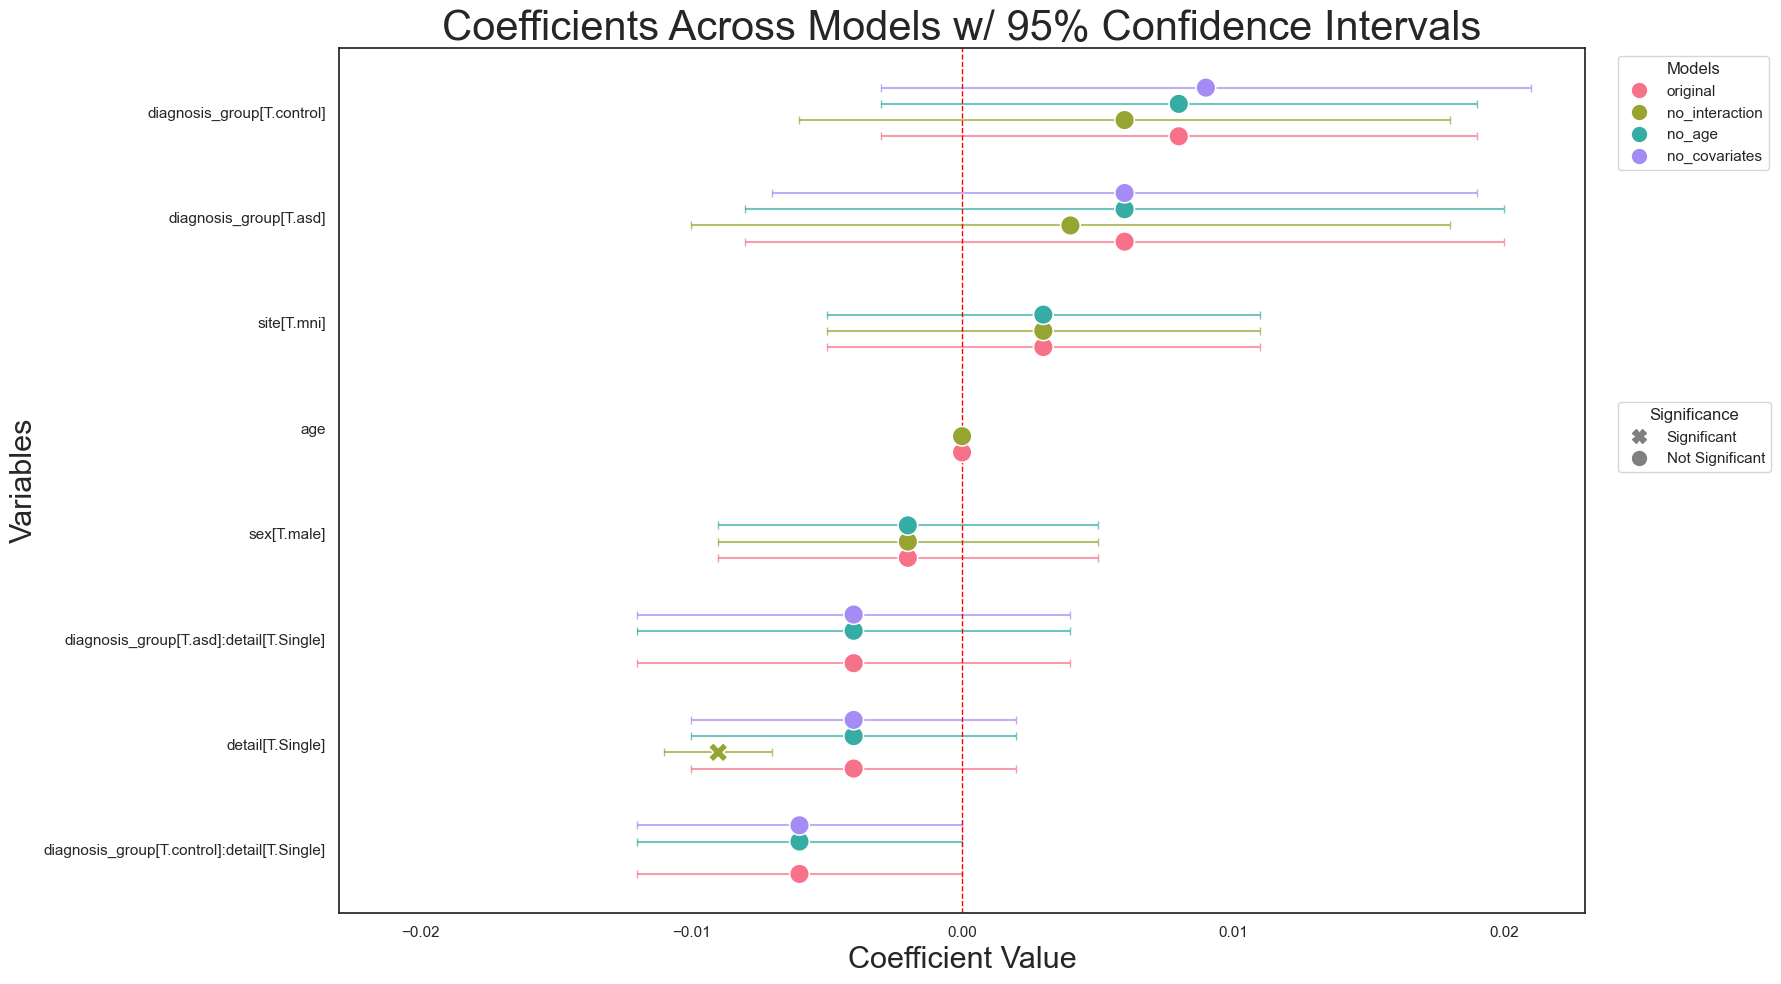

In [284]:
coefplot_gap(all_coefs, multiple_models=True, fig_name="multiple_models")

## Compare different models including trial number and overall rt 

In [371]:
rt_sub.columns

Index(['index', 'subject', 'Trial_Index_', 'condition', 'detail', 'rt',
       'VS_VALID', 'vs_location_list', 'age', 'group', 'site', 'sex', 'asd',
       'adhd', 'record_id', 'age_group', 'diagnosis_group', 'reciprocal_rt',
       'cond_det', 'total_trials', 'overall_rt'],
      dtype='object')

In [372]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
model_comparison = {}
rt_sub_all = rt_sub.merge(vs_grouped, on='subject', how='inner', suffixes=('', '_dup'))
rt_sub_all = rt_sub_all.loc[:, ~rt_sub_all.columns.str.endswith('_dup')]
rt_sub_all["Trial_Index_"] = rt_sub_all["Trial_Index_"].astype(float)

models= {"original": "reciprocal_rt ~ diagnosis_group * condition + age + sex + site + total_trials + Trial_Index_", 
                "trial_index_interaction": "reciprocal_rt ~ diagnosis_group * condition + diagnosis_group * Trial_Index_ + age + sex + site ",
                "no_interaction": "reciprocal_rt ~ diagnosis_group + condition + age + sex + site + total_trials", 
                "no_age": "reciprocal_rt ~ diagnosis_group * condition + sex + site + total_trials + Trial_Index_",
                "no_covariates": "reciprocal_rt ~ diagnosis_group * condition"}
coeff_dfs = []
model_comparisons_list = []
model_coefficients = []

for model_name, model_formula in models.items():

    model1 = smf.mixedlm(model_formula, rt_sub, groups=rt_sub["subject"], re_formula="1").fit( reml=False)
    # Compare models
    coeff_dfs = []

    # Print the model
    print(model_name,model1.summary())

    #****** IF YOU WANT TO COMPARE MANY MODELS models = [model, model2, model3, model4, model5]
    models = [model1]

    log_likelihoods = [model.llf for model in models]
    aic = [model.aic for model in models]
    bic = [model.bic for model in models]
    converged = [model.converged for model in models]
    # Create dictionary with model names
    model_names = ["Mix Rand-int"]

    model_comparison = pd.DataFrame({"log_likelihood": log_likelihoods, "aic": aic, "bic": bic, "converged":converged }, index=model_names)
    # Collect homoscedasticity test results
    hom_test_results = []


    for model in models:
        hom_test_df = check_homoscedasticity(model, rt_sub, show_text=False, co_vars=["age", "outcome", "sex", "site"])
        hom_test_results.append(hom_test_df.iloc[0])  # Assuming results are in a single row

        coeff_df = stage_model(model)
        coeff_dfs.append(coeff_df)


    # Convert list of series to a DataFrame
    hom_test_df_combined = pd.DataFrame(hom_test_results, index=model_comparison.index)

    # Merge with model comparison DataFrame
    model_comparison = pd.concat([model_comparison, hom_test_df_combined], axis=1)
    print(model_comparison)

    # Print model comparison results


   
    # Create df with all coefficients
    all_coefs = pd.concat(coeff_dfs, keys=model_names).reset_index()

    all_coefs["model_name"] = model_name
    all_coefs["model"] = model_name
    # Append all coeffts
    model_coefficients.append(all_coefs)
    model_comparisons_list.append(model_comparison)
# Create a df with all model comparisons
model_comparisons_df = pd.concat(model_comparisons_list, keys=models_comp.keys()).reset_index()
model_coefficients_df = pd.concat(model_coefficients)


#coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="all_models")


# Drop unwanted columns
model_coefficients_df.drop(columns=["level_1","model_name"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)
model_comparisons_df.drop(columns=["level_1"], inplace=True)
model_comparisons_df.rename(columns={"level_0": "model"}, inplace=True)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


original                            Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            reciprocal_rt
No. Observations:            2082               Method:                        ML           
No. Groups:                  104                Scale:                         0.0005       
Min. group size:             4                  Log-Likelihood:                4839.3499    
Max. group size:             25                 Converged:                     Yes          
Mean group size:             20.0                                                           
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         1.980    0.009 220.486 0.000  1.962  1.

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


Residuals are not homoscedastic LeveneResult(statistic=9.7712364291686, pvalue=2.1173298336247585e-06)
Homoscedasticiyy checked
              log_likelihood          aic          bic  converged  \
Mix Rand-int     4839.349903 -9574.699806 -9281.363425       True   

              levene_test_all  white_test  bartlett_test  shapiro_test  \
Mix Rand-int         0.000002     0.00068   4.346435e-19  2.014743e-12   

              multicollinearity      age      sex     site  
Mix Rand-int          16.368718  0.15529  0.30209  0.77721  


LinAlgError: Singular matrix

In [ ]:
model_comparisons_df

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/2390626922.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df, ax=ax[0, 0], palette="viridis", ci=None)


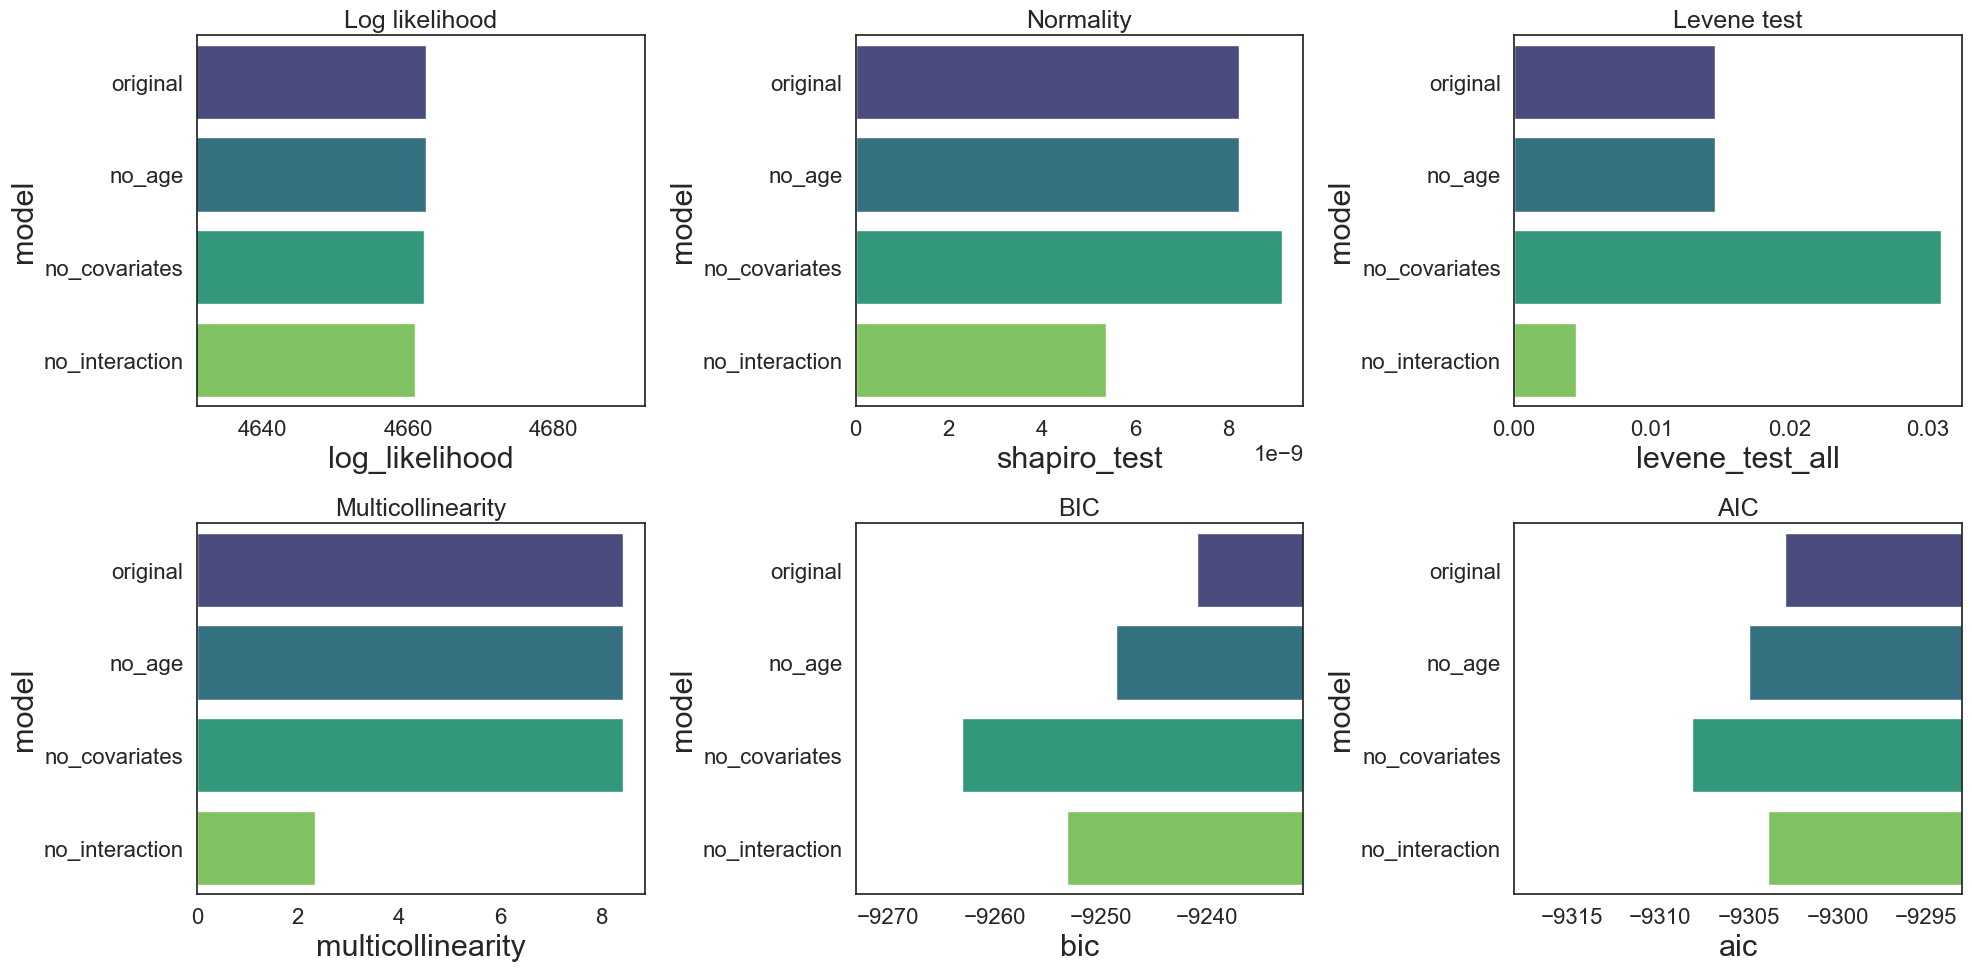

In [373]:
# Plot the different models and sort them by log likelihood

# Megerge all stages

model_comparisons_df["stage"]= "Standard"
model_comparisons_df_stages = model_comparisons_df.copy()

model_comparisons_df_stages = model_comparisons_df_stages.sort_values(by="log_likelihood", ascending=False)

# Plot the different models and sort them by log likelihood

model_comparisons_df = model_comparisons_df.sort_values(by="log_likelihood", ascending=False)

# Plot
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Plot log likelihood
sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df, ax=ax[0, 0], palette="viridis", ci=None)

# Calculate min and max of log_likelihood
log_likelihood_min = model_comparisons_df["log_likelihood"].min() - 30
log_likelihood_max = model_comparisons_df["log_likelihood"].max() + 30

# Set x-axis limits for ax[0, 0]
ax[0, 0].set_xlim(log_likelihood_min, log_likelihood_max)

# Plot Shapiro test
sns.barplot(x="shapiro_test", y="model", data=model_comparisons_df, ax=ax[0, 1], palette="viridis")

# Plot White test
sns.barplot(x="levene_test_all", y="model", data=model_comparisons_df, ax=ax[0, 2], palette="viridis")

# Plot Multicollinearity
sns.barplot(x="multicollinearity", y="model", data=model_comparisons_df, ax=ax[1, 0], palette="viridis")

# Plot BIC
sns.barplot(x="bic", y="model", data=model_comparisons_df, ax=ax[1, 1], palette="viridis")

# Calculate min and max of BIC
bic_min = model_comparisons_df["bic"].min() - 10
bic_max = model_comparisons_df["bic"].max() + 10

# Set x-axis limits for ax[1, 1]
ax[1, 1].set_xlim(bic_min, bic_max)


# Plot AIC
sns.barplot(x="aic", y="model", data=model_comparisons_df, ax=ax[1, 2], palette="viridis")

# Calculate min and max of AIC
aic_min = model_comparisons_df["aic"].min() - 10
aic_max = model_comparisons_df["aic"].max() + 10

# Set x-axis limits for ax[1, 2]
ax[1, 2].set_xlim(aic_min, aic_max)

# Add titles
ax[0, 0].set_title("Log likelihood", fontsize=18)
ax[0, 1].set_title("Normality", fontsize=18)
ax[0, 2].set_title("Levene test", fontsize=18)
ax[1, 0].set_title("Multicollinearity", fontsize=18)
ax[1, 1].set_title("BIC", fontsize=18)
ax[1, 2].set_title("AIC", fontsize=18)

# Change x-axis limits for the log likelihood plot
# ax[0, 0].set_xlim(1330, 1405)

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


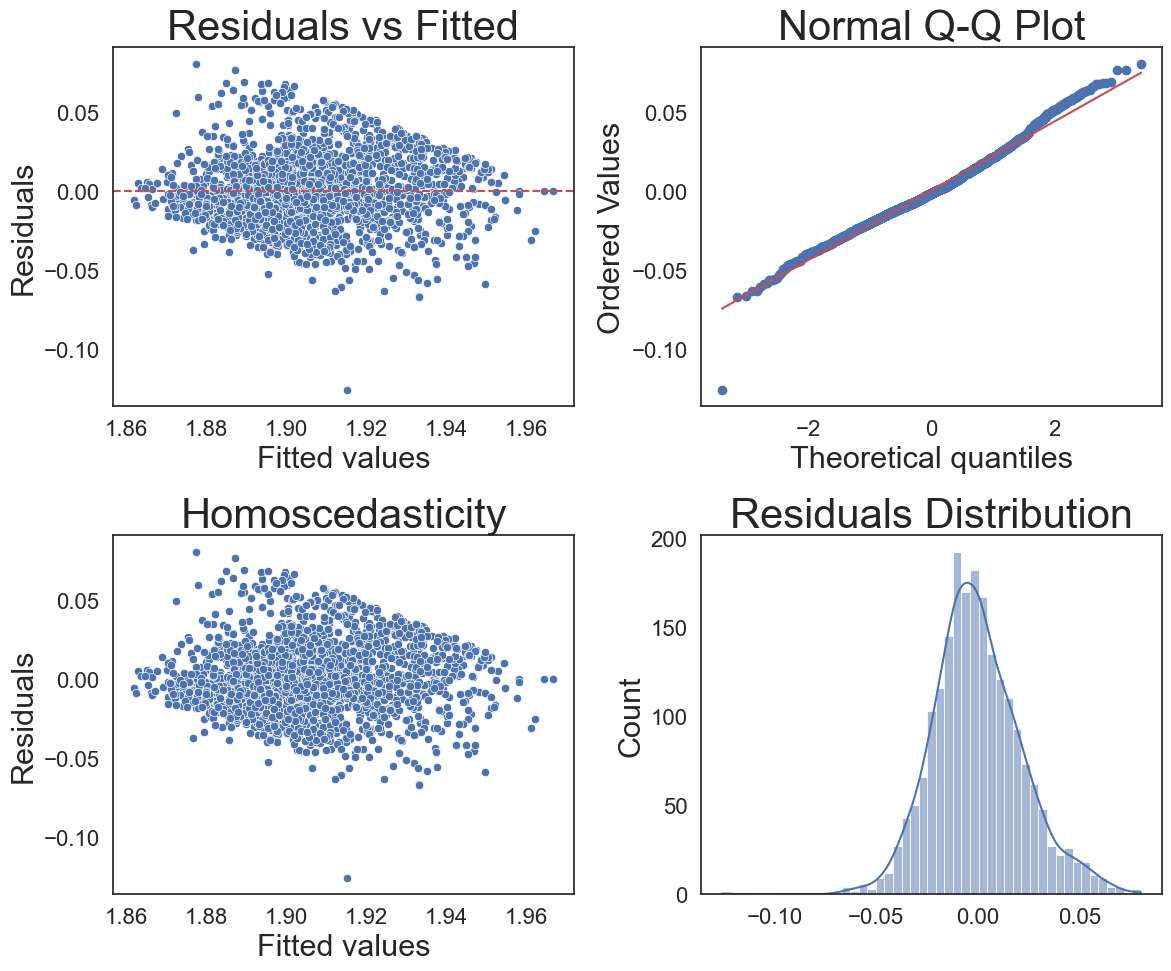

Shapiro-Wilk test p-value: 2.0017815530182226e-12


/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


Residuals are not homoscedastic LeveneResult(statistic=9.786902484072332, pvalue=2.070363134995207e-06)
Bartlett’s test p-value: 1.8261779408856722e-18
White test p-value: 0.0007019518078337215
Levene’s test p-value for the whole model: 2.070363134995207e-06
Levene’s test p-value for variable age: 0.1548121714652033
Levene’s test p-value for variable sex: 0.30109407097721935
Levene’s test p-value for variable site: 0.7748505075168851
Levene’s test p-value for variable diagnosis_group: 0.4006276459503316
Homoscedasticiyy checked


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


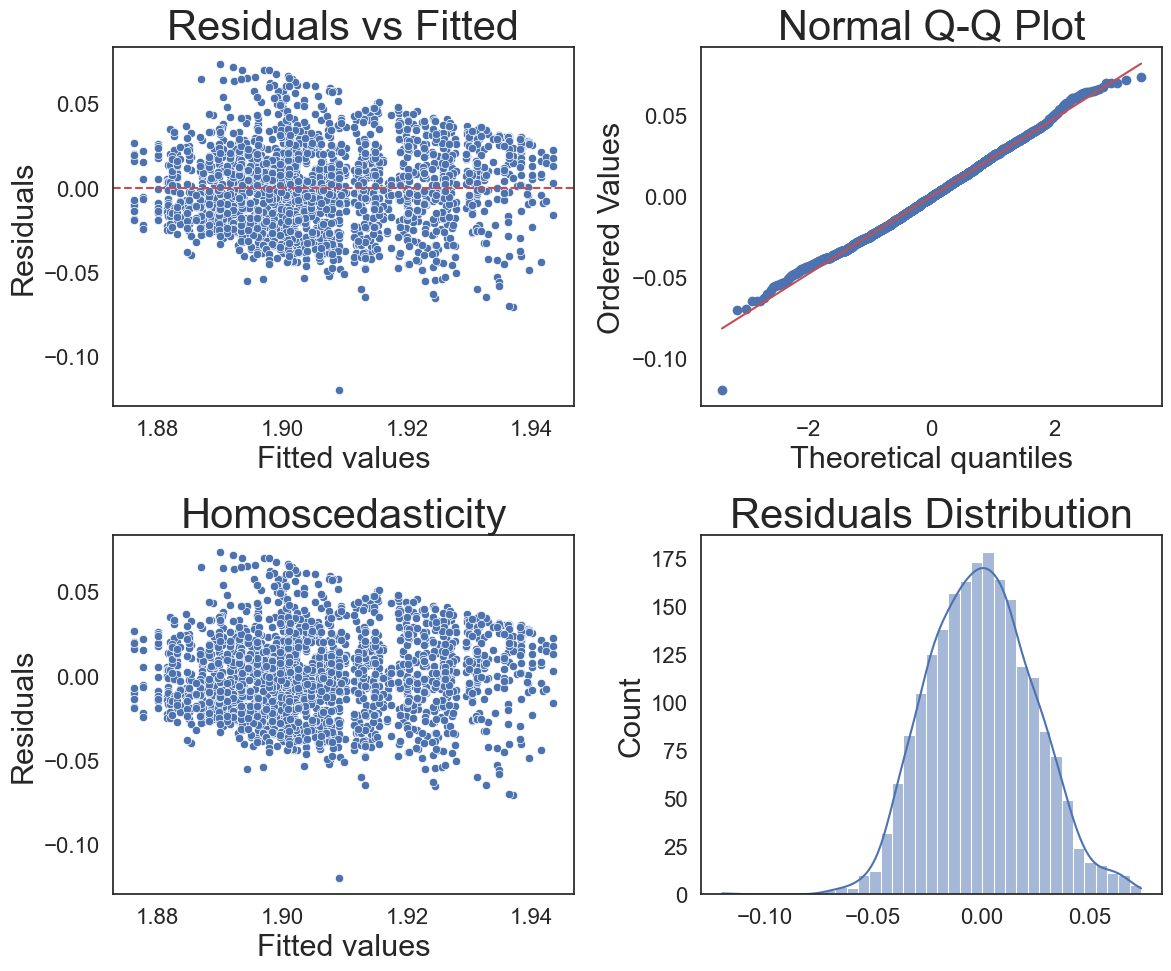

Shapiro-Wilk test p-value: 4.880718552158214e-05
Residuals are not homoscedastic LeveneResult(statistic=9.44811812006222, pvalue=3.362474008997198e-06)
Bartlett’s test p-value: 9.836066565324469e-101
White test p-value: 0.25707965683078143
Levene’s test p-value for the whole model: 3.362474008997198e-06
Levene’s test p-value for variable age: 0.3964819821204669
Levene’s test p-value for variable sex: 0.4665506448509903
Levene’s test p-value for variable site: 0.29685534065493685
Levene’s test p-value for variable diagnosis_group: 0.4136622472070851
Homoscedasticiyy checked
Likelihood Ratio Test Statistic: 17.9695
P-value: 0.0000
one model is better


/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_412/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


In [374]:
# Test the effects of group and condition on rt while accoutning for sex, age and site

# Create mixed effects model 
original = "reciprocal_rt ~ diagnosis_group * condition + sex+ age + site + total_trials + Trial_Index_"
no_covariates =  "reciprocal_rt ~ diagnosis_group * condition"

# Fit the model
model1 = smf.mixedlm(original, rt_sub, groups=rt_sub["subject"],re_formula="~1").fit()
model2 = smf.mixedlm(no_covariates, rt_sub, groups=rt_sub["subject"],re_formula="~1").fit()


# Print the summary
model_summary = model1.summary()
model_summary
model_summary = model2.summary()
model_summary

# Check assumptions
asumption_df=check_assumptions(model1, rt_sub, show_plots=True, show_text=True, covariates=["age","sex","site", "diagnosis_group"])
asumption_df
asumption_df=check_assumptions(model2, rt_sub, show_plots=True, show_text=True, covariates=["age","sex","site", "diagnosis_group"])
asumption_df

from scipy.stats import chi2
# Log-likelihoods for both models
ll_three_way = model1.llf  # Log-likelihood of 3-way interaction model
ll_two_way = model2.llf  # Log-likelihood of 2-way interaction model
# Likelihood ratio test statistic
lr_stat = 2 * (ll_three_way - ll_two_way)
# Degrees of freedom (number of random effects added in mixed model)
df_diff = 1
# Calculate p-value
p_value = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test Statistic: {lr_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("one model is better")
else:
    print("they are all the same")


## Do linear modelas with weight (failure for homoscedasticity)

In [375]:
asumption_df

'Assumptions checked'

In [376]:
# 9 supposed to make it slower, b ut it makes it faster 
# tirla total: total trials = accuracy more of it = faster reaction time 
# trial index to check why at 0 but significant 

In [377]:
model_comparison = {}
rt_sub_all = rt_sub.merge(vs_grouped, on='subject', how='inner', suffixes=('', '_dup'))
rt_sub_all = rt_sub_all.loc[:, ~rt_sub_all.columns.str.endswith('_dup')]
rt_sub_all["Trial_Index_"] = rt_sub_all["Trial_Index_"].astype(float)

models= {"original": "reciprocal_rt ~ asd * condition + age + sex + site + total_trials + Trial_Index_", 
                "trial_index_interaction": "reciprocal_rt ~ asd * condition + asd * Trial_Index_ + age + sex + site ",
                "no_interaction": "reciprocal_rt ~ asd + condition + age + sex + site + total_trials", 
                "no_age": "reciprocal_rt ~ asd * condition + sex + site + total_trials + Trial_Index_",
                "no_covariates": "reciprocal_rt ~ asd * condition"
            }
coeff_dfs = []

for model_name, formula in models.items():
    model = smf.mixedlm(formula, rt_sub, groups=rt_sub["subject"],re_formula="~1").fit()
    # Extract log likelihood
    model_comparison[model_name] = model.llf

    # Add to coeff dfs
    coef_df = pd.DataFrame(model.summary().tables[1]).reset_index()
    coef_df = coef_df.loc[coef_df["index"] != "Group Var"]
    coef_df['model'] = model_name
   
    coeff_dfs.append(coef_df)


    # Extract BIC
    if model_name=="original":
        print(model.summary())

        doc.add_heading(f"Linear model for reaction time general")
        doc.add_paragraph(f"{models[model_name]}", style='List Bullet')
        model_summary= model.summary()
        model_table=pd.DataFrame(model_summary.tables[1])
        model_table["var"] = model_table.index
        model_table = model_table[["var", "Coef.", "Std.Err.", "z", "P>|z|", "[0.025", "0.975]"]]

doc = df_to_table(doc, model_table)
model_comparison = pd.DataFrame(model_comparison, index=["log_likelihood"]).T

# Create df with all coefficients
all_coefs = pd.concat(coeff_dfs, keys=models.keys()).reset_index()


# Print the best model based on log likelihood
best_model = model_comparison.idxmax()
print(f"Best model: {best_model}")

# Add to the document
doc.add_paragraph(f"Model comparison for reaction time general", style='List Bullet')
model_comparison["type"] = model_comparison.index
model_comparison = model_comparison[["type", "log_likelihood"]]
doc = df_to_table(doc, model_comparison)
doc.add_paragraph(f'Best model= {best_model[0]} : {models[best_model[0]]}', style='List Bullet')

# Print the summary of the best model
model = smf.mixedlm(models[best_model[0]], rt_sub, groups=rt_sub["subject"],re_formula="~1").fit()
model_summary = model.summary()
model_summary


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                     Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        reciprocal_rt
No. Observations:        2082           Method:                    REML         
No. Groups:              104            Scale:                     0.0005       
Min. group size:         4              Log-Likelihood:            4615.8384    
Max. group size:         25             Converged:                 Yes          
Mean group size:         20.0                                                   
--------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             1.979    0.009 232.357 0.000  1.962  1.996
asd[T.control]                        0.001    0.004   0.333 0.739 -0.007  0.010
condition[T.Nine]                    -0.005    0.0

LinAlgError: Singular matrix